In [0]:
!pip install torchvision
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable
import gym
from gym import wrappers
import random
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import cv2
import math

## Environment - Pong
## Algorithm - DDQN

1. Replay memory size - 5000 (had to decrease due to GPU memory error)
2. Batch size - Number of random samples taken for each training
3. Gamma - discount factor
4. USE_CUDA - using GPU when available
5. episodes - numer of training episodes 
6. Transition - Tuple definition of how it will be stored in the replay memory

In [0]:
num_frames=4
TOTAL_STEPS = 0
BATCH_SIZE = 32
GAMMA = 0.99
MIN_REPLAY_MEMORY = 3000
MAX_REPLAY_MEMORY = 5000
TARGET_UPDATE_FREQUENCY = 1000
TRAIN_EVERY = 4
USE_CUDA = torch.cuda.is_available()
path = '/drive/My Drive/Pong-DDQN.model'
episodes = 1501
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

## Replay Memory

Experience Reply, where the transitions are stored and randomly retrieved in batches

In [0]:
class ReplayMemory(object):
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.memory = []
        self.pos = 0

    def add(self, *args):
        if len(self.memory) < self.maxlen:
            self.memory.append(None)
        self.memory[self.pos] = Transition(*args)
        self.pos = (self.pos + 1) % self.maxlen

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)


## DQN Network
The main neural network used for training. This one is implemented in PyTorch with 3 convolutions and 2 fully connected layers. Netowrk will be same for both DQN and DDQN 

In [0]:
class DQN(nn.Module):

    def __init__(self, num_frames,num_actions):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(num_frames, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = nn.Linear(3136, 512)
        self.fc5 = nn.Linear(512, num_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x.view(x.size(0), -1)))
        return self.fc5(x)
       

*** Images have to be preprocessed in order to make it easier for the network to train. Otherise, the memory requirement and time taken for training can be very demanding ***

In [0]:
resize = T.Compose([T.ToPILImage(), T.Resize(84, interpolation=Image.CUBIC), T.ToTensor()])

def get_preprocessed_state():
    state = env.render(mode='rgb_array')
    state =  cv2.cvtColor(state, cv2.COLOR_BGR2GRAY)[34:194,:]
    state = np.ascontiguousarray(state, dtype=np.float32) / 255
    state = torch.from_numpy(state).unsqueeze(0)
    return resize(state).unsqueeze(0)

*** As the number of steps here is more, normal decay would reach the minimum at a very faster rate, so epsilon should be decayed exponentially ***

In [0]:
#Helper Functions for GPU functionalities
def get_variable(x):
    if USE_CUDA:
        return x.cuda()
    return x

# Reference: hhttps://towardsdatascience.com/why-going-from-implementing-q-learning-to-deep-q-learning-can-be-difficult-36e7ea1648af
def decay_epsilon(steps):
    return MIN_EPSILON + (EPSILON - MIN_EPSILON) * math.exp(-1. * steps / DECAY)


*** Here, the agent class is declared where the models, replay memory and optimizer are declared. Training  and optimizations for the models happen in this class ***

In [0]:
class Agent:
    def __init__(self, num_frames, n_actions):
        self.model = DQN(num_frames, n_actions)
        self.target_model = DQN(num_frames, n_actions)
        self.memory = ReplayMemory(MAX_REPLAY_MEMORY)
        self.optimizer = optim.RMSprop(self.model.parameters(),lr=0.0001)
        self.target_model.load_state_dict(self.model.state_dict())
        if USE_CUDA:
          self.model = self.model.cuda()
          self.target_model = self.target_model.cuda()


    
    def train(self):
        if len(self.memory.memory) < MIN_REPLAY_MEMORY:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        current_states = torch.cat(batch.state)
        actions = torch.cat(batch.action)
        rewards = torch.cat(batch.reward)

        next_states = torch.cat([s for s in batch.next_state if s is not None])
        not_none_states = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),  dtype=torch.bool)

        current_state_action_values = self.model(current_states).gather(1, actions)

        
        main_next_state_action_values = self.model(next_states).max(1)[1].view(-1,1).detach() #
        target_next_state_values = get_variable(torch.zeros(BATCH_SIZE))
        
        #actions are estimated in target model using the main model
        target_next_state_values[not_none_states] = self.target_model(next_states).gather(1, main_next_state_action_values).view(-1).detach()

        expected_state_action_values = (target_next_state_values * GAMMA) + rewards

        loss = nn.MSELoss()(current_state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

*** This is the main function where the environment is decalred and Training actually starts. ***

Episode:  0
Steps:  1  epsilon:  1.0
Steps:  201  epsilon:  0.990348338736693


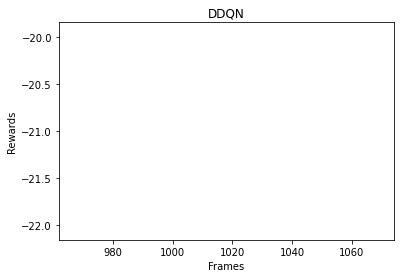

Episode:  1
Steps:  255  epsilon:  0.9877588955435013
Steps:  455  epsilon:  0.9782290353046303
Episode:  2
Steps:  538  epsilon:  0.9743020389615841
Steps:  738  epsilon:  0.9649060766829168
Episode:  3
Steps:  877  epsilon:  0.9584310063827495
Steps:  1077  epsilon:  0.9491929635168139
Episode:  4
Steps:  1171  epsilon:  0.9448828931876766
Steps:  1371  epsilon:  0.9357796563004172
Episode:  5
Steps:  1499  epsilon:  0.9300011773565761
Steps:  1699  epsilon:  0.9210460160159337
Episode:  6
Steps:  1818  epsilon:  0.9157600336130276
Steps:  2018  epsilon:  0.9069465740202355
Episode:  7
Steps:  2092  epsilon:  0.9037078669991737
Steps:  2292  epsilon:  0.8950143284678721
Episode:  8
Steps:  2417  epsilon:  0.8896248485834551
Steps:  2617  epsilon:  0.8810714384267035
Episode:  9
Steps:  2711  epsilon:  0.8770807880406248
Steps:  2911  epsilon:  0.8686521933717348
Episode:  10
Steps:  3044  epsilon:  0.8630936588972828
Steps:  3244  epsilon:  0.8548042384887411


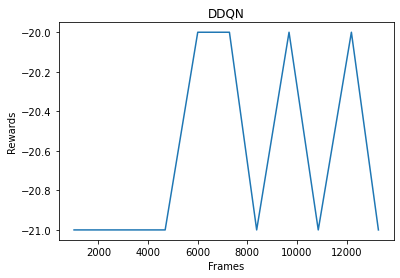

Episode:  11
Steps:  3316  epsilon:  0.8518402815537374
Steps:  3516  epsilon:  0.8436628341206472
Episode:  12
Steps:  3577  epsilon:  0.8411849431811433
Steps:  3777  epsilon:  0.8331135181363193
Episode:  13
Steps:  3872  epsilon:  0.8293077747213701
Steps:  4072  epsilon:  0.8213545294773099
Episode:  14
Steps:  4128  epsilon:  0.8191418360112521
Steps:  4328  epsilon:  0.8112897435474535
Episode:  15
Steps:  4460  epsilon:  0.8061502103560637
Steps:  4660  epsilon:  0.7984273867274028
Episode:  16
Steps:  4722  epsilon:  0.796048950309726
Steps:  4922  epsilon:  0.7884266358978689
Episode:  17
Steps:  5033  epsilon:  0.7842290272074829
Steps:  5233  epsilon:  0.7767243229955652
Episode:  18
Steps:  5316  epsilon:  0.7736318383990298
Steps:  5516  epsilon:  0.7662325779775476
Episode:  19
Steps:  5646  epsilon:  0.7614625854906129
Steps:  5846  epsilon:  0.7541844111587178
Episode:  20
Steps:  5930  epsilon:  0.75114921500551
Steps:  6130  epsilon:  0.7439736604245483


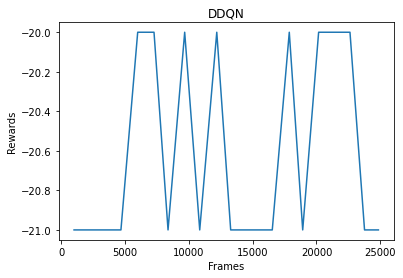

Episode:  21
Steps:  6201  epsilon:  0.7414435475375606
Steps:  6401  epsilon:  0.7343645659614803
Episode:  22
Steps:  6510  epsilon:  0.73053622079352
Steps:  6710  epsilon:  0.7235657689318948
Episode:  23
Steps:  6797  epsilon:  0.7205553103316122
Steps:  6997  epsilon:  0.7136841701884179
Episode:  24
Steps:  7081  epsilon:  0.7108187183347322
Steps:  7281  epsilon:  0.7040444589006233
Episode:  25
Steps:  7404  epsilon:  0.6999118064103879
Steps:  7604  epsilon:  0.6932460725632094
Episode:  26
Steps:  7713  epsilon:  0.6896412136311023
Steps:  7913  epsilon:  0.6830776738895722
Episode:  27
Steps:  8044  epsilon:  0.6788139939210257
Steps:  8244  epsilon:  0.6723581868156453
Episode:  28
Steps:  8329  epsilon:  0.6696339576092736
Steps:  8529  epsilon:  0.6632694933913837
Episode:  29
Steps:  8703  epsilon:  0.657783945532116
Steps:  8903  epsilon:  0.6515373909044682
Episode:  30
Steps:  9007  epsilon:  0.6483137851106839
Steps:  9207  epsilon:  0.6421614601536515


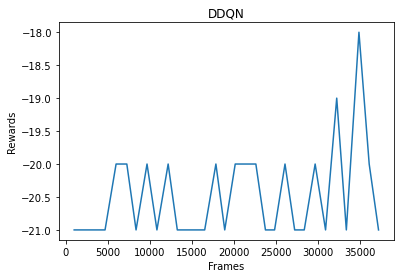

Episode:  31
Steps:  9284  epsilon:  0.6398091695969497
Steps:  9484  epsilon:  0.6337414669781783
Episode:  32
Steps:  9591  epsilon:  0.630520075036975
Steps:  9791  epsilon:  0.6245448004533951
Episode:  33
Steps:  9864  epsilon:  0.6223786675291851
Steps:  10064  epsilon:  0.6164844013038234
Episode:  34
Steps:  10172  epsilon:  0.6133259211084136
Steps:  10372  epsilon:  0.6075217312149651
Episode:  35
Steps:  10559  epsilon:  0.602147068730698
Steps:  10759  epsilon:  0.5964541102769014
Episode:  36
Steps:  10893  epsilon:  0.5926715534533094
Steps:  11093  epsilon:  0.5870728779518349
Episode:  37
Steps:  11199  epsilon:  0.5841282019830001
Steps:  11399  epsilon:  0.5786145342489947
Episode:  38
Steps:  11452  epsilon:  0.5771626303555598
Steps:  11652  epsilon:  0.5717182712172795
Episode:  39
Steps:  11762  epsilon:  0.5687469992136721
Steps:  11962  epsilon:  0.5633863770043592
Episode:  40
Steps:  12036  epsilon:  0.561416493940419
Steps:  12236  epsilon:  0.556128811477277

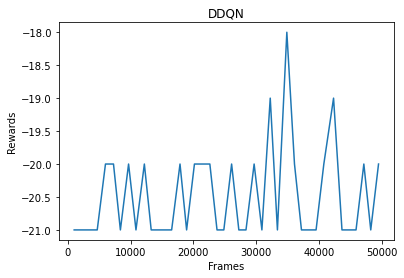

Episode:  41
Steps:  12345  epsilon:  0.5532692089497226
Steps:  12545  epsilon:  0.5480625933267316
Episode:  42
Steps:  12679  epsilon:  0.5446031759407796
Steps:  12879  epsilon:  0.5394827887869627
Episode:  43
Steps:  12941  epsilon:  0.5379058376788156
Steps:  13141  epsilon:  0.5328520901541433
Episode:  44
Steps:  13223  epsilon:  0.5307946172860667
Steps:  13423  epsilon:  0.5258116275865485
Episode:  45
Steps:  13507  epsilon:  0.5237335856933814
Steps:  13707  epsilon:  0.5188208544321128
Episode:  46
Steps:  13787  epsilon:  0.5168694763723406
Steps:  13987  epsilon:  0.5120250441399803
Episode:  47
Steps:  14085  epsilon:  0.5096688986942888
Steps:  14285  epsilon:  0.5048961134069272
Episode:  48
Steps:  14365  epsilon:  0.5030003230617097
Steps:  14565  epsilon:  0.49829389121054846
Episode:  49
Steps:  14759  epsilon:  0.4937734002911256
Steps:  14959  epsilon:  0.4891587778555153
Episode:  50
Steps:  15072  epsilon:  0.48657184572567325
Steps:  15272  epsilon:  0.48202

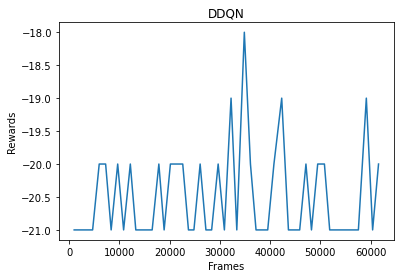

Episode:  51
Steps:  15365  epsilon:  0.47993182509464194
Steps:  15565  epsilon:  0.47545492863341
Episode:  52
Steps:  15722  epsilon:  0.4719717966233673
Steps:  15922  epsilon:  0.46757410376878594
Episode:  53
Steps:  16061  epsilon:  0.46454350726920135
Steps:  16261  epsilon:  0.4602197271286532
Episode:  54
Steps:  16381  epsilon:  0.45764613725626346
Steps:  16581  epsilon:  0.4533909870940376
Episode:  55
Steps:  16685  epsilon:  0.4511950682981526
Steps:  16885  epsilon:  0.44700410734455553
Steps:  17085  epsilon:  0.44285484714919743
Episode:  56
Steps:  17109  epsilon:  0.4423597184692417
Steps:  17309  epsilon:  0.4382566707153266
Episode:  57
Steps:  17402  epsilon:  0.4363626841280416
Steps:  17602  epsilon:  0.43231930786283324
Episode:  58
Steps:  17704  epsilon:  0.43027270267198436
Steps:  17904  epsilon:  0.4262899227347282
Episode:  59
Steps:  18102  epsilon:  0.42238600875899956
Steps:  18302  epsilon:  0.4184817027373471
Episode:  60
Steps:  18491  epsilon:  0.

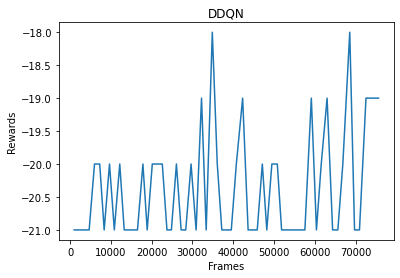

Episode:  61
Steps:  18870  epsilon:  0.4076040166379318
Steps:  19070  epsilon:  0.40384679389540246
Episode:  62
Steps:  19207  epsilon:  0.4012946942776431
Steps:  19407  epsilon:  0.3976002503415288
Episode:  63
Steps:  19542  epsilon:  0.39512730423429554
Steps:  19742  epsilon:  0.3914942268544461
Episode:  64
Steps:  19914  epsilon:  0.3883987063204952
Steps:  20114  epsilon:  0.38483257960852335
Steps:  20314  epsilon:  0.38130193645020694
Episode:  65
Steps:  20335  epsilon:  0.38093326300436514
Steps:  20535  epsilon:  0.37744141869452474
Episode:  66
Steps:  20714  epsilon:  0.3743456920385869
Steps:  20914  epsilon:  0.37091939515504513
Steps:  21114  epsilon:  0.3675271904951194
Episode:  67
Steps:  21173  epsilon:  0.36653295250522344
Steps:  21373  epsilon:  0.3631843936789131
Steps:  21573  epsilon:  0.35986915356962534
Episode:  68
Steps:  21594  epsilon:  0.3595229727351207
Steps:  21794  epsilon:  0.35624416437293793
Episode:  69
Steps:  21929  epsilon:  0.3540494318

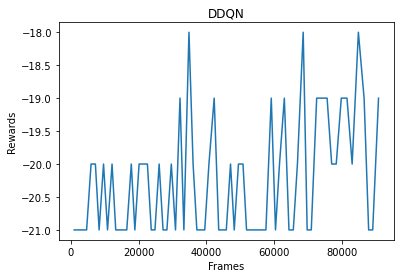

Episode:  71
Steps:  22657  epsilon:  0.3424661275611839
Steps:  22857  epsilon:  0.33935703764419645
Episode:  72
Steps:  23036  epsilon:  0.33660064541198786
Steps:  23236  epsilon:  0.3335499180175262
Episode:  73
Steps:  23399  epsilon:  0.33108604012615306
Steps:  23599  epsilon:  0.32809018397109313
Episode:  74
Steps:  23699  epsilon:  0.3266034529760802
Steps:  23899  epsilon:  0.3236521993083973
Steps:  24099  epsilon:  0.3207303111053563
Episode:  75
Steps:  24125  epsilon:  0.3203526072616111
Steps:  24325  epsilon:  0.3174635505479956
Episode:  76
Steps:  24499  epsilon:  0.3149734652355305
Steps:  24699  epsilon:  0.31213793187936123
Episode:  77
Steps:  24848  epsilon:  0.31004381455959606
Steps:  25048  epsilon:  0.30725733204721095
Episode:  78
Steps:  25242  epsilon:  0.30458093742540016
Steps:  25442  epsilon:  0.3018488114487081
Steps:  25642  epsilon:  0.2991438705797024
Episode:  79
Steps:  25739  epsilon:  0.2978416831644305
Steps:  25939  epsilon:  0.295176613888

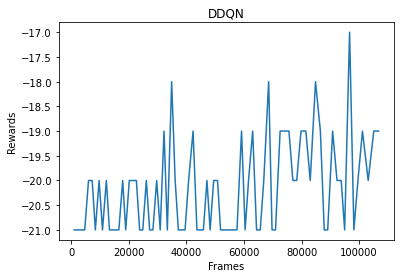

Episode:  81
Steps:  26636  epsilon:  0.28609438591210357
Steps:  26836  epsilon:  0.28354620419637344
Episode:  82
Steps:  26932  epsilon:  0.28233209860074215
Steps:  27132  epsilon:  0.27982135226924354
Steps:  27332  epsilon:  0.27733558828115684
Episode:  83
Steps:  27377  epsilon:  0.2767797088064449
Steps:  27577  epsilon:  0.2743242096764889
Episode:  84
Steps:  27772  epsilon:  0.2719536240166882
Steps:  27972  epsilon:  0.26954614523273085
Steps:  28172  epsilon:  0.26716262126291923
Episode:  85
Steps:  28200  epsilon:  0.26683082590409557
Steps:  28400  epsilon:  0.264474319813028
Steps:  28600  epsilon:  0.2621412613493376
Episode:  86
Steps:  28733  epsilon:  0.2606026435357178
Steps:  28933  epsilon:  0.25830810889465605
Steps:  29133  epsilon:  0.25603640525474125
Episode:  87
Steps:  29162  epsilon:  0.2557088899730844
Steps:  29362  epsilon:  0.25346304899356153
Episode:  88
Steps:  29542  epsilon:  0.25146090471632265
Steps:  29742  epsilon:  0.24925733189633562
Epis

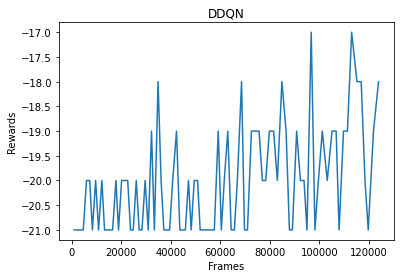

Episode:  91
Steps:  30907  epsilon:  0.23685045064183405
Steps:  31107  epsilon:  0.23479225426888828
Steps:  31307  epsilon:  0.23275453729203022
Episode:  92
Steps:  31342  epsilon:  0.23240002713862729
Steps:  31542  epsilon:  0.23038611321942504
Steps:  31742  epsilon:  0.22839223807853373
Episode:  93
Steps:  31779  epsilon:  0.22802555172754513
Steps:  31979  epsilon:  0.22605516456594332
Steps:  32179  epsilon:  0.22410438308417796
Episode:  94
Steps:  32193  epsilon:  0.22396855756049855
Steps:  32393  epsilon:  0.22203853816533753
Episode:  95
Steps:  32567  epsilon:  0.2203750495512117
Steps:  32767  epsilon:  0.2184807861581668
Steps:  32967  epsilon:  0.2166053710008055
Episode:  96
Steps:  33077  epsilon:  0.21558185869923308
Steps:  33277  epsilon:  0.2137352883520373
Steps:  33477  epsilon:  0.21190709168678998
Episode:  97
Steps:  33629  epsilon:  0.2105298379832187
Steps:  33829  epsilon:  0.20873353608204995
Episode:  98
Steps:  34021  epsilon:  0.20702590388480416
S

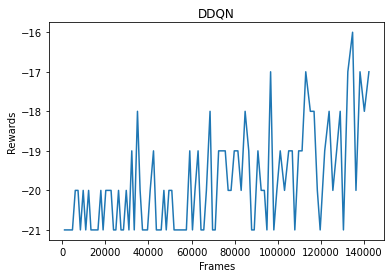

Episode:  101
Steps:  35521  epsilon:  0.19423462924055152
Steps:  35721  epsilon:  0.19260046737546427
Steps:  35921  epsilon:  0.19098256569261543
Episode:  102
Steps:  35959  epsilon:  0.19067698920738804
Steps:  36159  epsilon:  0.18907822645209138
Steps:  36359  epsilon:  0.18749537165200558
Episode:  103
Steps:  36414  epsilon:  0.1870628543638098
Steps:  36614  epsilon:  0.1855000528510597
Steps:  36814  epsilon:  0.1839528014731785
Episode:  104
Steps:  36856  epsilon:  0.1836298398185106
Steps:  37056  epsilon:  0.18210119737122776
Steps:  37256  epsilon:  0.18058776517043346
Episode:  105
Steps:  37452  epsilon:  0.17911921273200737
Steps:  37652  epsilon:  0.1776354517741307
Steps:  37852  epsilon:  0.17616645448446142
Episode:  106
Steps:  37900  epsilon:  0.1758160756165221
Steps:  38100  epsilon:  0.1743651814220938
Steps:  38300  epsilon:  0.17292872386611247
Episode:  107
Steps:  38358  epsilon:  0.1725148310016241
Steps:  38558  epsilon:  0.17109678473994874
Episode:  

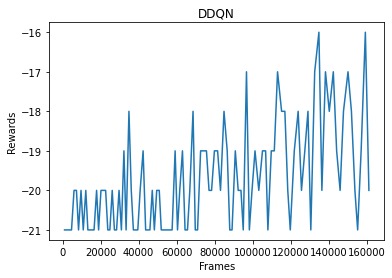

Episode:  111
Steps:  40194  epsilon:  0.1600145115453218
Steps:  40394  epsilon:  0.15872084554042518
Steps:  40594  epsilon:  0.15744005172735023
Episode:  112
Steps:  40703  epsilon:  0.15674739265588064
Steps:  40903  epsilon:  0.1554862350270951
Steps:  41103  epsilon:  0.15423762612638459
Episode:  113
Steps:  41107  epsilon:  0.15421278108574618
Steps:  41307  epsilon:  0.15297684326346478
Steps:  41507  epsilon:  0.15175320322799082
Episode:  114
Steps:  41624  epsilon:  0.15104302628200877
Steps:  41824  epsilon:  0.14983862804699902
Steps:  42024  epsilon:  0.14864621377465972
Episode:  115
Steps:  42192  epsilon:  0.14765375972159844
Steps:  42392  epsilon:  0.1464830852523331
Steps:  42592  epsilon:  0.14532405918866254
Episode:  116
Steps:  42656  epsilon:  0.14495561202912227
Steps:  42856  epsilon:  0.14381178457796637
Steps:  43056  epsilon:  0.1426793384001117
Episode:  117
Steps:  43084  epsilon:  0.1425216977005892
Steps:  43284  epsilon:  0.1414020881016425
Steps:  

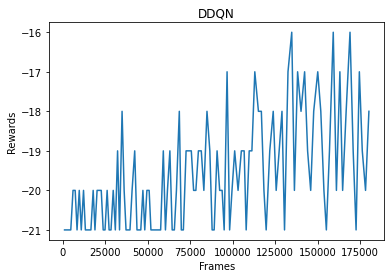

Episode:  121
Steps:  44969  epsilon:  0.13240095835502752
Steps:  45169  epsilon:  0.1313820517951505
Steps:  45369  epsilon:  0.13037328352493827
Episode:  122
Steps:  45527  epsilon:  0.12958345850167718
Steps:  45727  epsilon:  0.12859258653375266
Steps:  45927  epsilon:  0.1276115739066423
Episode:  123
Steps:  45989  epsilon:  0.127309446566862
Steps:  46189  epsilon:  0.12634120139574523
Steps:  46389  epsilon:  0.1253825904250527
Episode:  124
Steps:  46532  epsilon:  0.12470303720132422
Steps:  46732  epsilon:  0.12376072623671235
Steps:  46932  epsilon:  0.1228277914228583
Episode:  125
Steps:  46984  epsilon:  0.12258675265134701
Steps:  47184  epsilon:  0.12166549906984145
Steps:  47384  epsilon:  0.12075341211463105
Steps:  47584  epsilon:  0.11985040057626019
Episode:  126
Steps:  47656  epsilon:  0.11952752066673301
Steps:  47856  epsilon:  0.11863670695207425
Episode:  127
Steps:  48056  epsilon:  0.11775475698197482
Steps:  48256  epsilon:  0.11688158256070284
Steps:  

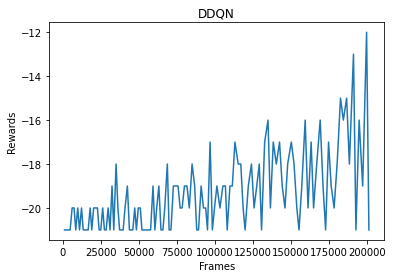

Episode:  131
Steps:  50187  epsilon:  0.1088853925160138
Steps:  50387  epsilon:  0.10810046974571734
Steps:  50587  epsilon:  0.10732335708747938
Episode:  132
Steps:  50723  epsilon:  0.1067993419300234
Steps:  50923  epsilon:  0.10603517570986516
Steps:  51123  epsilon:  0.10527861307064079
Episode:  133
Steps:  51205  epsilon:  0.10497060260996673
Steps:  51405  epsilon:  0.10422463265007254
Steps:  51605  epsilon:  0.10348608521529735
Episode:  134
Steps:  51707  epsilon:  0.10311226024463979
Steps:  51907  epsilon:  0.10238478110023154
Steps:  52107  epsilon:  0.10166454049425415
Episode:  135
Steps:  52224  epsilon:  0.10124652681449815
Steps:  52424  epsilon:  0.10053761202789951
Steps:  52624  epsilon:  0.09983575106128526
Episode:  136
Steps:  52749  epsilon:  0.09940063875947563
Steps:  52949  epsilon:  0.09871009086590492
Steps:  53149  epsilon:  0.0980264140386794
Steps:  53349  epsilon:  0.09734953990954659
Episode:  137
Steps:  53363  epsilon:  0.09730241172839774
Steps

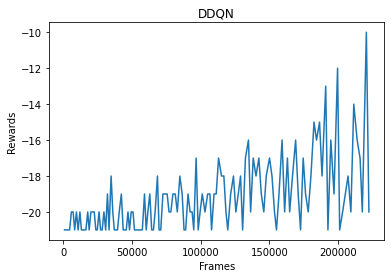

Episode:  141
Steps:  55496  epsilon:  0.09049411402720647
Steps:  55696  epsilon:  0.08989218753543901
Steps:  55896  epsilon:  0.08929625031233537
Steps:  56096  epsilon:  0.0887062427636767
Episode:  142
Steps:  56196  epsilon:  0.0884134441563734
Steps:  56396  epsilon:  0.0878322206757338
Steps:  56596  epsilon:  0.08725678046535544
Steps:  56796  epsilon:  0.08668706598073778
Steps:  56996  epsilon:  0.08612302024995758
Episode:  143
Steps:  57075  epsilon:  0.08590177157377499
Steps:  57275  epsilon:  0.08534553965289988
Steps:  57475  epsilon:  0.08479484233211153
Steps:  57675  epsilon:  0.08424962454121888
Episode:  144
Steps:  57749  epsilon:  0.08404927181153532
Steps:  57949  epsilon:  0.08351147257127413
Steps:  58149  epsilon:  0.08297902452286313
Episode:  145
Steps:  58230  epsilon:  0.08276489338179663
Steps:  58430  epsilon:  0.0822398739204403
Steps:  58630  epsilon:  0.08172007849000944
Steps:  58830  epsilon:  0.08120545511052775
Episode:  146
Steps:  58848  epsil

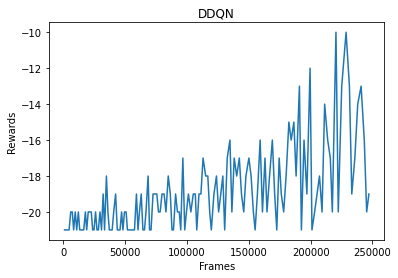

Episode:  151
Steps:  61686  epsilon:  0.0743914139617185
Steps:  61886  epsilon:  0.07394971201268988
Steps:  62086  epsilon:  0.07351240507148744
Episode:  152
Steps:  62263  epsilon:  0.07312901927107951
Steps:  62463  epsilon:  0.07269987835909694
Steps:  62663  epsilon:  0.07227500747053361
Episode:  153
Steps:  62847  epsilon:  0.07188786100620981
Steps:  63047  epsilon:  0.0714710698253063
Steps:  63247  epsilon:  0.07105842578594462
Episode:  154
Steps:  63423  epsilon:  0.07069869676815485
Steps:  63623  epsilon:  0.07029373796911953
Steps:  63823  epsilon:  0.06989280857745932
Episode:  155
Steps:  63846  epsilon:  0.06984695821660582
Steps:  64046  epsilon:  0.06945047435776065
Steps:  64246  epsilon:  0.06905793557922674
Episode:  156
Steps:  64418  epsilon:  0.0687234775640842
Steps:  64618  epsilon:  0.06833817252451119
Episode:  157
Steps:  64804  epsilon:  0.0679832803266352
Steps:  65004  epsilon:  0.06760534037263322
Steps:  65204  epsilon:  0.0672311609840064
Episode

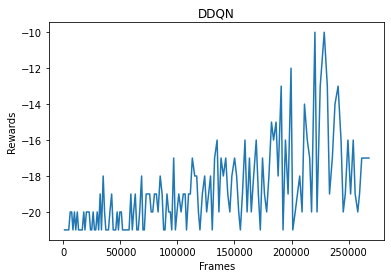

Episode:  161
Steps:  66854  epsilon:  0.0642828788787611
Steps:  67054  epsilon:  0.06394175853436028
Steps:  67254  epsilon:  0.06360403239409781
Episode:  162
Steps:  67328  epsilon:  0.06347992721041276
Steps:  67528  epsilon:  0.0631467963686034
Steps:  67728  epsilon:  0.06281698023405333
Episode:  163
Steps:  67890  epsilon:  0.06255223635435583
Steps:  68090  epsilon:  0.062228336190793626
Steps:  68290  epsilon:  0.06190765888770753
Episode:  164
Steps:  68378  epsilon:  0.06176757360223385
Steps:  68578  epsilon:  0.06145148096350607
Steps:  68778  epsilon:  0.06113853349908431
Episode:  165
Steps:  68946  epsilon:  0.060878065315613704
Steps:  69146  epsilon:  0.0605708234322193
Steps:  69346  epsilon:  0.06026663865664389
Episode:  166
Steps:  69544  epsilon:  0.05996847726804584
Steps:  69744  epsilon:  0.0596702859369445
Steps:  69944  epsilon:  0.05937506165916218
Episode:  167
Steps:  70074  epsilon:  0.059184742964216136
Steps:  70274  epsilon:  0.058894349919734384
St

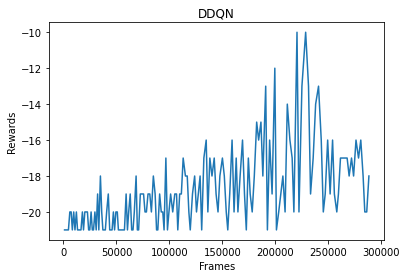

Episode:  171
Steps:  71988  epsilon:  0.05652124398106238
Steps:  72188  epsilon:  0.056257353194271935
Episode:  172
Steps:  72337  epsilon:  0.05606246278117134
Steps:  72537  epsilon:  0.05580313694359257
Steps:  72737  epsilon:  0.05554639144121083
Episode:  173
Steps:  72902  epsilon:  0.05533650070159446
Steps:  73102  epsilon:  0.055084398307399265
Steps:  73302  epsilon:  0.05483480437393856
Steps:  73502  epsilon:  0.054587693941610976
Episode:  174
Steps:  73512  epsilon:  0.05457540316758974
Steps:  73712  epsilon:  0.05433087382039099
Steps:  73912  epsilon:  0.054088777580850095
Episode:  175
Steps:  74099  epsilon:  0.05386459718700885
Steps:  74299  epsilon:  0.05362714047748897
Steps:  74499  epsilon:  0.053392046501706196
Steps:  74699  epsilon:  0.05315929175006702
Episode:  176
Steps:  74731  epsilon:  0.053122266511356604
Steps:  74931  epsilon:  0.05289219611547256
Steps:  75131  epsilon:  0.052664414958276964
Episode:  177
Steps:  75252  epsilon:  0.0525277091996

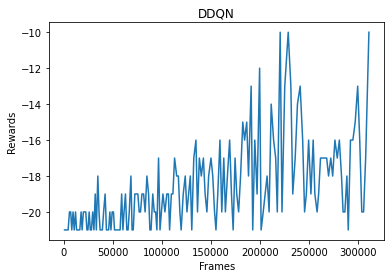

Episode:  181
Steps:  77585  epsilon:  0.05004733187832801
Steps:  77785  epsilon:  0.04984785759325304
Steps:  77985  epsilon:  0.049650368110477336
Episode:  182
Steps:  78184  epsilon:  0.04945581644739105
Steps:  78384  epsilon:  0.04926222783919383
Steps:  78584  epsilon:  0.049070565469832454
Episode:  183
Steps:  78675  epsilon:  0.04898399150207944
Steps:  78875  epsilon:  0.04879509763052936
Steps:  79075  epsilon:  0.048608083284404975
Episode:  184
Steps:  79173  epsilon:  0.04851712670192735
Steps:  79373  epsilon:  0.048332878212755455
Steps:  79573  epsilon:  0.048150463026682286
Episode:  185
Steps:  79767  epsilon:  0.047975254669632525
Steps:  79967  epsilon:  0.04779639789726864
Steps:  80167  epsilon:  0.047619320779524854
Episode:  186
Steps:  80300  epsilon:  0.047502541019400865
Steps:  80500  epsilon:  0.04732838782644583
Steps:  80700  epsilon:  0.04715596748671379
Episode:  187
Steps:  80814  epsilon:  0.04705845664195754
Steps:  81014  epsilon:  0.046888722162

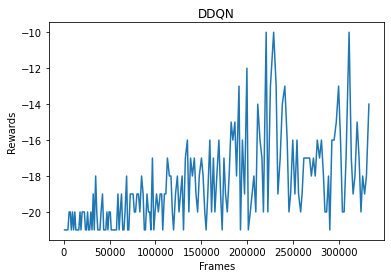

Episode:  191
Steps:  82971  epsilon:  0.04531443842781849
Steps:  83171  epsilon:  0.04516205721942357
Steps:  83371  epsilon:  0.04501119222938568
Episode:  192
Steps:  83437  epsilon:  0.044961736941134985
Steps:  83637  epsilon:  0.044812865171169475
Steps:  83837  epsilon:  0.04466547470006519
Steps:  84037  epsilon:  0.04451955078865216
Episode:  193
Steps:  84073  epsilon:  0.04449343910479822
Steps:  84273  epsilon:  0.04434922697615917
Steps:  84473  epsilon:  0.04420644978217546
Episode:  194
Steps:  84570  epsilon:  0.04413771531654489
Steps:  84770  epsilon:  0.04399704269873832
Steps:  84970  epsilon:  0.043857769796865884
Steps:  85170  epsilon:  0.04371988268352131
Episode:  195
Steps:  85174  epsilon:  0.043717138981363965
Steps:  85374  epsilon:  0.04358065116801363
Steps:  85574  epsilon:  0.04344552143109734
Episode:  196
Steps:  85691  epsilon:  0.04336709475242349
Steps:  85891  epsilon:  0.04323408993734626
Steps:  86091  epsilon:  0.04310240854229121
Steps:  8629

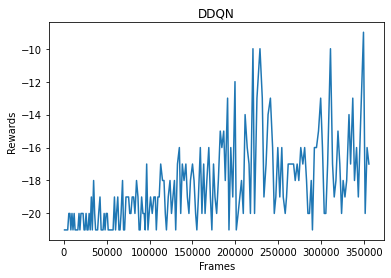

Episode:  201
Steps:  88767  epsilon:  0.041461528409928436
Steps:  88967  epsilon:  0.04134748429676102
Steps:  89167  epsilon:  0.041234574941479536
Steps:  89367  epsilon:  0.04112278905305439
Episode:  202
Steps:  89395  epsilon:  0.04110722804362835
Steps:  89595  epsilon:  0.04099670927800833
Steps:  89795  epsilon:  0.04088729019248009
Episode:  203
Steps:  89965  epsilon:  0.04079514041720669
Steps:  90165  epsilon:  0.0406877269753544
Steps:  90365  epsilon:  0.04058138231510613
Episode:  204
Steps:  90554  epsilon:  0.04048185923939828
Steps:  90754  epsilon:  0.040377562997348446
Steps:  90954  epsilon:  0.04027430452024635
Episode:  205
Steps:  91013  epsilon:  0.0402440399840506
Steps:  91213  epsilon:  0.04014211008312913
Steps:  91413  epsilon:  0.04004119440166776
Episode:  206
Steps:  91498  epsilon:  0.03999860988166423
Steps:  91698  epsilon:  0.03989912205106446
Steps:  91898  epsilon:  0.03980062414091909
Episode:  207
Steps:  91937  epsilon:  0.03978153154517512
S

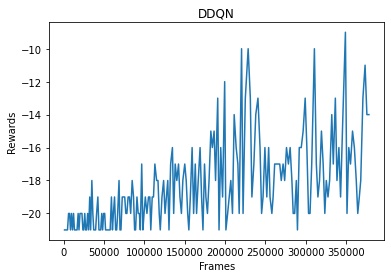

Episode:  211
Steps:  94467  epsilon:  0.038619232740552754
Steps:  94667  epsilon:  0.03853346994182964
Steps:  94867  epsilon:  0.03844856049721196
Steps:  95067  epsilon:  0.038364495915684485
Episode:  212
Steps:  95230  epsilon:  0.03829660231619438
Steps:  95430  epsilon:  0.03821404974383121
Steps:  95630  epsilon:  0.038132318583287486
Episode:  213
Steps:  95813  epsilon:  0.03805824726133397
Steps:  96013  epsilon:  0.03797806636139339
Steps:  96213  epsilon:  0.03789868327473736
Steps:  96413  epsilon:  0.03782009006299106
Episode:  214
Steps:  96428  epsilon:  0.0378142271942944
Steps:  96628  epsilon:  0.0377364743345894
Steps:  96828  epsilon:  0.03765949512876493
Steps:  97028  epsilon:  0.037583281878836285
Episode:  215
Steps:  97171  epsilon:  0.03752925479041019
Steps:  97371  epsilon:  0.037454337453500734
Steps:  97571  epsilon:  0.0373801655565486
Episode:  216
Steps:  97672  epsilon:  0.03734298966861154
Steps:  97872  epsilon:  0.037269925700630716
Steps:  98072

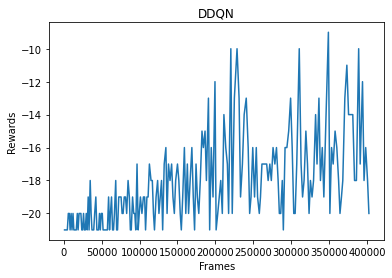

Episode:  221
Steps:  100545  epsilon:  0.0363604305493374
Steps:  100745  epsilon:  0.03629714320794462
Steps:  100945  epsilon:  0.036234485586120274
Steps:  101145  epsilon:  0.036172451418049964
Episode:  222
Steps:  101148  epsilon:  0.03617152561977387
Steps:  101348  epsilon:  0.036110117913835844
Steps:  101548  epsilon:  0.03604932122478099
Episode:  223
Steps:  101637  epsilon:  0.03602246155242574
Steps:  101837  epsilon:  0.03596253705873986
Steps:  102037  epsilon:  0.03590320882372866
Episode:  224
Steps:  102147  epsilon:  0.035870830297765374
Steps:  102347  epsilon:  0.03581241456027219
Steps:  102547  epsilon:  0.03575458006907872
Episode:  225
Steps:  102704  epsilon:  0.03570958345830049
Steps:  102904  epsilon:  0.035652772153667404
Steps:  103104  epsilon:  0.03559652613096034
Steps:  103304  epsilon:  0.03554083976553016
Steps:  103504  epsilon:  0.03548570748869391
Episode:  226
Steps:  103530  epsilon:  0.035478580702373405
Steps:  103730  epsilon:  0.035424067

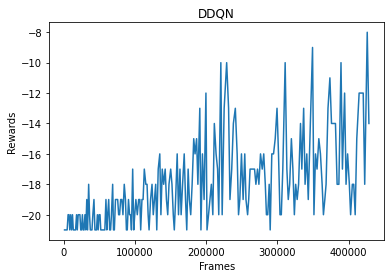

Episode:  231
Steps:  106960  epsilon:  0.03461515785204869
Steps:  107160  epsilon:  0.03456923626414698
Steps:  107360  epsilon:  0.03452377160367938
Steps:  107560  epsilon:  0.034478759324141975
Episode:  232
Steps:  107651  epsilon:  0.03445842725974068
Steps:  107851  epsilon:  0.034414065167289024
Steps:  108051  epsilon:  0.03437014448503249
Episode:  233
Steps:  108201  epsilon:  0.03433749100500788
Steps:  108401  epsilon:  0.034294332248396564
Steps:  108601  epsilon:  0.03425160292858871
Episode:  234
Steps:  108704  epsilon:  0.034229763458411944
Steps:  108904  epsilon:  0.034187676608799046
Steps:  109104  epsilon:  0.03414600853033678
Steps:  109304  epsilon:  0.03410475505618256
Steps:  109504  epsilon:  0.0340639120609546
Episode:  235
Steps:  109525  epsilon:  0.03405964719273824
Steps:  109725  epsilon:  0.034019253028250776
Steps:  109925  epsilon:  0.03397926079241552
Steps:  110125  epsilon:  0.03393966648597557
Steps:  110325  epsilon:  0.03390046614946728
Episo

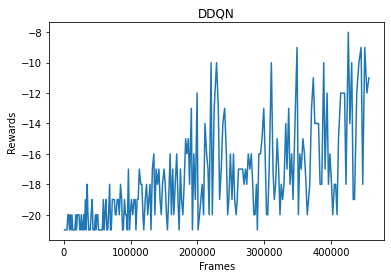

Episode:  241
Steps:  114077  epsilon:  0.03323327666855158
Steps:  114277  epsilon:  0.03320110502816456
Steps:  114477  epsilon:  0.03316925350094795
Episode:  242
Steps:  114661  epsilon:  0.03314023008118172
Steps:  114861  epsilon:  0.033108984269808094
Steps:  115061  epsilon:  0.033078049359452286
Episode:  243
Steps:  115221  epsilon:  0.03305352320002044
Steps:  115421  epsilon:  0.03302314013652946
Steps:  115621  epsilon:  0.032993059389571436
Episode:  244
Steps:  115732  epsilon:  0.03297649392165424
Steps:  115932  epsilon:  0.032946877312289194
Steps:  116132  epsilon:  0.032917555393111114
Episode:  245
Steps:  116209  epsilon:  0.032906344399857554
Steps:  116409  epsilon:  0.032877425789896796
Steps:  116609  epsilon:  0.03284879492491289
Steps:  116809  epsilon:  0.032820448941795484
Episode:  246
Steps:  116913  epsilon:  0.032805820673757397
Steps:  117113  epsilon:  0.03277790229158349
Steps:  117313  epsilon:  0.032750261701953665
Steps:  117513  epsilon:  0.0327

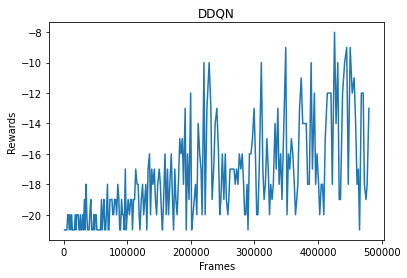

Episode:  251
Steps:  119882  epsilon:  0.03241873837479338
Steps:  120082  epsilon:  0.032394671525846915
Steps:  120282  epsilon:  0.03237084414604861
Steps:  120482  epsilon:  0.03234725385264061
Episode:  252
Steps:  120586  epsilon:  0.032335079812543285
Steps:  120786  epsilon:  0.03231184538019952
Steps:  120986  epsilon:  0.03228884213432032
Steps:  121186  epsilon:  0.032266067774561924
Episode:  253
Steps:  121230  epsilon:  0.032261087905322595
Steps:  121430  epsilon:  0.03223858970475689
Steps:  121630  epsilon:  0.03221631536502716
Steps:  121830  epsilon:  0.03219426265868087
Steps:  122030  epsilon:  0.032172429380428996
Episode:  254
Steps:  122037  epsilon:  0.03217166916319163
Steps:  122237  epsilon:  0.032150060693976065
Steps:  122437  epsilon:  0.03212866723262162
Episode:  255
Steps:  122565  epsilon:  0.032115087264583494
Steps:  122765  epsilon:  0.032094041794665865
Steps:  122965  epsilon:  0.03207320573067275
Steps:  123165  epsilon:  0.03205257698898038
St

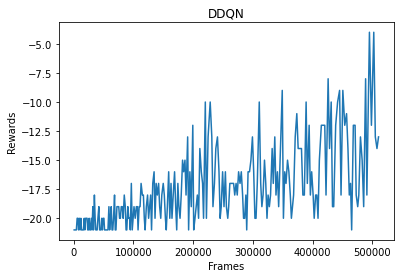

Episode:  261
Steps:  127440  epsilon:  0.031657559055157415
Steps:  127640  epsilon:  0.03164106606698803
Steps:  127840  epsilon:  0.0316247371867929
Steps:  128040  epsilon:  0.0316085707816704
Steps:  128240  epsilon:  0.03159256523496655
Episode:  262
Steps:  128292  epsilon:  0.031588429943564006
Steps:  128492  epsilon:  0.031572624801547745
Steps:  128692  epsilon:  0.03155697692332216
Steps:  128892  epsilon:  0.0315414847440864
Steps:  129092  epsilon:  0.03152614671460961
Episode:  263
Steps:  129147  epsilon:  0.031521955576600494
Steps:  129347  epsilon:  0.03150681186558694
Steps:  129547  epsilon:  0.03149181883701562
Steps:  129747  epsilon:  0.03147697499157119
Episode:  264
Steps:  129819  epsilon:  0.031471667440924854
Steps:  130019  epsilon:  0.03145702410522171
Steps:  130219  epsilon:  0.03144252647314329
Steps:  130419  epsilon:  0.03142817309491429
Steps:  130619  epsilon:  0.03141396253518492
Steps:  130819  epsilon:  0.031399893372887386
Episode:  265
Steps: 

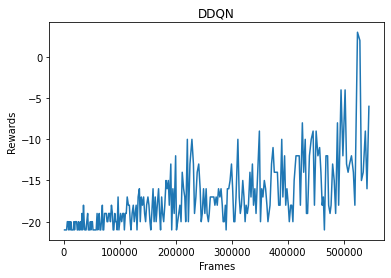

Episode:  271
Steps:  136081  epsilon:  0.031076049077218622
Steps:  136281  epsilon:  0.03106534221000624
Steps:  136481  epsilon:  0.03105474187790265
Steps:  136681  epsilon:  0.031044247020865806
Episode:  272
Steps:  136780  epsilon:  0.031039090770360933
Steps:  136980  epsilon:  0.031028751644446136
Steps:  137180  epsilon:  0.03101851539455308
Steps:  137380  epsilon:  0.031008380997048248
Steps:  137580  epsilon:  0.030998347438483436
Episode:  273
Steps:  137588  epsilon:  0.03099794817936519
Steps:  137788  epsilon:  0.030988018429070792
Steps:  137988  epsilon:  0.03097818748144265
Steps:  138188  epsilon:  0.030968454353377816
Episode:  274
Steps:  138297  epsilon:  0.030963190633816508
Steps:  138497  epsilon:  0.030953606726878788
Steps:  138697  epsilon:  0.030944118181408433
Steps:  138897  epsilon:  0.030934724048542986
Steps:  139097  epsilon:  0.030925423388861333
Episode:  275
Steps:  139293  epsilon:  0.030916398533669738
Steps:  139493  epsilon:  0.03090728021590

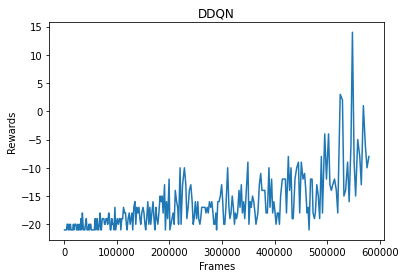

Episode:  281
Steps:  144599  epsilon:  0.030702855519293124
Steps:  144799  epsilon:  0.03069586199002584
Steps:  144999  epsilon:  0.03068893804753745
Steps:  145199  epsilon:  0.03068208299942793
Steps:  145399  epsilon:  0.030675296160186754
Steps:  145599  epsilon:  0.030668576851124348
Episode:  282
Steps:  145695  epsilon:  0.03066537537193584
Steps:  145895  epsilon:  0.03065875477636587
Steps:  146095  epsilon:  0.0306522000568225
Steps:  146295  epsilon:  0.030645710557828314
Steps:  146495  epsilon:  0.030639285630428004
Episode:  283
Steps:  146567  epsilon:  0.030636988339762736
Steps:  146767  epsilon:  0.030630650199882255
Steps:  146967  epsilon:  0.030624375125547304
Steps:  147167  epsilon:  0.030618162489245225
Episode:  284
Steps:  147288  epsilon:  0.03061443389655117
Steps:  147488  epsilon:  0.03060832017713034
Steps:  147688  epsilon:  0.030602267290234155
Steps:  147888  epsilon:  0.03059627463056889
Steps:  148088  epsilon:  0.030590341598863573
Episode:  285


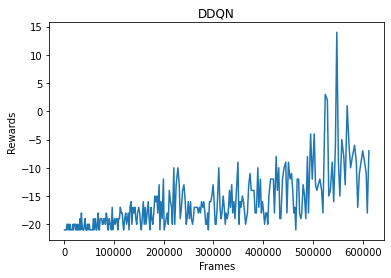

Episode:  291
Steps:  152883  epsilon:  0.030464495258513025
Steps:  153083  epsilon:  0.030459873453468095
Steps:  153283  epsilon:  0.030455297636151745
Steps:  153483  epsilon:  0.030450767348978423
Episode:  292
Steps:  153630  epsilon:  0.030447466354977037
Steps:  153830  epsilon:  0.03044301399035336
Steps:  154030  epsilon:  0.030438605927497902
Steps:  154230  epsilon:  0.030434241725600695
Steps:  154430  epsilon:  0.03042992094823792
Episode:  293
Steps:  154555  epsilon:  0.030427242321738726
Steps:  154755  epsilon:  0.030422991189608034
Steps:  154955  epsilon:  0.030418782356948795
Steps:  155155  epsilon:  0.03041461540287424
Steps:  155355  epsilon:  0.030410489910685488
Steps:  155555  epsilon:  0.030406405467829876
Episode:  294
Steps:  155607  epsilon:  0.030405350186074275
Steps:  155807  epsilon:  0.03040131688433303
Steps:  156007  epsilon:  0.030397323714614653
Steps:  156207  epsilon:  0.03039337027759884
Episode:  295
Steps:  156399  epsilon:  0.03038961199157

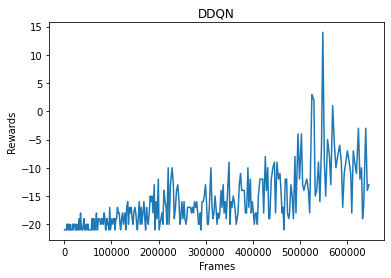

Episode:  301
Steps:  161143  epsilon:  0.030307338993110437
Steps:  161343  epsilon:  0.030304280919033626
Steps:  161543  epsilon:  0.030301253273302287
Steps:  161743  epsilon:  0.03029825575314932
Steps:  161943  epsilon:  0.03029528805882022
Episode:  302
Steps:  162121  epsilon:  0.030292671655362525
Steps:  162321  epsilon:  0.030289759523734763
Steps:  162521  epsilon:  0.03028687636830084
Steps:  162721  epsilon:  0.03028402190074281
Steps:  162921  epsilon:  0.030281195835611542
Steps:  163121  epsilon:  0.030278397890298167
Episode:  303
Steps:  163190  epsilon:  0.030277439072488387
Steps:  163390  epsilon:  0.03027467850759265
Steps:  163590  epsilon:  0.030271945410776574
Episode:  304
Steps:  163767  epsilon:  0.030269549312266122
Steps:  163967  epsilon:  0.030266867251796278
Steps:  164167  epsilon:  0.030264211878274005
Steps:  164367  epsilon:  0.03026158292615973
Episode:  305
Steps:  164500  epsilon:  0.030259849170826497
Steps:  164700  epsilon:  0.030257263628376

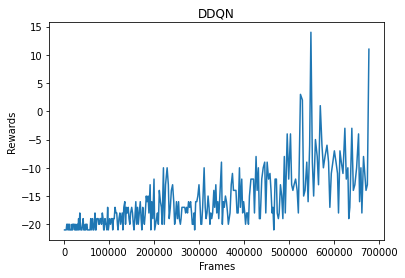

Episode:  311
Steps:  168933  epsilon:  0.030208190047090893
Steps:  169133  epsilon:  0.030206118521510568
Steps:  169333  epsilon:  0.030204067607954164
Steps:  169533  epsilon:  0.03020203710132861
Steps:  169733  epsilon:  0.030200026798581553
Episode:  312
Steps:  169919  epsilon:  0.030198175172760387
Steps:  170119  epsilon:  0.030196203296844634
Steps:  170319  epsilon:  0.03019425104142207
Steps:  170519  epsilon:  0.03019231821126552
Episode:  313
Steps:  170585  epsilon:  0.030191684607190065
Steps:  170785  epsilon:  0.0301897773134808
Steps:  170985  epsilon:  0.03018788899766103
Steps:  171185  epsilon:  0.0301860194708976
Steps:  171385  epsilon:  0.030184168546236276
Episode:  314
Steps:  171581  epsilon:  0.030182372509437734
Steps:  171781  epsilon:  0.030180557872649245
Steps:  171981  epsilon:  0.03017876129179849
Steps:  172181  epsilon:  0.03017698258722588
Steps:  172381  epsilon:  0.03017522158105948
Episode:  315
Steps:  172575  epsilon:  0.030173530148433658
S

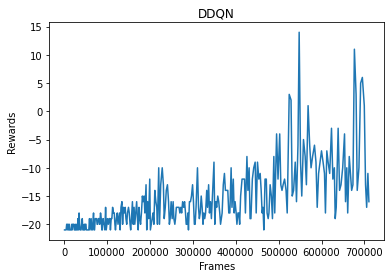

Episode:  321
Steps:  177383  epsilon:  0.03013644905895197
Steps:  177583  epsilon:  0.03013509136813063
Steps:  177783  epsilon:  0.030133747186558677
Steps:  177983  epsilon:  0.030132416379816836
Steps:  178183  epsilon:  0.030131098814823325
Steps:  178383  epsilon:  0.030129794359820546
Episode:  322
Steps:  178455  epsilon:  0.03012932794018427
Steps:  178655  epsilon:  0.03012804110567856
Steps:  178855  epsilon:  0.030126767075390117
Steps:  179055  epsilon:  0.030125505721914855
Steps:  179255  epsilon:  0.030124256919116372
Episode:  323
Steps:  179334  epsilon:  0.03012376707237009
Steps:  179534  epsilon:  0.030122535569423625
Steps:  179734  epsilon:  0.030121316320136222
Steps:  179934  epsilon:  0.030120109202581926
Episode:  324
Steps:  179966  epsilon:  0.03011991718151561
Steps:  180166  epsilon:  0.0301187239856232
Steps:  180366  epsilon:  0.03011754266222829
Steps:  180566  epsilon:  0.030116373093197552
Episode:  325
Steps:  180720  epsilon:  0.030115480461422605

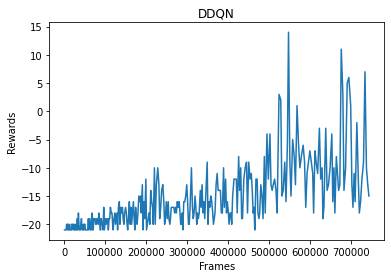

Episode:  331
Steps:  185800  epsilon:  0.030089577247222058
Steps:  186000  epsilon:  0.030088685938719908
Steps:  186200  epsilon:  0.030087803498885533
Steps:  186400  epsilon:  0.030086929839474218
Steps:  186600  epsilon:  0.03008606487311929
Episode:  332
Steps:  186745  epsilon:  0.030085443159225275
Steps:  186945  epsilon:  0.030084592985585988
Steps:  187145  epsilon:  0.030083751271315753
Steps:  187345  epsilon:  0.030082917932242444
Steps:  187545  epsilon:  0.030082092885031456
Steps:  187745  epsilon:  0.03008127604717738
Episode:  333
Steps:  187802  epsilon:  0.030081044740211917
Steps:  188002  epsilon:  0.030080238331573052
Steps:  188202  epsilon:  0.03007943994683421
Steps:  188402  epsilon:  0.030078649506156255
Episode:  334
Steps:  188550  epsilon:  0.03007806964793221
Steps:  188750  epsilon:  0.030077292841956142
Steps:  188950  epsilon:  0.03007652376532868
Episode:  335
Steps:  189090  epsilon:  0.030075989969436664
Steps:  189290  epsilon:  0.03007523385660

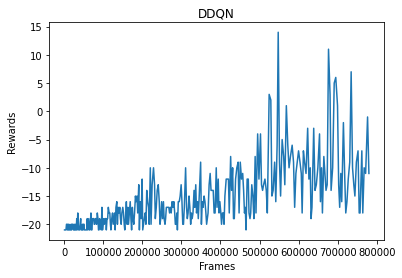

Episode:  341
Steps:  194756  epsilon:  0.03005724277024213
Steps:  194956  epsilon:  0.03005667319516156
Steps:  195156  epsilon:  0.030056109287447737
Steps:  195356  epsilon:  0.030055550990709414
Steps:  195556  epsilon:  0.03005499824911646
Episode:  342
Steps:  195690  epsilon:  0.030054630992530786
Steps:  195890  epsilon:  0.030054087405072656
Steps:  196090  epsilon:  0.030053549226400106
Steps:  196290  epsilon:  0.030053016402694824
Steps:  196490  epsilon:  0.030052488880673987
Episode:  343
Steps:  196510  epsilon:  0.03005243641802901
Steps:  196710  epsilon:  0.03005191466695202
Steps:  196910  epsilon:  0.030051398107384993
Steps:  197110  epsilon:  0.030050886687671533
Steps:  197310  epsilon:  0.030050380356669248
Episode:  344
Steps:  197398  epsilon:  0.030050159170067276
Steps:  197598  epsilon:  0.030049660077986103
Steps:  197798  epsilon:  0.030049165951954112
Episode:  345
Steps:  197870  epsilon:  0.030048989272740474
Steps:  198070  epsilon:  0.03004850182133

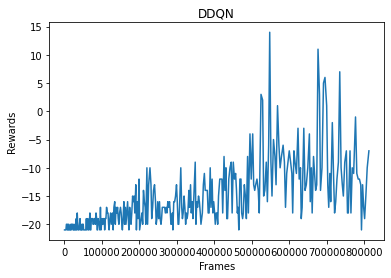

Episode:  351
Steps:  202817  epsilon:  0.030038254123197633
Steps:  203017  epsilon:  0.030037873488312036
Steps:  203217  epsilon:  0.030037496640806835
Steps:  203417  epsilon:  0.03003712354299696
Steps:  203617  epsilon:  0.03003675415757232
Episode:  352
Steps:  203759  epsilon:  0.03003649412725353
Steps:  203959  epsilon:  0.030036131004620176
Steps:  204159  epsilon:  0.030035771495117398
Steps:  204359  epsilon:  0.03003541556279394
Steps:  204559  epsilon:  0.030035063172056273
Steps:  204759  epsilon:  0.03003471428766503
Steps:  204959  epsilon:  0.030034368874731484
Episode:  353
Steps:  205005  epsilon:  0.03003428991715562
Steps:  205205  epsilon:  0.030033948726779197
Steps:  205405  epsilon:  0.030033610931303738
Steps:  205605  epsilon:  0.03003327649694942
Episode:  354
Steps:  205725  epsilon:  0.030033077435748512
Steps:  205925  epsilon:  0.03003274830976366
Steps:  206125  epsilon:  0.03003242245863708
Steps:  206325  epsilon:  0.03003209984978338
Steps:  206525

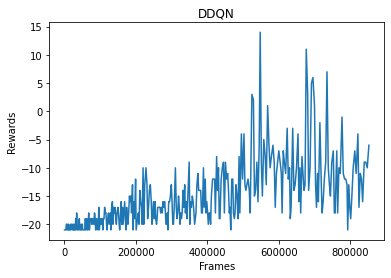

Episode:  361
Steps:  212672  epsilon:  0.030023371126506226
Steps:  212872  epsilon:  0.03002313857991202
Steps:  213072  epsilon:  0.030022908347195086
Steps:  213272  epsilon:  0.030022680405331962
Steps:  213472  epsilon:  0.030022454731528272
Steps:  213672  epsilon:  0.03002223130321645
Episode:  362
Steps:  213751  epsilon:  0.03002214366277257
Steps:  213951  epsilon:  0.030021923329646583
Steps:  214151  epsilon:  0.030021705188871827
Steps:  214351  epsilon:  0.030021489218634047
Steps:  214551  epsilon:  0.03002127539733604
Episode:  363
Steps:  214664  epsilon:  0.03002115553028438
Steps:  214864  epsilon:  0.030020945029240926
Steps:  215064  epsilon:  0.030020736622717852
Steps:  215264  epsilon:  0.030020530289874326
Episode:  364
Steps:  215404  epsilon:  0.03002038707966571
Steps:  215604  epsilon:  0.03002018422483367
Steps:  215804  epsilon:  0.03001998338844093
Steps:  216004  epsilon:  0.03001978455040369
Steps:  216204  epsilon:  0.030019587690837974
Episode:  365

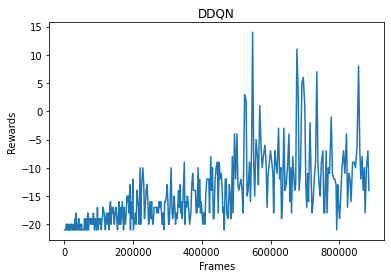

Episode:  371
Steps:  221254  epsilon:  0.030015216819322656
Steps:  221454  epsilon:  0.030015065409440586
Steps:  221654  epsilon:  0.030014915506112017
Steps:  221854  epsilon:  0.030014767094346487
Steps:  222054  epsilon:  0.030014620159302695
Steps:  222254  epsilon:  0.03001447468628702
Episode:  372
Steps:  222344  epsilon:  0.03001440969653534
Steps:  222544  epsilon:  0.03001426631765919
Steps:  222744  epsilon:  0.030014124365426692
Steps:  222944  epsilon:  0.03001398382564251
Steps:  223144  epsilon:  0.030013844684252545
Episode:  373
Steps:  223317  epsilon:  0.030013725444190516
Steps:  223517  epsilon:  0.030013588873738953
Steps:  223717  epsilon:  0.030013453662186086
Steps:  223917  epsilon:  0.030013319796010653
Episode:  374
Steps:  223935  epsilon:  0.030013307813587145
Steps:  224135  epsilon:  0.030013175398629518
Steps:  224335  epsilon:  0.03001304430122273
Steps:  224535  epsilon:  0.030012914508256938
Episode:  375
Steps:  224659  epsilon:  0.03001283468601

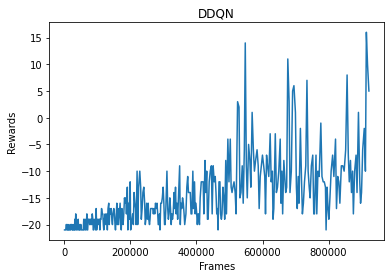

Episode:  381
Steps:  230240  epsilon:  0.03000970946662664
Steps:  230440  epsilon:  0.0300096128558195
Steps:  230640  epsilon:  0.03000951720630595
Steps:  230840  epsilon:  0.030009422508520962
Steps:  231040  epsilon:  0.03000932875299468
Steps:  231240  epsilon:  0.030009235930351468
Episode:  382
Steps:  231388  epsilon:  0.030009167836724023
Steps:  231588  epsilon:  0.030009076615224457
Steps:  231788  epsilon:  0.03000898630139398
Steps:  231988  epsilon:  0.03000889688620113
Episode:  383
Steps:  232135  epsilon:  0.030008831733815876
Steps:  232335  epsilon:  0.030008743856596125
Steps:  232535  epsilon:  0.030008656853769317
Steps:  232735  epsilon:  0.030008570716635104
Steps:  232935  epsilon:  0.030008485436579697
Episode:  384
Steps:  232966  epsilon:  0.030008472294340865
Steps:  233166  epsilon:  0.030008387993603648
Steps:  233366  epsilon:  0.030008304531672778
Steps:  233566  epsilon:  0.030008221900202
Steps:  233766  epsilon:  0.030008140090928094
Steps:  233966

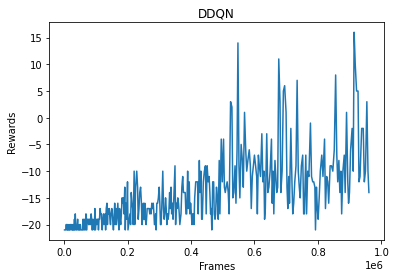

Episode:  391
Steps:  239956  epsilon:  0.03000597331082347
Steps:  240156  epsilon:  0.03000591387538771
Steps:  240356  epsilon:  0.030005855031344415
Steps:  240556  epsilon:  0.030005796772809134
Steps:  240756  epsilon:  0.030005739093955965
Episode:  392
Steps:  240836  epsilon:  0.030005716183431737
Steps:  241036  epsilon:  0.03000565930645627
Steps:  241236  epsilon:  0.030005602995416165
Steps:  241436  epsilon:  0.030005547244680273
Steps:  241636  epsilon:  0.03000549204867347
Episode:  393
Steps:  241682  epsilon:  0.03000547943147686
Steps:  241882  epsilon:  0.030005424910222706
Steps:  242082  epsilon:  0.030005370931464093
Steps:  242282  epsilon:  0.030005317489803104
Steps:  242482  epsilon:  0.030005264579895524
Episode:  394
Steps:  242604  epsilon:  0.030005232563706814
Steps:  242804  epsilon:  0.030005180498828013
Steps:  243004  epsilon:  0.030005128952003413
Steps:  243204  epsilon:  0.030005077918078285
Steps:  243404  epsilon:  0.0300050273919492
Episode:  3

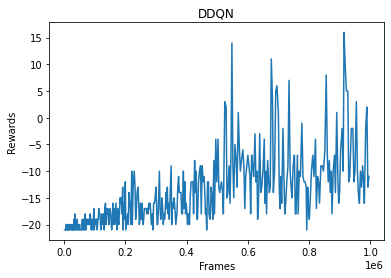

Episode:  401
Steps:  248598  epsilon:  0.0300038775416229
Steps:  248798  epsilon:  0.03000383895943911
Steps:  248998  epsilon:  0.03000380076115446
Steps:  249198  epsilon:  0.030003762942949094
Steps:  249398  epsilon:  0.03000372550104116
Episode:  402
Steps:  249425  epsilon:  0.030003720475008086
Steps:  249625  epsilon:  0.030003683455663226
Steps:  249825  epsilon:  0.030003646804666998
Steps:  250025  epsilon:  0.030003610518354276
Steps:  250225  epsilon:  0.0300035745930964
Episode:  403
Steps:  250256  epsilon:  0.03000356905676886
Steps:  250456  epsilon:  0.030003533544060653
Steps:  250656  epsilon:  0.030003498384709795
Steps:  250856  epsilon:  0.030003463575200322
Steps:  251056  epsilon:  0.03000342911205126
Episode:  404
Steps:  251077  epsilon:  0.03000342551337324
Steps:  251277  epsilon:  0.030003391428945682
Steps:  251477  epsilon:  0.030003357683663846
Steps:  251677  epsilon:  0.030003324274153174
Steps:  251877  epsilon:  0.030003291197072686
Episode:  405


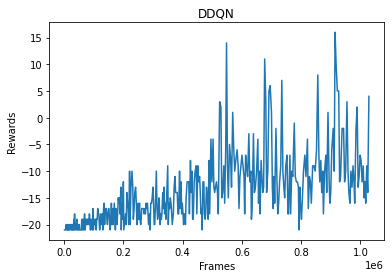

Episode:  411
Steps:  256847  epsilon:  0.030002567034522764
Steps:  257047  epsilon:  0.03000254149210249
Steps:  257247  epsilon:  0.030002516203833544
Episode:  412
Steps:  257404  epsilon:  0.03000249652895837
Steps:  257604  epsilon:  0.030002471688080186
Steps:  257804  epsilon:  0.03000244709437287
Steps:  258004  epsilon:  0.030002422745377025
Steps:  258204  epsilon:  0.03000239863865774
Episode:  413
Steps:  258291  epsilon:  0.030002388227240828
Steps:  258491  epsilon:  0.030002364463982738
Steps:  258691  epsilon:  0.030002340937173015
Episode:  414
Steps:  258873  epsilon:  0.030002319731277902
Steps:  259073  epsilon:  0.03000229664956603
Steps:  259273  epsilon:  0.030002273797521028
Steps:  259473  epsilon:  0.030002251172857673
Steps:  259673  epsilon:  0.030002228773313478
Episode:  415
Steps:  259834  epsilon:  0.03000221090370996
Steps:  260034  epsilon:  0.030002188904850482
Steps:  260234  epsilon:  0.030002167124883312
Steps:  260434  epsilon:  0.030002145561630

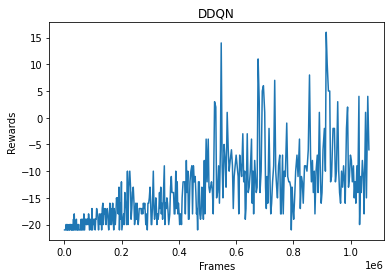

Episode:  421
Steps:  265538  epsilon:  0.030001662298611845
Steps:  265738  epsilon:  0.0300016457584643
Steps:  265938  epsilon:  0.030001629382893972
Steps:  266138  epsilon:  0.03000161317026329
Episode:  422
Steps:  266214  epsilon:  0.03000160705184864
Steps:  266414  epsilon:  0.03000159106141557
Steps:  266614  epsilon:  0.03000157523008997
Steps:  266814  epsilon:  0.030001559556288693
Steps:  267014  epsilon:  0.030001544038444343
Episode:  423
Steps:  267086  epsilon:  0.030001538489899317
Steps:  267286  epsilon:  0.030001523181669043
Steps:  267486  epsilon:  0.030001508025758208
Steps:  267686  epsilon:  0.030001493020651204
Steps:  267886  epsilon:  0.030001478164847505
Steps:  268086  epsilon:  0.030001463456861527
Episode:  424
Steps:  268243  epsilon:  0.030001452013698342
Steps:  268443  epsilon:  0.030001437565920646
Steps:  268643  epsilon:  0.03000142326190074
Steps:  268843  epsilon:  0.03000140910020821
Steps:  269043  epsilon:  0.03000139507942687
Episode:  425

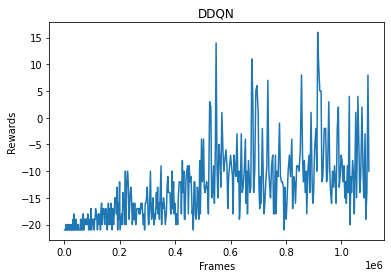

Episode:  431
Steps:  274484  epsilon:  0.03000106279406489
Steps:  274684  epsilon:  0.030001052219087252
Steps:  274884  epsilon:  0.030001041749332404
Steps:  275084  epsilon:  0.030001031383753353
Steps:  275284  epsilon:  0.03000102112131354
Episode:  432
Steps:  275296  epsilon:  0.030001020508824517
Steps:  275496  epsilon:  0.03000101035459205
Steps:  275696  epsilon:  0.03000100030139589
Steps:  275896  epsilon:  0.0300009903482307
Steps:  276096  epsilon:  0.030000980494101156
Episode:  433
Steps:  276114  epsilon:  0.030000979612053447
Steps:  276314  epsilon:  0.030000969864750655
Steps:  276514  epsilon:  0.030000960214435143
Steps:  276714  epsilon:  0.030000950660141877
Episode:  434
Steps:  276812  epsilon:  0.03000094601330124
Steps:  277012  epsilon:  0.03000093660031162
Steps:  277212  epsilon:  0.030000927280982807
Steps:  277412  epsilon:  0.030000918054382864
Episode:  435
Steps:  277567  epsilon:  0.030000910966960635
Steps:  277767  epsilon:  0.03000090190268792

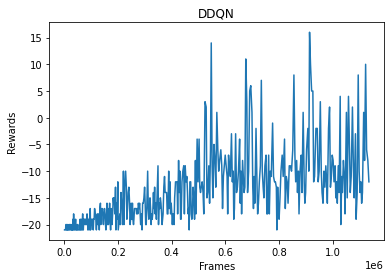

Episode:  441
Steps:  283577  epsilon:  0.03000067452357676
Steps:  283777  epsilon:  0.03000066781195503
Steps:  283977  epsilon:  0.030000661167115052
Steps:  284177  epsilon:  0.03000065458839234
Episode:  442
Steps:  284253  epsilon:  0.030000652105676595
Steps:  284453  epsilon:  0.0300006456171167
Steps:  284653  epsilon:  0.030000639193119055
Steps:  284853  epsilon:  0.030000632833041253
Steps:  285053  epsilon:  0.030000626536247285
Episode:  443
Steps:  285063  epsilon:  0.030000626223057464
Steps:  285263  epsilon:  0.030000619992033933
Steps:  285463  epsilon:  0.03000061382301012
Steps:  285663  epsilon:  0.03000060771536912
Episode:  444
Steps:  285863  epsilon:  0.030000601668500167
Steps:  286063  epsilon:  0.03000059568179856
Steps:  286263  epsilon:  0.030000589754665633
Steps:  286463  epsilon:  0.030000583886508662
Steps:  286663  epsilon:  0.03000057807674083
Steps:  286863  epsilon:  0.030000572324781153
Episode:  445
Steps:  286904  epsilon:  0.030000571152717127

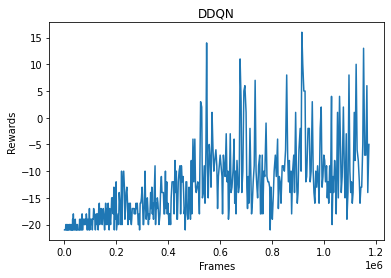

Episode:  451
Steps:  292786  epsilon:  0.03000042562412856
Steps:  292986  epsilon:  0.03000042138909772
Steps:  293186  epsilon:  0.03000041719620614
Steps:  293386  epsilon:  0.03000041304503453
Steps:  293586  epsilon:  0.030000408935167765
Steps:  293786  epsilon:  0.03000040486619486
Episode:  452
Steps:  293798  epsilon:  0.030000404623348007
Steps:  293998  epsilon:  0.030000400597278425
Steps:  294198  epsilon:  0.030000396611268906
Episode:  453
Steps:  294390  epsilon:  0.03000039282201823
Steps:  294590  epsilon:  0.030000388913373838
Steps:  294790  epsilon:  0.03000038504362111
Steps:  294990  epsilon:  0.030000381212373067
Steps:  295190  epsilon:  0.03000037741924658
Steps:  295390  epsilon:  0.03000037366386233
Episode:  454
Steps:  295484  epsilon:  0.030000371911762837
Steps:  295684  epsilon:  0.030000368211178966
Steps:  295884  epsilon:  0.03000036454741652
Steps:  296084  epsilon:  0.030000360920109118
Steps:  296284  epsilon:  0.03000035732889403
Steps:  296484 

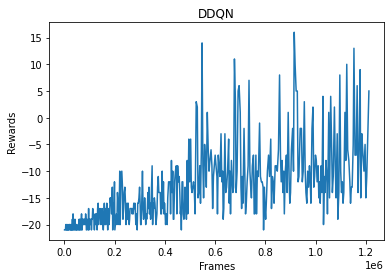

Episode:  461
Steps:  302507  epsilon:  0.030000261780568874
Steps:  302707  epsilon:  0.030000259175808692
Steps:  302907  epsilon:  0.030000256596966306
Steps:  303107  epsilon:  0.03000025404378383
Episode:  462
Steps:  303274  epsilon:  0.030000251931349923
Steps:  303474  epsilon:  0.03000024942459111
Steps:  303674  epsilon:  0.03000024694277496
Steps:  303874  epsilon:  0.030000244485653294
Episode:  463
Steps:  303979  epsilon:  0.030000243205467042
Steps:  304179  epsilon:  0.030000240785532213
Steps:  304379  epsilon:  0.030000238389676137
Steps:  304579  epsilon:  0.030000236017659228
Steps:  304779  epsilon:  0.03000023366924428
Steps:  304979  epsilon:  0.03000023134419645
Episode:  464
Steps:  305031  epsilon:  0.030000230743482806
Steps:  305231  epsilon:  0.03000022844754679
Steps:  305431  epsilon:  0.030000226174455722
Steps:  305631  epsilon:  0.030000223923982286
Steps:  305831  epsilon:  0.030000221695901434
Episode:  465
Steps:  305918  epsilon:  0.030000220733618

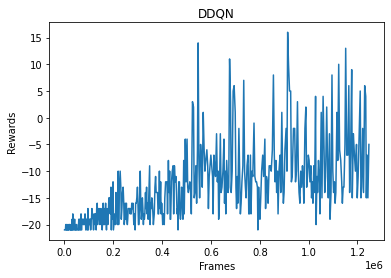

Episode:  471
Steps:  311389  epsilon:  0.030000167906391297
Steps:  311589  epsilon:  0.03000016623569479
Steps:  311789  epsilon:  0.03000016458162199
Steps:  311989  epsilon:  0.03000016294400749
Steps:  312189  epsilon:  0.030000161322687523
Episode:  472
Steps:  312234  epsilon:  0.03000016096011952
Steps:  312434  epsilon:  0.03000015935853957
Steps:  312634  epsilon:  0.030000157772895608
Steps:  312834  epsilon:  0.030000156203029066
Steps:  313034  epsilon:  0.03000015464878296
Episode:  473
Steps:  313181  epsilon:  0.030000153516281446
Steps:  313381  epsilon:  0.030000151988768924
Steps:  313581  epsilon:  0.030000150476455403
Steps:  313781  epsilon:  0.030000148979189657
Steps:  313981  epsilon:  0.03000014749682195
Episode:  474
Steps:  314064  epsilon:  0.030000146885978518
Steps:  314264  epsilon:  0.03000014542443861
Steps:  314464  epsilon:  0.03000014397744127
Steps:  314664  epsilon:  0.030000142544841794
Episode:  475
Steps:  314834  epsilon:  0.030000141338345512

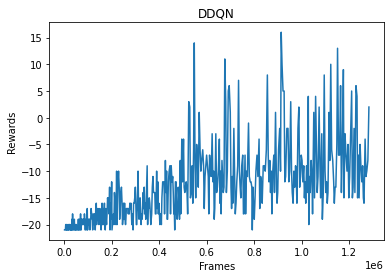

Episode:  481
Steps:  320673  epsilon:  0.03000010555230684
Steps:  320873  epsilon:  0.030000104502043837
Steps:  321073  epsilon:  0.030000103462231125
Steps:  321273  epsilon:  0.030000102432764724
Steps:  321473  epsilon:  0.030000101413541688
Episode:  482
Steps:  321625  epsilon:  0.030000100645720187
Steps:  321825  epsilon:  0.03000009964427854
Steps:  322025  epsilon:  0.030000098652801403
Steps:  322225  epsilon:  0.030000097671189628
Steps:  322425  epsilon:  0.03000009669934505
Steps:  322625  epsilon:  0.030000095737170492
Episode:  483
Steps:  322703  epsilon:  0.030000095364522663
Steps:  322903  epsilon:  0.03000009441562981
Steps:  323103  epsilon:  0.030000093476178595
Steps:  323303  epsilon:  0.030000092546075077
Episode:  484
Steps:  323323  epsilon:  0.03000009245357526
Steps:  323523  epsilon:  0.030000091533646817
Steps:  323723  epsilon:  0.030000090622871813
Steps:  323923  epsilon:  0.03000008972115917
Steps:  324123  epsilon:  0.03000008882841872
Episode:  4

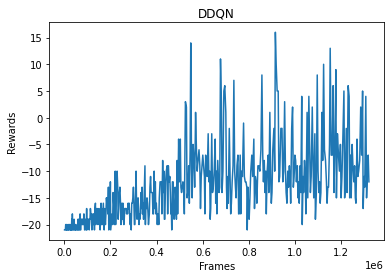

Episode:  491
Steps:  329538  epsilon:  0.030000067758955088
Steps:  329738  epsilon:  0.03000006708474222
Steps:  329938  epsilon:  0.030000066417237882
Steps:  330138  epsilon:  0.030000065756375323
Episode:  492
Steps:  330259  epsilon:  0.030000065359750253
Steps:  330459  epsilon:  0.03000006470940987
Steps:  330659  epsilon:  0.030000064065540486
Steps:  330859  epsilon:  0.030000063428077706
Steps:  331059  epsilon:  0.03000006279695779
Steps:  331259  epsilon:  0.03000006217211762
Episode:  493
Steps:  331307  epsilon:  0.03000006202308345
Steps:  331507  epsilon:  0.030000061405943457
Steps:  331707  epsilon:  0.030000060794944113
Steps:  331907  epsilon:  0.03000006019002431
Steps:  332107  epsilon:  0.030000059591123562
Steps:  332307  epsilon:  0.030000058998181974
Episode:  494
Steps:  332402  epsilon:  0.03000005871860513
Steps:  332602  epsilon:  0.030000058134345246
Steps:  332802  epsilon:  0.030000057555898848
Steps:  333002  epsilon:  0.030000056983208085
Steps:  333

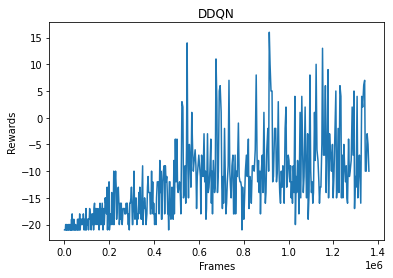

Episode:  501
Steps:  339333  epsilon:  0.030000041521303356
Steps:  339533  epsilon:  0.030000041108159486
Steps:  339733  epsilon:  0.030000040699126464
Steps:  339933  epsilon:  0.03000004029416339
Steps:  340133  epsilon:  0.030000039893229767
Episode:  502
Steps:  340239  epsilon:  0.03000003968235496
Steps:  340439  epsilon:  0.03000003928750893
Steps:  340639  epsilon:  0.030000038896591686
Steps:  340839  epsilon:  0.03000003850956413
Steps:  341039  epsilon:  0.030000038126387567
Episode:  503
Steps:  341104  epsilon:  0.030000038002677944
Steps:  341304  epsilon:  0.03000003762454498
Steps:  341504  epsilon:  0.030000037250174503
Steps:  341704  epsilon:  0.030000036879529072
Steps:  341904  epsilon:  0.030000036512571628
Steps:  342104  epsilon:  0.03000003614926547
Episode:  504
Steps:  342157  epsilon:  0.030000036053596732
Steps:  342357  epsilon:  0.03000003569485745
Steps:  342557  epsilon:  0.030000035339687686
Steps:  342757  epsilon:  0.030000034988051916
Steps:  342

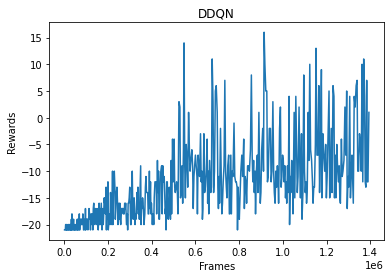

Episode:  511
Steps:  348100  epsilon:  0.030000026785391067
Steps:  348300  epsilon:  0.030000026518871972
Steps:  348500  epsilon:  0.030000026255004787
Steps:  348700  epsilon:  0.030000025993763123
Episode:  512
Steps:  348856  epsilon:  0.03000002579180045
Steps:  349056  epsilon:  0.030000025535167747
Steps:  349256  epsilon:  0.030000025281088583
Steps:  349456  epsilon:  0.03000002502953755
Steps:  349656  epsilon:  0.03000002478048949
Episode:  513
Steps:  349763  epsilon:  0.03000002464826788
Steps:  349963  epsilon:  0.030000024403013515
Steps:  350163  epsilon:  0.030000024160199475
Steps:  350363  epsilon:  0.030000023919801472
Steps:  350563  epsilon:  0.03000002368179547
Steps:  350763  epsilon:  0.03000002344615767
Episode:  514
Steps:  350774  epsilon:  0.030000023433265827
Steps:  350974  epsilon:  0.030000023200100936
Steps:  351174  epsilon:  0.030000022969256076
Steps:  351374  epsilon:  0.03000002274070816
Steps:  351574  epsilon:  0.030000022514434333
Episode:  5

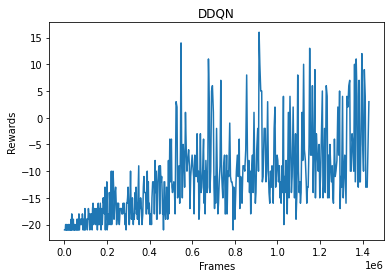

Episode:  521
Steps:  357091  epsilon:  0.03000001708680673
Steps:  357291  epsilon:  0.030000016916790162
Steps:  357491  epsilon:  0.030000016748465287
Steps:  357691  epsilon:  0.030000016581815274
Episode:  522
Steps:  357774  epsilon:  0.03000001651314333
Steps:  357974  epsilon:  0.03000001634883481
Steps:  358174  epsilon:  0.030000016186161185
Steps:  358374  epsilon:  0.030000016025106192
Steps:  358574  epsilon:  0.03000001586565372
Steps:  358774  epsilon:  0.03000001570778783
Episode:  523
Steps:  358872  epsilon:  0.03000001563100793
Steps:  359072  epsilon:  0.030000015475476805
Steps:  359272  epsilon:  0.030000015321493236
Steps:  359472  epsilon:  0.030000015169041834
Steps:  359672  epsilon:  0.030000015018107343
Episode:  524
Steps:  359870  epsilon:  0.030000014870161622
Steps:  360070  epsilon:  0.03000001472220104
Steps:  360270  epsilon:  0.030000014575712695
Steps:  360470  epsilon:  0.03000001443068193
Steps:  360670  epsilon:  0.030000014287094246
Steps:  3608

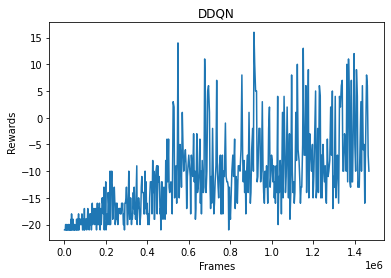

Episode:  531
Steps:  366714  epsilon:  0.030000010560880225
Steps:  366914  epsilon:  0.03000001045579771
Steps:  367114  epsilon:  0.030000010351760784
Steps:  367314  epsilon:  0.030000010248759045
Episode:  532
Steps:  367423  epsilon:  0.03000001019305524
Steps:  367623  epsilon:  0.030000010091632643
Steps:  367823  epsilon:  0.030000009991219222
Steps:  368023  epsilon:  0.03000000989180493
Steps:  368223  epsilon:  0.030000009793379825
Episode:  533
Steps:  368379  epsilon:  0.030000009717288605
Steps:  368579  epsilon:  0.03000000962059997
Steps:  368779  epsilon:  0.0300000095248734
Steps:  368979  epsilon:  0.030000009430099325
Steps:  369179  epsilon:  0.030000009336268268
Episode:  534
Steps:  369196  epsilon:  0.03000000932833581
Steps:  369396  epsilon:  0.03000000923551732
Steps:  369596  epsilon:  0.030000009143622386
Steps:  369796  epsilon:  0.030000009052641823
Steps:  369996  epsilon:  0.03000000896256653
Episode:  535
Steps:  370181  epsilon:  0.030000008880045042

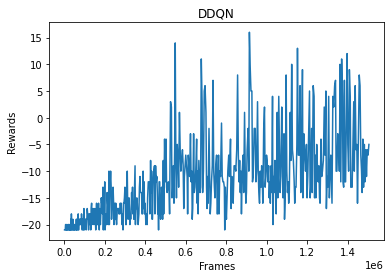

Episode:  541
Steps:  375808  epsilon:  0.030000006702339398
Steps:  376008  epsilon:  0.030000006635650008
Steps:  376208  epsilon:  0.030000006569624187
Steps:  376408  epsilon:  0.03000000650425533
Steps:  376608  epsilon:  0.03000000643953691
Episode:  542
Steps:  376657  epsilon:  0.030000006423779358
Steps:  376857  epsilon:  0.030000006359861685
Steps:  377057  epsilon:  0.030000006296580003
Steps:  377257  epsilon:  0.030000006233927984
Steps:  377457  epsilon:  0.030000006171899365
Episode:  543
Steps:  377655  epsilon:  0.030000006111099018
Steps:  377855  epsilon:  0.030000006050292568
Steps:  378055  epsilon:  0.03000000599009115
Steps:  378255  epsilon:  0.03000000593048875
Steps:  378455  epsilon:  0.0300000058714794
Episode:  544
Steps:  378548  epsilon:  0.0300000058442404
Steps:  378748  epsilon:  0.030000005786089235
Steps:  378948  epsilon:  0.030000005728516688
Steps:  379148  epsilon:  0.030000005671516995
Steps:  379348  epsilon:  0.030000005615084455
Steps:  3795

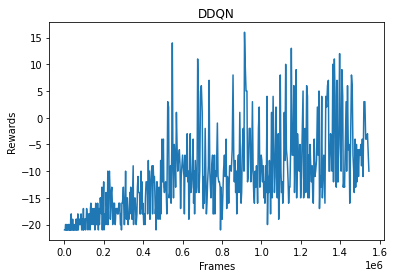

Episode:  551
Steps:  385988  epsilon:  0.030000004028751914
Steps:  386188  epsilon:  0.03000000398866516
Steps:  386388  epsilon:  0.03000000394897728
Steps:  386588  epsilon:  0.0300000039096843
Steps:  386788  epsilon:  0.03000000387078229
Episode:  552
Steps:  386864  epsilon:  0.030000003856101232
Steps:  387064  epsilon:  0.030000003817732383
Steps:  387264  epsilon:  0.03000000377974531
Steps:  387464  epsilon:  0.030000003742136218
Steps:  387664  epsilon:  0.03000000370490134
Episode:  553
Steps:  387807  epsilon:  0.03000000367850577
Steps:  388007  epsilon:  0.030000003641904027
Steps:  388207  epsilon:  0.030000003605666476
Steps:  388407  epsilon:  0.030000003569789494
Episode:  554
Steps:  388470  epsilon:  0.03000000355856235
Steps:  388670  epsilon:  0.030000003523154063
Steps:  388870  epsilon:  0.030000003488098094
Steps:  389070  epsilon:  0.03000000345339094
Steps:  389270  epsilon:  0.030000003419029125
Episode:  555
Steps:  389314  epsilon:  0.030000003411515527


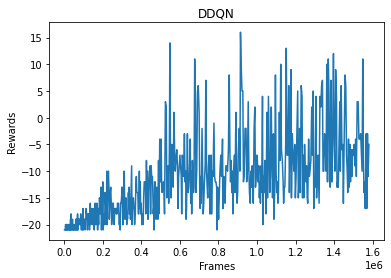

Episode:  561
Steps:  394838  epsilon:  0.03000000258818441
Steps:  395038  epsilon:  0.030000002562431544
Steps:  395238  epsilon:  0.03000000253693492
Steps:  395438  epsilon:  0.030000002511692
Steps:  395638  epsilon:  0.030000002486700244
Steps:  395838  epsilon:  0.030000002461957165
Episode:  562
Steps:  395859  epsilon:  0.030000002459373468
Steps:  396059  epsilon:  0.030000002434902293
Steps:  396259  epsilon:  0.03000000241067461
Steps:  396459  epsilon:  0.030000002386687995
Episode:  563
Steps:  396631  epsilon:  0.030000002366250486
Steps:  396831  epsilon:  0.0300000023427059
Steps:  397031  epsilon:  0.030000002319395588
Steps:  397231  epsilon:  0.030000002296317215
Steps:  397431  epsilon:  0.03000000227346848
Episode:  564
Steps:  397485  epsilon:  0.030000002267338392
Steps:  397685  epsilon:  0.030000002244777998
Steps:  397885  epsilon:  0.030000002222442083
Steps:  398085  epsilon:  0.030000002200328415
Steps:  398285  epsilon:  0.030000002178434782
Episode:  565

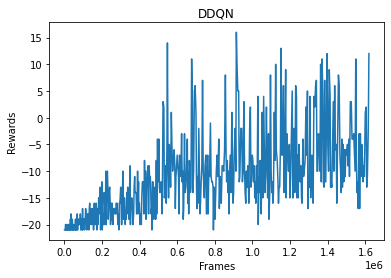

Episode:  571
Steps:  404332  epsilon:  0.030000001610036145
Steps:  404532  epsilon:  0.03000000159401602
Steps:  404732  epsilon:  0.030000001578155293
Steps:  404932  epsilon:  0.030000001562452385
Episode:  572
Steps:  405089  epsilon:  0.03000000155023515
Steps:  405289  epsilon:  0.030000001534810052
Steps:  405489  epsilon:  0.03000000151953844
Steps:  405689  epsilon:  0.030000001504418776
Episode:  573
Steps:  405756  epsilon:  0.030000001499387405
Steps:  405956  epsilon:  0.030000001484468252
Steps:  406156  epsilon:  0.030000001469697547
Steps:  406356  epsilon:  0.03000000145507381
Steps:  406556  epsilon:  0.030000001440595586
Episode:  574
Steps:  406637  epsilon:  0.030000001434772973
Steps:  406837  epsilon:  0.030000001420496743
Steps:  407037  epsilon:  0.030000001406362563
Steps:  407237  epsilon:  0.03000000139236902
Steps:  407437  epsilon:  0.030000001378514718
Episode:  575
Steps:  407456  epsilon:  0.03000000137720575
Steps:  407656  epsilon:  0.030000001363502

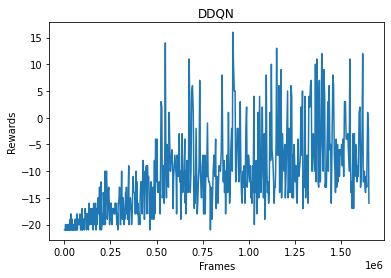

Episode:  581
Steps:  412745  epsilon:  0.030000001057181737
Steps:  412945  epsilon:  0.030000001046662603
Steps:  413145  epsilon:  0.030000001036248135
Steps:  413345  epsilon:  0.030000001025937296
Steps:  413545  epsilon:  0.03000000101572905
Steps:  413745  epsilon:  0.030000001005622376
Episode:  582
Steps:  413859  epsilon:  0.030000000999906632
Steps:  414059  epsilon:  0.030000000989957396
Steps:  414259  epsilon:  0.030000000980107154
Steps:  414459  epsilon:  0.030000000970354927
Steps:  414659  epsilon:  0.030000000960699734
Steps:  414859  epsilon:  0.03000000095114061
Episode:  583
Steps:  414962  epsilon:  0.030000000946254827
Steps:  415162  epsilon:  0.030000000936839435
Steps:  415362  epsilon:  0.030000000927517728
Steps:  415562  epsilon:  0.03000000091828877
Steps:  415762  epsilon:  0.030000000909151645
Steps:  415962  epsilon:  0.030000000900105437
Episode:  584
Steps:  416072  epsilon:  0.030000000895168445
Steps:  416272  epsilon:  0.03000000088626137
Steps:  

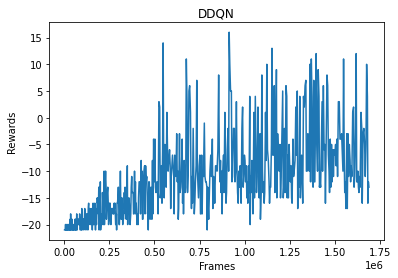

Episode:  591
Steps:  421978  epsilon:  0.03000000066628127
Steps:  422178  epsilon:  0.03000000065965166
Steps:  422378  epsilon:  0.030000000653088017
Steps:  422578  epsilon:  0.03000000064658968
Steps:  422778  epsilon:  0.030000000640156007
Episode:  592
Steps:  422844  epsilon:  0.030000000638046972
Steps:  423044  epsilon:  0.0300000006316983
Steps:  423244  epsilon:  0.030000000625412797
Steps:  423444  epsilon:  0.030000000619189837
Episode:  593
Steps:  423610  epsilon:  0.03000000061407183
Steps:  423810  epsilon:  0.03000000060796171
Steps:  424010  epsilon:  0.03000000060191239
Steps:  424210  epsilon:  0.030000000595923264
Steps:  424410  epsilon:  0.03000000058999373
Episode:  594
Steps:  424426  epsilon:  0.030000000589521923
Steps:  424626  epsilon:  0.03000000058365608
Steps:  424826  epsilon:  0.030000000577848605
Steps:  425026  epsilon:  0.030000000572098916
Steps:  425226  epsilon:  0.030000000566406438
Steps:  425426  epsilon:  0.0300000005607706
Episode:  595
St

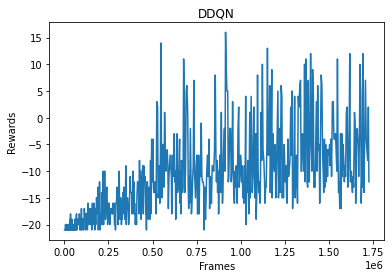

Episode:  601
Steps:  431451  epsilon:  0.030000000414910116
Steps:  431651  epsilon:  0.03000000041078169
Steps:  431851  epsilon:  0.030000000406694344
Steps:  432051  epsilon:  0.030000000402647668
Steps:  432251  epsilon:  0.030000000398641258
Episode:  602
Steps:  432404  epsilon:  0.030000000395603285
Steps:  432604  epsilon:  0.03000000039166697
Steps:  432804  epsilon:  0.030000000387769815
Episode:  603
Steps:  432888  epsilon:  0.030000000386144598
Steps:  433088  epsilon:  0.030000000382302393
Steps:  433288  epsilon:  0.030000000378498422
Steps:  433488  epsilon:  0.0300000003747323
Steps:  433688  epsilon:  0.03000000037100365
Steps:  433888  epsilon:  0.030000000367312103
Episode:  604
Steps:  433898  epsilon:  0.030000000367128493
Steps:  434098  epsilon:  0.030000000363475506
Steps:  434298  epsilon:  0.030000000359858864
Steps:  434498  epsilon:  0.030000000356278207
Steps:  434698  epsilon:  0.03000000035273318
Steps:  434898  epsilon:  0.030000000349223427
Episode:  

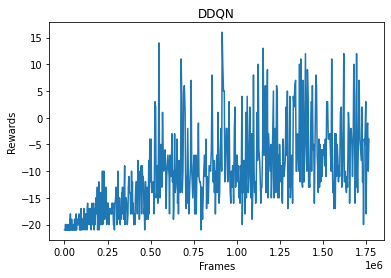

Episode:  611
Steps:  440699  epsilon:  0.0300000002612981
Steps:  440899  epsilon:  0.03000000025869814
Steps:  441099  epsilon:  0.03000000025612405
Episode:  612
Steps:  441250  epsilon:  0.030000000254197596
Steps:  441450  epsilon:  0.03000000025166829
Steps:  441650  epsilon:  0.030000000249164147
Steps:  441850  epsilon:  0.03000000024668492
Steps:  442050  epsilon:  0.030000000244230367
Episode:  613
Steps:  442073  epsilon:  0.03000000024394966
Steps:  442273  epsilon:  0.030000000241522322
Steps:  442473  epsilon:  0.030000000239119137
Steps:  442673  epsilon:  0.03000000023673986
Episode:  614
Steps:  442795  epsilon:  0.030000000235300143
Steps:  442995  epsilon:  0.030000000232958866
Steps:  443195  epsilon:  0.030000000230640887
Steps:  443395  epsilon:  0.030000000228345973
Episode:  615
Steps:  443537  epsilon:  0.03000000022673046
Steps:  443737  epsilon:  0.030000000224474452
Steps:  443937  epsilon:  0.030000000222240895
Steps:  444137  epsilon:  0.03000000022002956


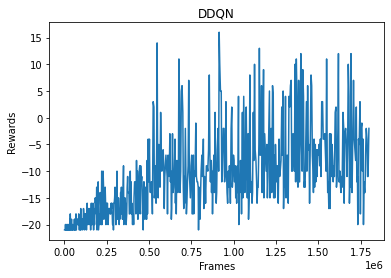

Episode:  621
Steps:  449281  epsilon:  0.03000000017012984
Steps:  449481  epsilon:  0.030000000168437017
Steps:  449681  epsilon:  0.03000000016676104
Steps:  449881  epsilon:  0.030000000165101744
Episode:  622
Steps:  450020  epsilon:  0.030000000163958263
Steps:  450220  epsilon:  0.030000000162326852
Steps:  450420  epsilon:  0.030000000160711672
Steps:  450620  epsilon:  0.030000000159112562
Steps:  450820  epsilon:  0.030000000157529367
Episode:  623
Steps:  450992  epsilon:  0.030000000156180425
Steps:  451192  epsilon:  0.0300000001546264
Steps:  451392  epsilon:  0.030000000153087843
Steps:  451592  epsilon:  0.030000000151564593
Episode:  624
Steps:  451688  epsilon:  0.030000000150838826
Steps:  451888  epsilon:  0.030000000149337958
Steps:  452088  epsilon:  0.030000000147852018
Steps:  452288  epsilon:  0.030000000146380868
Steps:  452488  epsilon:  0.030000000144924353
Episode:  625
Steps:  452647  epsilon:  0.03000000014377677
Steps:  452847  epsilon:  0.03000000014234

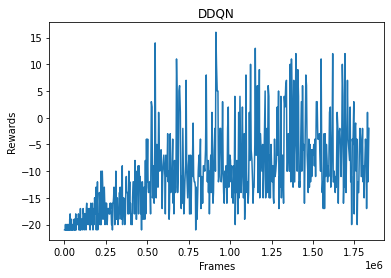

Episode:  631
Steps:  458896  epsilon:  0.03000000010519459
Steps:  459096  epsilon:  0.03000000010414789
Steps:  459296  epsilon:  0.0300000001031116
Steps:  459496  epsilon:  0.030000000102085624
Steps:  459696  epsilon:  0.030000000101069853
Steps:  459896  epsilon:  0.030000000100064192
Episode:  632
Steps:  459999  epsilon:  0.030000000099550186
Steps:  460199  epsilon:  0.030000000098559645
Steps:  460399  epsilon:  0.03000000009757896
Steps:  460599  epsilon:  0.030000000096608033
Episode:  633
Steps:  460776  epsilon:  0.030000000095756825
Steps:  460976  epsilon:  0.030000000094804028
Steps:  461176  epsilon:  0.030000000093860713
Steps:  461376  epsilon:  0.030000000092926783
Steps:  461576  epsilon:  0.030000000092002144
Steps:  461776  epsilon:  0.03000000009108671
Episode:  634
Steps:  461966  epsilon:  0.030000000090225482
Steps:  462166  epsilon:  0.030000000089327725
Steps:  462366  epsilon:  0.030000000088438897
Steps:  462566  epsilon:  0.030000000087558917
Steps:  46

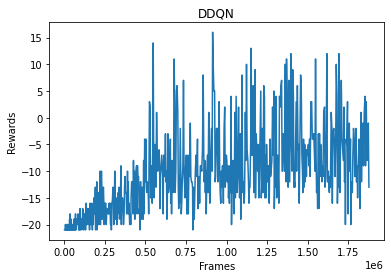

Episode:  641
Steps:  469091  epsilon:  0.030000000063184682
Steps:  469291  epsilon:  0.030000000062555984
Steps:  469491  epsilon:  0.03000000006193354
Steps:  469691  epsilon:  0.03000000006131729
Steps:  469891  epsilon:  0.030000000060707174
Steps:  470091  epsilon:  0.03000000006010313
Episode:  642
Steps:  470205  epsilon:  0.030000000059761514
Steps:  470405  epsilon:  0.03000000005916688
Steps:  470605  epsilon:  0.03000000005857816
Steps:  470805  epsilon:  0.030000000057995295
Episode:  643
Steps:  470909  epsilon:  0.0300000000576945
Steps:  471109  epsilon:  0.030000000057120432
Steps:  471309  epsilon:  0.030000000056552074
Steps:  471509  epsilon:  0.030000000055989372
Steps:  471709  epsilon:  0.03000000005543227
Episode:  644
Steps:  471744  epsilon:  0.030000000055335346
Steps:  471944  epsilon:  0.030000000054784752
Steps:  472144  epsilon:  0.030000000054239633
Steps:  472344  epsilon:  0.03000000005369994
Steps:  472544  epsilon:  0.030000000053165617
Steps:  47274

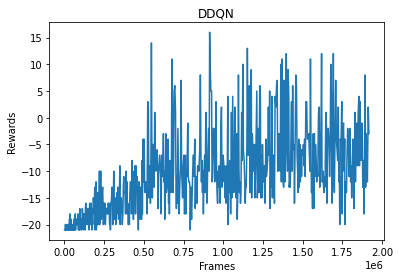

Episode:  651
Steps:  478771  epsilon:  0.030000000038941554
Steps:  478971  epsilon:  0.03000000003855408
Steps:  479171  epsilon:  0.03000000003817046
Steps:  479371  epsilon:  0.030000000037790655
Steps:  479571  epsilon:  0.030000000037414633
Steps:  479771  epsilon:  0.03000000003704235
Episode:  652
Steps:  479919  epsilon:  0.03000000003676925
Steps:  480119  epsilon:  0.03000000003640339
Steps:  480319  epsilon:  0.03000000003604117
Steps:  480519  epsilon:  0.030000000035682553
Steps:  480719  epsilon:  0.030000000035327507
Steps:  480919  epsilon:  0.030000000034975993
Episode:  653
Steps:  481074  epsilon:  0.030000000034705977
Steps:  481274  epsilon:  0.030000000034360645
Steps:  481474  epsilon:  0.030000000034018752
Steps:  481674  epsilon:  0.03000000003368026
Steps:  481874  epsilon:  0.030000000033345135
Episode:  654
Steps:  481913  epsilon:  0.030000000033280176
Steps:  482113  epsilon:  0.03000000003294903
Steps:  482313  epsilon:  0.030000000032621182
Steps:  4825

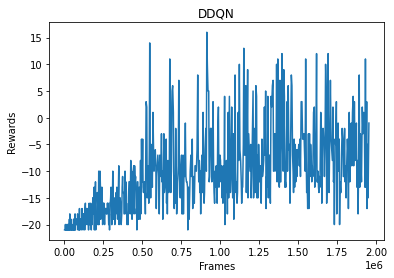

Episode:  661
Steps:  488289  epsilon:  0.030000000024195384
Steps:  488489  epsilon:  0.030000000023954636
Steps:  488689  epsilon:  0.030000000023716285
Steps:  488889  epsilon:  0.030000000023480303
Steps:  489089  epsilon:  0.03000000002324667
Episode:  662
Steps:  489126  epsilon:  0.030000000023203702
Steps:  489326  epsilon:  0.03000000002297282
Steps:  489526  epsilon:  0.03000000002274424
Steps:  489726  epsilon:  0.03000000002251793
Steps:  489926  epsilon:  0.030000000022293874
Episode:  663
Steps:  490002  epsilon:  0.030000000022209317
Steps:  490202  epsilon:  0.03000000002198833
Steps:  490402  epsilon:  0.030000000021769543
Steps:  490602  epsilon:  0.030000000021552932
Steps:  490802  epsilon:  0.030000000021338475
Steps:  491002  epsilon:  0.030000000021126155
Episode:  664
Steps:  491048  epsilon:  0.03000000002107762
Steps:  491248  epsilon:  0.030000000020867897
Steps:  491448  epsilon:  0.030000000020660257
Steps:  491648  epsilon:  0.030000000020454682
Steps:  49

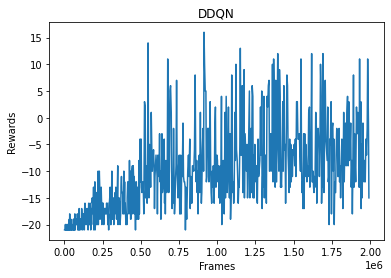

Episode:  671
Steps:  497979  epsilon:  0.03000000001490448
Steps:  498179  epsilon:  0.030000000014756178
Steps:  498379  epsilon:  0.03000000001460935
Steps:  498579  epsilon:  0.030000000014463984
Episode:  672
Steps:  498705  epsilon:  0.03000000001437315
Steps:  498905  epsilon:  0.030000000014230133
Steps:  499105  epsilon:  0.03000000001408854
Steps:  499305  epsilon:  0.03000000001394836
Steps:  499505  epsilon:  0.03000000001380957
Episode:  673
Steps:  499656  epsilon:  0.0300000000137057
Steps:  499856  epsilon:  0.030000000013569325
Steps:  500056  epsilon:  0.030000000013434308
Steps:  500256  epsilon:  0.030000000013300637
Steps:  500456  epsilon:  0.030000000013168292
Episode:  674
Steps:  500540  epsilon:  0.0300000000131131
Steps:  500740  epsilon:  0.030000000012982624
Steps:  500940  epsilon:  0.030000000012853443
Steps:  501140  epsilon:  0.030000000012725552
Episode:  675
Steps:  501318  epsilon:  0.030000000012612795
Steps:  501518  epsilon:  0.030000000012487295


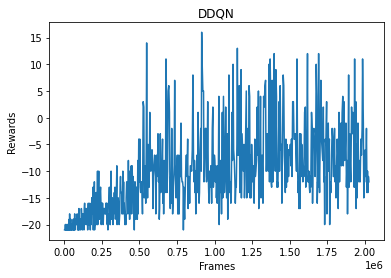

Episode:  681
Steps:  506494  epsilon:  0.030000000009736794
Steps:  506694  epsilon:  0.03000000000963991
Steps:  506894  epsilon:  0.030000000009543993
Steps:  507094  epsilon:  0.030000000009449027
Steps:  507294  epsilon:  0.03000000000935501
Episode:  682
Steps:  507368  epsilon:  0.030000000009320456
Steps:  507568  epsilon:  0.030000000009227718
Steps:  507768  epsilon:  0.0300000000091359
Steps:  507968  epsilon:  0.030000000009044996
Steps:  508168  epsilon:  0.030000000008955
Steps:  508368  epsilon:  0.030000000008865893
Episode:  683
Steps:  508563  epsilon:  0.03000000000877987
Steps:  508763  epsilon:  0.03000000000869251
Steps:  508963  epsilon:  0.030000000008606018
Steps:  509163  epsilon:  0.030000000008520388
Episode:  684
Steps:  509311  epsilon:  0.03000000000845757
Steps:  509511  epsilon:  0.030000000008373415
Steps:  509711  epsilon:  0.030000000008290097
Steps:  509911  epsilon:  0.03000000000820761
Steps:  510111  epsilon:  0.030000000008125943
Steps:  510311 

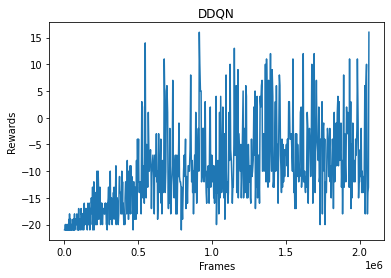

Episode:  691
Steps:  515487  epsilon:  0.030000000006210625
Steps:  515687  epsilon:  0.03000000000614883
Steps:  515887  epsilon:  0.030000000006087647
Steps:  516087  epsilon:  0.030000000006027074
Steps:  516287  epsilon:  0.030000000005967104
Episode:  692
Steps:  516429  epsilon:  0.030000000005924888
Steps:  516629  epsilon:  0.030000000005865935
Steps:  516829  epsilon:  0.03000000000580757
Steps:  517029  epsilon:  0.03000000000574978
Steps:  517229  epsilon:  0.03000000000569257
Episode:  693
Steps:  517244  epsilon:  0.030000000005688303
Steps:  517444  epsilon:  0.030000000005631702
Steps:  517644  epsilon:  0.030000000005575667
Steps:  517844  epsilon:  0.030000000005520187
Steps:  518044  epsilon:  0.03000000000546526
Episode:  694
Steps:  518087  epsilon:  0.030000000005453522
Steps:  518287  epsilon:  0.03000000000539926
Steps:  518487  epsilon:  0.030000000005345535
Episode:  695
Steps:  518631  epsilon:  0.030000000005307184
Steps:  518831  epsilon:  0.030000000005254

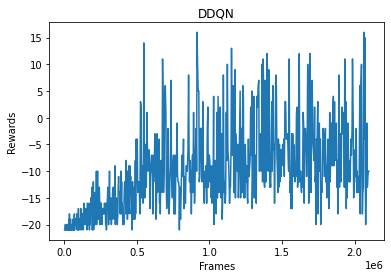

Episode:  701
Steps:  524220  epsilon:  0.030000000004013292
Steps:  524420  epsilon:  0.03000000000397336
Steps:  524620  epsilon:  0.03000000000393382
Steps:  524820  epsilon:  0.030000000003894682
Steps:  525020  epsilon:  0.03000000000385593
Steps:  525220  epsilon:  0.03000000000381756
Episode:  702
Steps:  525324  epsilon:  0.03000000000379776
Steps:  525524  epsilon:  0.030000000003759974
Steps:  525724  epsilon:  0.03000000000372256
Steps:  525924  epsilon:  0.03000000000368552
Steps:  526124  epsilon:  0.030000000003648847
Steps:  526324  epsilon:  0.030000000003612543
Episode:  703
Steps:  526394  epsilon:  0.03000000000359992
Steps:  526594  epsilon:  0.0300000000035641
Steps:  526794  epsilon:  0.030000000003528638
Steps:  526994  epsilon:  0.030000000003493527
Steps:  527194  epsilon:  0.030000000003458763
Episode:  704
Steps:  527247  epsilon:  0.03000000000344961
Steps:  527447  epsilon:  0.030000000003415288
Steps:  527647  epsilon:  0.030000000003381305
Steps:  527847 

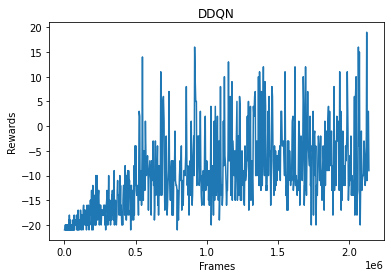

Episode:  711
Steps:  533930  epsilon:  0.030000000002469735
Steps:  534130  epsilon:  0.03000000000244516
Steps:  534330  epsilon:  0.030000000002420833
Steps:  534530  epsilon:  0.030000000002396745
Steps:  534730  epsilon:  0.030000000002372896
Episode:  712
Steps:  534899  epsilon:  0.03000000000235293
Steps:  535099  epsilon:  0.030000000002329517
Steps:  535299  epsilon:  0.030000000002306338
Steps:  535499  epsilon:  0.03000000000228339
Steps:  535699  epsilon:  0.03000000000226067
Episode:  713
Steps:  535820  epsilon:  0.030000000002247035
Steps:  536020  epsilon:  0.030000000002224678
Steps:  536220  epsilon:  0.03000000000220254
Steps:  536420  epsilon:  0.030000000002180626
Steps:  536620  epsilon:  0.030000000002158928
Steps:  536820  epsilon:  0.030000000002137445
Episode:  714
Steps:  536980  epsilon:  0.030000000002120414
Steps:  537180  epsilon:  0.030000000002099316
Steps:  537380  epsilon:  0.030000000002078427
Steps:  537580  epsilon:  0.030000000002057745
Steps:  5

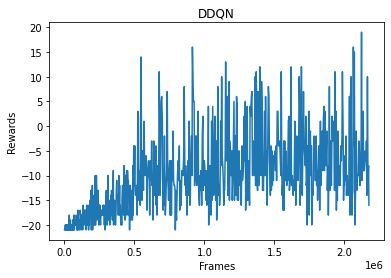

Episode:  721
Steps:  543266  epsilon:  0.030000000001548538
Steps:  543466  epsilon:  0.03000000000153313
Steps:  543666  epsilon:  0.030000000001517875
Steps:  543866  epsilon:  0.030000000001502772
Steps:  544066  epsilon:  0.03000000000148782
Steps:  544266  epsilon:  0.030000000001473015
Episode:  722
Steps:  544285  epsilon:  0.030000000001471617
Steps:  544485  epsilon:  0.030000000001456972
Steps:  544685  epsilon:  0.030000000001442477
Steps:  544885  epsilon:  0.030000000001428124
Steps:  545085  epsilon:  0.030000000001413913
Steps:  545285  epsilon:  0.030000000001399844
Steps:  545485  epsilon:  0.030000000001385915
Episode:  723
Steps:  545548  epsilon:  0.030000000001381557
Steps:  545748  epsilon:  0.03000000000136781
Steps:  545948  epsilon:  0.0300000000013542
Steps:  546148  epsilon:  0.030000000001340725
Steps:  546348  epsilon:  0.030000000001327385
Episode:  724
Steps:  546491  epsilon:  0.030000000001317927
Steps:  546691  epsilon:  0.030000000001304816
Steps:  5

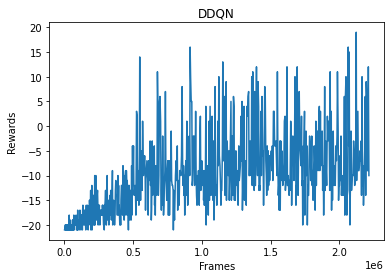

Episode:  731
Steps:  553113  epsilon:  0.030000000000946447
Steps:  553313  epsilon:  0.03000000000093703
Steps:  553513  epsilon:  0.030000000000927708
Steps:  553713  epsilon:  0.030000000000918476
Steps:  553913  epsilon:  0.030000000000909337
Steps:  554113  epsilon:  0.03000000000090029
Episode:  732
Steps:  554178  epsilon:  0.030000000000897368
Steps:  554378  epsilon:  0.030000000000888438
Steps:  554578  epsilon:  0.030000000000879597
Steps:  554778  epsilon:  0.030000000000870847
Steps:  554978  epsilon:  0.03000000000086218
Episode:  733
Steps:  555076  epsilon:  0.03000000000085797
Steps:  555276  epsilon:  0.03000000000084943
Steps:  555476  epsilon:  0.03000000000084098
Steps:  555676  epsilon:  0.03000000000083261
Steps:  555876  epsilon:  0.030000000000824326
Episode:  734
Steps:  556022  epsilon:  0.03000000000081833
Steps:  556222  epsilon:  0.030000000000810188
Steps:  556422  epsilon:  0.030000000000802125
Steps:  556622  epsilon:  0.030000000000794145
Steps:  5568

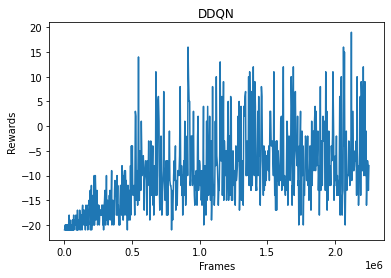

Episode:  741
Steps:  562437  epsilon:  0.030000000000593784
Steps:  562637  epsilon:  0.030000000000587876
Steps:  562837  epsilon:  0.030000000000582026
Steps:  563037  epsilon:  0.030000000000576236
Steps:  563237  epsilon:  0.0300000000005705
Steps:  563437  epsilon:  0.030000000000564825
Episode:  742
Steps:  563470  epsilon:  0.030000000000563895
Steps:  563670  epsilon:  0.03000000000055828
Steps:  563870  epsilon:  0.030000000000552727
Steps:  564070  epsilon:  0.030000000000547228
Steps:  564270  epsilon:  0.030000000000541784
Episode:  743
Steps:  564385  epsilon:  0.030000000000538676
Steps:  564585  epsilon:  0.030000000000533315
Steps:  564785  epsilon:  0.03000000000052801
Steps:  564985  epsilon:  0.030000000000522758
Steps:  565185  epsilon:  0.030000000000517554
Steps:  565385  epsilon:  0.030000000000512405
Steps:  565585  epsilon:  0.030000000000507305
Episode:  744
Steps:  565590  epsilon:  0.03000000000050718
Steps:  565790  epsilon:  0.030000000000502132
Steps:  5

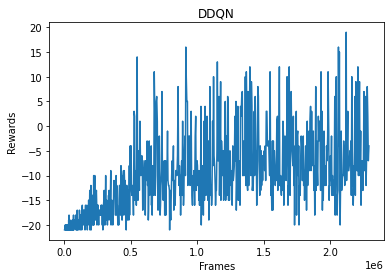

Episode:  751
Steps:  572783  epsilon:  0.03000000000035397
Steps:  572983  epsilon:  0.030000000000350448
Steps:  573183  epsilon:  0.03000000000034696
Steps:  573383  epsilon:  0.03000000000034351
Steps:  573583  epsilon:  0.03000000000034009
Episode:  752
Steps:  573688  epsilon:  0.03000000000033831
Steps:  573888  epsilon:  0.030000000000334943
Steps:  574088  epsilon:  0.030000000000331612
Steps:  574288  epsilon:  0.030000000000328313
Episode:  753
Steps:  574475  epsilon:  0.030000000000325256
Steps:  574675  epsilon:  0.03000000000032202
Steps:  574875  epsilon:  0.030000000000318817
Steps:  575075  epsilon:  0.030000000000315642
Steps:  575275  epsilon:  0.030000000000312502
Episode:  754
Steps:  575374  epsilon:  0.03000000000031096
Steps:  575574  epsilon:  0.030000000000307867
Steps:  575774  epsilon:  0.030000000000304804
Steps:  575974  epsilon:  0.030000000000301768
Steps:  576174  epsilon:  0.030000000000298767
Episode:  755
Steps:  576320  epsilon:  0.0300000000002965

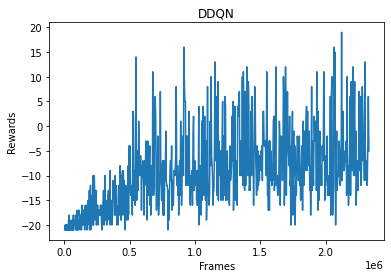

Episode:  761
Steps:  582313  epsilon:  0.0300000000002198
Steps:  582513  epsilon:  0.030000000000217613
Steps:  582713  epsilon:  0.030000000000215448
Steps:  582913  epsilon:  0.030000000000213304
Steps:  583113  epsilon:  0.03000000000021118
Steps:  583313  epsilon:  0.030000000000209078
Episode:  762
Steps:  583442  epsilon:  0.030000000000207735
Steps:  583642  epsilon:  0.030000000000205668
Steps:  583842  epsilon:  0.03000000000020362
Steps:  584042  epsilon:  0.030000000000201595
Steps:  584242  epsilon:  0.03000000000019959
Episode:  763
Steps:  584249  epsilon:  0.03000000000019952
Steps:  584449  epsilon:  0.030000000000197535
Steps:  584649  epsilon:  0.030000000000195568
Steps:  584849  epsilon:  0.030000000000193622
Steps:  585049  epsilon:  0.030000000000191696
Steps:  585249  epsilon:  0.030000000000189788
Episode:  764
Steps:  585290  epsilon:  0.0300000000001894
Steps:  585490  epsilon:  0.030000000000187516
Steps:  585690  epsilon:  0.03000000000018565
Steps:  58589

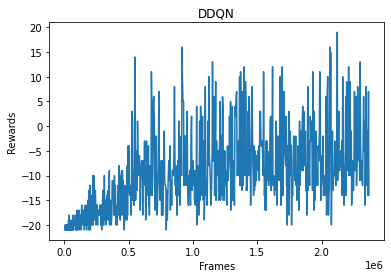

Episode:  771
Steps:  591515  epsilon:  0.030000000000138742
Steps:  591715  epsilon:  0.03000000000013736
Steps:  591915  epsilon:  0.030000000000135994
Steps:  592115  epsilon:  0.03000000000013464
Steps:  592315  epsilon:  0.030000000000133302
Steps:  592515  epsilon:  0.030000000000131973
Episode:  772
Steps:  592653  epsilon:  0.030000000000131068
Steps:  592853  epsilon:  0.030000000000129763
Steps:  593053  epsilon:  0.030000000000128473
Steps:  593253  epsilon:  0.030000000000127192
Steps:  593453  epsilon:  0.03000000000012593
Steps:  593653  epsilon:  0.030000000000124673
Steps:  593853  epsilon:  0.030000000000123435
Episode:  773
Steps:  593967  epsilon:  0.030000000000122734
Steps:  594167  epsilon:  0.030000000000121513
Steps:  594367  epsilon:  0.030000000000120302
Steps:  594567  epsilon:  0.030000000000119105
Steps:  594767  epsilon:  0.03000000000011792
Episode:  774
Steps:  594787  epsilon:  0.030000000000117804
Steps:  594987  epsilon:  0.03000000000011663
Steps:  5

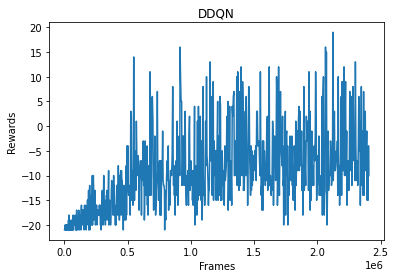

Episode:  781
Steps:  601165  epsilon:  0.030000000000085635
Steps:  601365  epsilon:  0.030000000000084785
Steps:  601565  epsilon:  0.03000000000008394
Steps:  601765  epsilon:  0.030000000000083106
Steps:  601965  epsilon:  0.030000000000082277
Episode:  782
Steps:  601981  epsilon:  0.03000000000008221
Steps:  602181  epsilon:  0.030000000000081396
Steps:  602381  epsilon:  0.030000000000080584
Steps:  602581  epsilon:  0.030000000000079782
Steps:  602781  epsilon:  0.030000000000078988
Episode:  783
Steps:  602964  epsilon:  0.03000000000007827
Steps:  603164  epsilon:  0.03000000000007749
Steps:  603364  epsilon:  0.03000000000007672
Steps:  603564  epsilon:  0.030000000000075955
Steps:  603764  epsilon:  0.0300000000000752
Steps:  603964  epsilon:  0.030000000000074453
Episode:  784
Steps:  603977  epsilon:  0.030000000000074405
Steps:  604177  epsilon:  0.030000000000073662
Steps:  604377  epsilon:  0.03000000000007293
Steps:  604577  epsilon:  0.030000000000072205
Steps:  6047

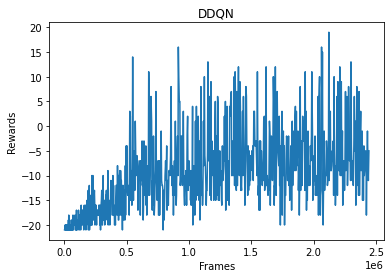

Episode:  791
Steps:  610426  epsilon:  0.030000000000053897
Steps:  610626  epsilon:  0.03000000000005336
Steps:  610826  epsilon:  0.030000000000052828
Steps:  611026  epsilon:  0.030000000000052304
Steps:  611226  epsilon:  0.030000000000051784
Episode:  792
Steps:  611319  epsilon:  0.03000000000005154
Steps:  611519  epsilon:  0.030000000000051028
Steps:  611719  epsilon:  0.03000000000005052
Steps:  611919  epsilon:  0.030000000000050018
Steps:  612119  epsilon:  0.030000000000049522
Steps:  612319  epsilon:  0.03000000000004903
Episode:  793
Steps:  612382  epsilon:  0.030000000000048873
Steps:  612582  epsilon:  0.030000000000048387
Steps:  612782  epsilon:  0.030000000000047905
Steps:  612982  epsilon:  0.03000000000004743
Steps:  613182  epsilon:  0.030000000000046958
Steps:  613382  epsilon:  0.03000000000004649
Steps:  613582  epsilon:  0.030000000000046028
Episode:  794
Steps:  613699  epsilon:  0.03000000000004576
Steps:  613899  epsilon:  0.030000000000045303
Steps:  614

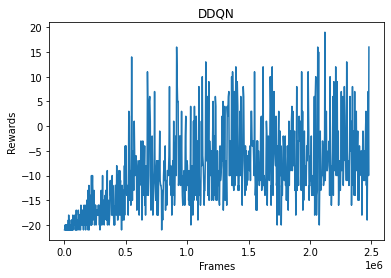

Episode:  801
Steps:  619648  epsilon:  0.030000000000033986
Steps:  619848  epsilon:  0.03000000000003365
Steps:  620048  epsilon:  0.030000000000033313
Steps:  620248  epsilon:  0.03000000000003298
Steps:  620448  epsilon:  0.030000000000032653
Steps:  620648  epsilon:  0.030000000000032327
Episode:  802
Steps:  620736  epsilon:  0.030000000000032185
Steps:  620936  epsilon:  0.030000000000031866
Steps:  621136  epsilon:  0.03000000000003155
Episode:  803
Steps:  621329  epsilon:  0.030000000000031245
Steps:  621529  epsilon:  0.030000000000030936
Steps:  621729  epsilon:  0.030000000000030627
Steps:  621929  epsilon:  0.030000000000030322
Steps:  622129  epsilon:  0.03000000000003002
Episode:  804
Steps:  622295  epsilon:  0.030000000000029774
Steps:  622495  epsilon:  0.030000000000029475
Steps:  622695  epsilon:  0.030000000000029184
Steps:  622895  epsilon:  0.030000000000028892
Steps:  623095  epsilon:  0.030000000000028604
Episode:  805
Steps:  623116  epsilon:  0.0300000000000

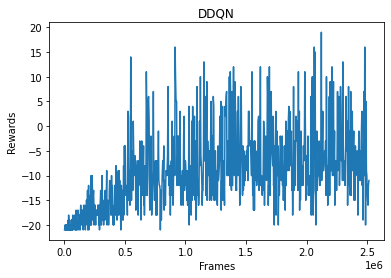

Episode:  811
Steps:  628223  epsilon:  0.030000000000022134
Steps:  628423  epsilon:  0.030000000000021915
Steps:  628623  epsilon:  0.030000000000021697
Steps:  628823  epsilon:  0.03000000000002148
Steps:  629023  epsilon:  0.030000000000021267
Episode:  812
Steps:  629186  epsilon:  0.030000000000021093
Steps:  629386  epsilon:  0.030000000000020885
Steps:  629586  epsilon:  0.030000000000020677
Steps:  629786  epsilon:  0.030000000000020472
Steps:  629986  epsilon:  0.030000000000020267
Steps:  630186  epsilon:  0.030000000000020066
Episode:  813
Steps:  630332  epsilon:  0.03000000000001992
Steps:  630532  epsilon:  0.030000000000019723
Steps:  630732  epsilon:  0.030000000000019525
Steps:  630932  epsilon:  0.03000000000001933
Steps:  631132  epsilon:  0.03000000000001914
Episode:  814
Steps:  631292  epsilon:  0.030000000000018987
Steps:  631492  epsilon:  0.030000000000018796
Steps:  631692  epsilon:  0.03000000000001861
Steps:  631892  epsilon:  0.030000000000018425
Episode: 

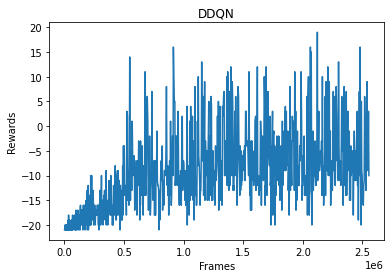

Episode:  821
Steps:  638128  epsilon:  0.030000000000013488
Steps:  638328  epsilon:  0.030000000000013356
Steps:  638528  epsilon:  0.03000000000001322
Steps:  638728  epsilon:  0.03000000000001309
Episode:  822
Steps:  638865  epsilon:  0.030000000000013002
Steps:  639065  epsilon:  0.03000000000001287
Steps:  639265  epsilon:  0.030000000000012742
Steps:  639465  epsilon:  0.030000000000012617
Steps:  639665  epsilon:  0.030000000000012492
Steps:  639865  epsilon:  0.030000000000012367
Episode:  823
Steps:  640064  epsilon:  0.030000000000012246
Steps:  640264  epsilon:  0.03000000000001212
Steps:  640464  epsilon:  0.030000000000012003
Steps:  640664  epsilon:  0.030000000000011882
Steps:  640864  epsilon:  0.030000000000011764
Episode:  824
Steps:  640887  epsilon:  0.03000000000001175
Steps:  641087  epsilon:  0.030000000000011635
Steps:  641287  epsilon:  0.030000000000011517
Steps:  641487  epsilon:  0.030000000000011403
Steps:  641687  epsilon:  0.03000000000001129
Steps:  64

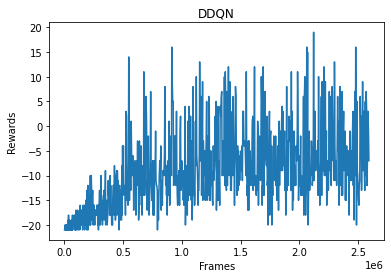

Episode:  831
Steps:  647722  epsilon:  0.03000000000000835
Steps:  647922  epsilon:  0.030000000000008267
Steps:  648122  epsilon:  0.030000000000008183
Steps:  648322  epsilon:  0.030000000000008104
Steps:  648522  epsilon:  0.03000000000000802
Episode:  832
Steps:  648717  epsilon:  0.030000000000007944
Steps:  648917  epsilon:  0.030000000000007864
Steps:  649117  epsilon:  0.030000000000007788
Steps:  649317  epsilon:  0.030000000000007708
Steps:  649517  epsilon:  0.03000000000000763
Episode:  833
Steps:  649714  epsilon:  0.03000000000000756
Steps:  649914  epsilon:  0.030000000000007482
Steps:  650114  epsilon:  0.030000000000007406
Steps:  650314  epsilon:  0.030000000000007333
Steps:  650514  epsilon:  0.03000000000000726
Steps:  650714  epsilon:  0.030000000000007188
Episode:  834
Steps:  650844  epsilon:  0.030000000000007142
Steps:  651044  epsilon:  0.03000000000000707
Steps:  651244  epsilon:  0.030000000000007
Steps:  651444  epsilon:  0.03000000000000693
Steps:  651644

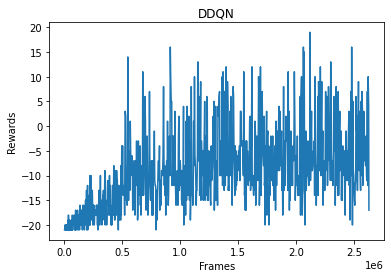

Episode:  841
Steps:  656829  epsilon:  0.030000000000005293
Steps:  657029  epsilon:  0.03000000000000524
Steps:  657229  epsilon:  0.03000000000000519
Steps:  657429  epsilon:  0.030000000000005137
Steps:  657629  epsilon:  0.03000000000000509
Steps:  657829  epsilon:  0.030000000000005037
Episode:  842
Steps:  657870  epsilon:  0.030000000000005026
Steps:  658070  epsilon:  0.030000000000004978
Steps:  658270  epsilon:  0.030000000000004926
Steps:  658470  epsilon:  0.030000000000004877
Steps:  658670  epsilon:  0.03000000000000483
Steps:  658870  epsilon:  0.03000000000000478
Episode:  843
Steps:  658938  epsilon:  0.030000000000004766
Steps:  659138  epsilon:  0.030000000000004717
Steps:  659338  epsilon:  0.03000000000000467
Steps:  659538  epsilon:  0.030000000000004624
Steps:  659738  epsilon:  0.03000000000000458
Steps:  659938  epsilon:  0.030000000000004533
Episode:  844
Steps:  660048  epsilon:  0.030000000000004506
Steps:  660248  epsilon:  0.030000000000004464
Steps:  660

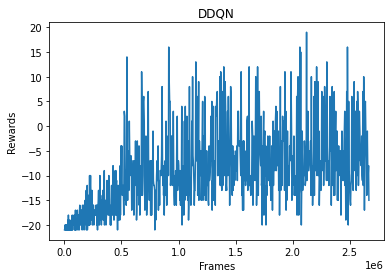

Episode:  851
Steps:  666604  epsilon:  0.030000000000003246
Steps:  666804  epsilon:  0.030000000000003215
Steps:  667004  epsilon:  0.030000000000003184
Steps:  667204  epsilon:  0.030000000000003153
Steps:  667404  epsilon:  0.03000000000000312
Episode:  852
Steps:  667583  epsilon:  0.030000000000003094
Steps:  667783  epsilon:  0.030000000000003062
Steps:  667983  epsilon:  0.03000000000000303
Steps:  668183  epsilon:  0.030000000000003
Steps:  668383  epsilon:  0.030000000000002972
Steps:  668583  epsilon:  0.03000000000000294
Episode:  853
Steps:  668664  epsilon:  0.03000000000000293
Steps:  668864  epsilon:  0.0300000000000029
Steps:  669064  epsilon:  0.03000000000000287
Steps:  669264  epsilon:  0.030000000000002844
Steps:  669464  epsilon:  0.030000000000002816
Steps:  669664  epsilon:  0.030000000000002785
Steps:  669864  epsilon:  0.030000000000002757
Episode:  854
Steps:  669905  epsilon:  0.030000000000002754
Steps:  670105  epsilon:  0.030000000000002726
Steps:  670305

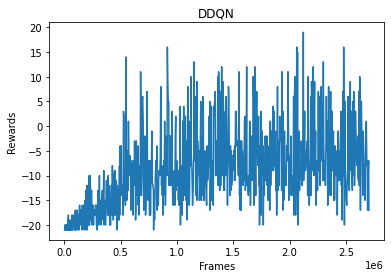

Episode:  861
Steps:  675616  epsilon:  0.03000000000000207
Steps:  675816  epsilon:  0.03000000000000205
Steps:  676016  epsilon:  0.03000000000000203
Steps:  676216  epsilon:  0.030000000000002008
Steps:  676416  epsilon:  0.030000000000001987
Steps:  676616  epsilon:  0.03000000000000197
Episode:  862
Steps:  676696  epsilon:  0.03000000000000196
Steps:  676896  epsilon:  0.030000000000001942
Steps:  677096  epsilon:  0.03000000000000192
Steps:  677296  epsilon:  0.030000000000001904
Steps:  677496  epsilon:  0.030000000000001883
Episode:  863
Steps:  677612  epsilon:  0.030000000000001872
Steps:  677812  epsilon:  0.030000000000001855
Steps:  678012  epsilon:  0.030000000000001834
Steps:  678212  epsilon:  0.030000000000001817
Steps:  678412  epsilon:  0.0300000000000018
Steps:  678612  epsilon:  0.030000000000001782
Episode:  864
Steps:  678711  epsilon:  0.030000000000001772
Steps:  678911  epsilon:  0.030000000000001754
Steps:  679111  epsilon:  0.030000000000001737
Steps:  6793

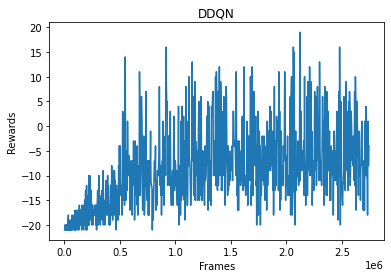

Episode:  871
Steps:  685624  epsilon:  0.030000000000001255
Steps:  685824  epsilon:  0.03000000000000124
Steps:  686024  epsilon:  0.03000000000000123
Steps:  686224  epsilon:  0.030000000000001217
Steps:  686424  epsilon:  0.030000000000001206
Steps:  686624  epsilon:  0.030000000000001192
Episode:  872
Steps:  686675  epsilon:  0.03000000000000119
Steps:  686875  epsilon:  0.03000000000000118
Steps:  687075  epsilon:  0.030000000000001165
Steps:  687275  epsilon:  0.030000000000001154
Steps:  687475  epsilon:  0.030000000000001144
Steps:  687675  epsilon:  0.03000000000000113
Episode:  873
Steps:  687801  epsilon:  0.030000000000001123
Steps:  688001  epsilon:  0.030000000000001113
Steps:  688201  epsilon:  0.030000000000001102
Steps:  688401  epsilon:  0.030000000000001092
Episode:  874
Steps:  688537  epsilon:  0.030000000000001085
Steps:  688737  epsilon:  0.030000000000001074
Steps:  688937  epsilon:  0.030000000000001064
Steps:  689137  epsilon:  0.03000000000000105
Steps:  68

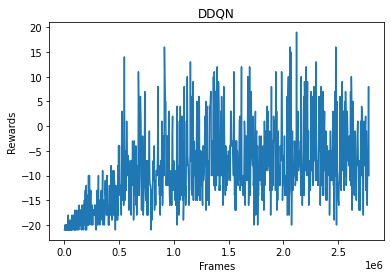

Episode:  881
Steps:  695330  epsilon:  0.030000000000000773
Steps:  695530  epsilon:  0.030000000000000762
Steps:  695730  epsilon:  0.030000000000000755
Steps:  695930  epsilon:  0.03000000000000075
Steps:  696130  epsilon:  0.03000000000000074
Episode:  882
Steps:  696237  epsilon:  0.030000000000000738
Steps:  696437  epsilon:  0.03000000000000073
Steps:  696637  epsilon:  0.030000000000000724
Steps:  696837  epsilon:  0.030000000000000714
Steps:  697037  epsilon:  0.030000000000000707
Steps:  697237  epsilon:  0.0300000000000007
Episode:  883
Steps:  697278  epsilon:  0.0300000000000007
Steps:  697478  epsilon:  0.030000000000000693
Steps:  697678  epsilon:  0.030000000000000686
Steps:  697878  epsilon:  0.03000000000000068
Steps:  698078  epsilon:  0.030000000000000672
Steps:  698278  epsilon:  0.030000000000000665
Steps:  698478  epsilon:  0.030000000000000658
Episode:  884
Steps:  698632  epsilon:  0.030000000000000655
Steps:  698832  epsilon:  0.030000000000000648
Steps:  6990

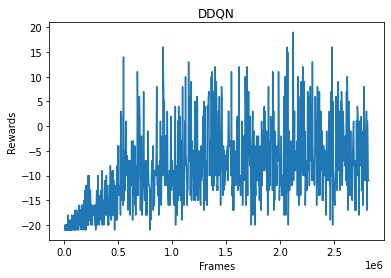

Episode:  891
Steps:  705374  epsilon:  0.030000000000000467
Steps:  705574  epsilon:  0.03000000000000046
Steps:  705774  epsilon:  0.030000000000000457
Steps:  705974  epsilon:  0.030000000000000453
Steps:  706174  epsilon:  0.030000000000000446
Episode:  892
Steps:  706280  epsilon:  0.030000000000000446
Steps:  706480  epsilon:  0.030000000000000443
Steps:  706680  epsilon:  0.030000000000000436
Steps:  706880  epsilon:  0.030000000000000433
Steps:  707080  epsilon:  0.03000000000000043
Episode:  893
Steps:  707253  epsilon:  0.030000000000000426
Steps:  707453  epsilon:  0.03000000000000042
Steps:  707653  epsilon:  0.030000000000000415
Steps:  707853  epsilon:  0.030000000000000412
Episode:  894
Steps:  707873  epsilon:  0.030000000000000412
Steps:  708073  epsilon:  0.03000000000000041
Steps:  708273  epsilon:  0.030000000000000405
Steps:  708473  epsilon:  0.030000000000000398
Episode:  895
Steps:  708525  epsilon:  0.030000000000000398
Steps:  708725  epsilon:  0.0300000000000

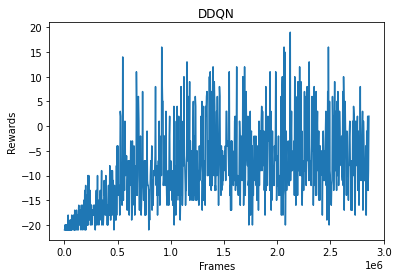

Episode:  901
Steps:  714715  epsilon:  0.03000000000000029
Steps:  714915  epsilon:  0.03000000000000029
Steps:  715115  epsilon:  0.030000000000000287
Steps:  715315  epsilon:  0.030000000000000283
Steps:  715515  epsilon:  0.03000000000000028
Steps:  715715  epsilon:  0.030000000000000276
Episode:  902
Steps:  715845  epsilon:  0.030000000000000276
Steps:  716045  epsilon:  0.030000000000000273
Steps:  716245  epsilon:  0.03000000000000027
Steps:  716445  epsilon:  0.030000000000000266
Steps:  716645  epsilon:  0.030000000000000266
Episode:  903
Steps:  716681  epsilon:  0.030000000000000266
Steps:  716881  epsilon:  0.030000000000000263
Steps:  717081  epsilon:  0.03000000000000026
Steps:  717281  epsilon:  0.030000000000000256
Episode:  904
Steps:  717435  epsilon:  0.030000000000000256
Steps:  717635  epsilon:  0.030000000000000252
Steps:  717835  epsilon:  0.03000000000000025
Steps:  718035  epsilon:  0.03000000000000025
Steps:  718235  epsilon:  0.030000000000000245
Steps:  718

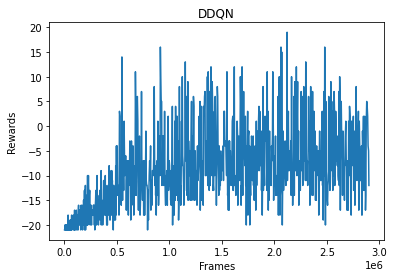

Episode:  911
Steps:  724821  epsilon:  0.030000000000000176
Steps:  725021  epsilon:  0.030000000000000172
Steps:  725221  epsilon:  0.030000000000000172
Steps:  725421  epsilon:  0.03000000000000017
Steps:  725621  epsilon:  0.03000000000000017
Steps:  725821  epsilon:  0.030000000000000165
Episode:  912
Steps:  725962  epsilon:  0.030000000000000165
Steps:  726162  epsilon:  0.030000000000000165
Steps:  726362  epsilon:  0.030000000000000162
Steps:  726562  epsilon:  0.030000000000000162
Steps:  726762  epsilon:  0.03000000000000016
Steps:  726962  epsilon:  0.03000000000000016
Episode:  913
Steps:  727016  epsilon:  0.03000000000000016
Steps:  727216  epsilon:  0.030000000000000155
Steps:  727416  epsilon:  0.030000000000000155
Steps:  727616  epsilon:  0.03000000000000015
Steps:  727816  epsilon:  0.03000000000000015
Steps:  728016  epsilon:  0.030000000000000148
Episode:  914
Steps:  728139  epsilon:  0.030000000000000148
Steps:  728339  epsilon:  0.030000000000000148
Steps:  728

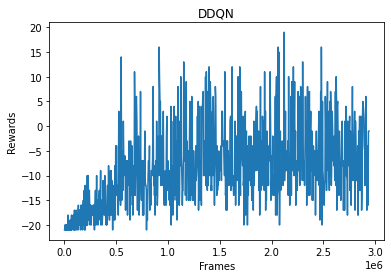

Episode:  921
Steps:  734269  epsilon:  0.03000000000000011
Steps:  734469  epsilon:  0.030000000000000106
Steps:  734669  epsilon:  0.030000000000000106
Steps:  734869  epsilon:  0.030000000000000106
Steps:  735069  epsilon:  0.030000000000000106
Episode:  922
Steps:  735167  epsilon:  0.030000000000000103
Steps:  735367  epsilon:  0.030000000000000103
Steps:  735567  epsilon:  0.030000000000000103
Steps:  735767  epsilon:  0.0300000000000001
Episode:  923
Steps:  735895  epsilon:  0.0300000000000001
Steps:  736095  epsilon:  0.0300000000000001
Steps:  736295  epsilon:  0.0300000000000001
Steps:  736495  epsilon:  0.030000000000000096
Steps:  736695  epsilon:  0.030000000000000096
Episode:  924
Steps:  736832  epsilon:  0.030000000000000096
Steps:  737032  epsilon:  0.030000000000000096
Steps:  737232  epsilon:  0.030000000000000093
Steps:  737432  epsilon:  0.030000000000000093
Steps:  737632  epsilon:  0.030000000000000093
Episode:  925
Steps:  737767  epsilon:  0.030000000000000093

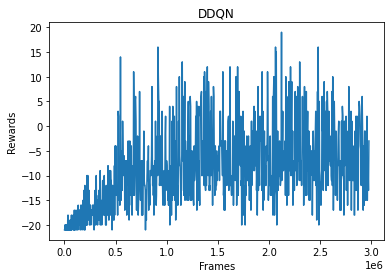

Episode:  931
Steps:  743536  epsilon:  0.03000000000000007
Steps:  743736  epsilon:  0.03000000000000007
Steps:  743936  epsilon:  0.03000000000000007
Steps:  744136  epsilon:  0.030000000000000065
Steps:  744336  epsilon:  0.030000000000000065
Steps:  744536  epsilon:  0.030000000000000065
Steps:  744736  epsilon:  0.030000000000000065
Episode:  932
Steps:  744880  epsilon:  0.030000000000000065
Steps:  745080  epsilon:  0.030000000000000065
Steps:  745280  epsilon:  0.03000000000000006
Steps:  745480  epsilon:  0.03000000000000006
Steps:  745680  epsilon:  0.03000000000000006
Steps:  745880  epsilon:  0.03000000000000006
Episode:  933
Steps:  745895  epsilon:  0.03000000000000006
Steps:  746095  epsilon:  0.03000000000000006
Steps:  746295  epsilon:  0.030000000000000058
Steps:  746495  epsilon:  0.030000000000000058
Steps:  746695  epsilon:  0.030000000000000058
Episode:  934
Steps:  746874  epsilon:  0.030000000000000058
Steps:  747074  epsilon:  0.030000000000000058
Steps:  74727

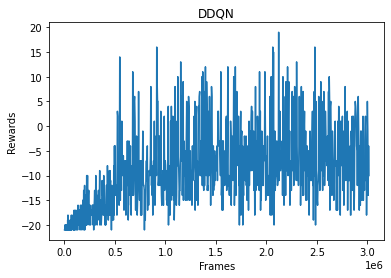

Episode:  941
Steps:  753388  epsilon:  0.03000000000000004
Steps:  753588  epsilon:  0.03000000000000004
Steps:  753788  epsilon:  0.03000000000000004
Steps:  753988  epsilon:  0.03000000000000004
Steps:  754188  epsilon:  0.03000000000000004
Episode:  942
Steps:  754344  epsilon:  0.03000000000000004
Steps:  754544  epsilon:  0.03000000000000004
Steps:  754744  epsilon:  0.030000000000000037
Steps:  754944  epsilon:  0.030000000000000037
Steps:  755144  epsilon:  0.030000000000000037
Episode:  943
Steps:  755199  epsilon:  0.030000000000000037
Steps:  755399  epsilon:  0.030000000000000037
Steps:  755599  epsilon:  0.030000000000000037
Steps:  755799  epsilon:  0.030000000000000037
Steps:  755999  epsilon:  0.030000000000000037
Steps:  756199  epsilon:  0.030000000000000037
Episode:  944
Steps:  756391  epsilon:  0.030000000000000037
Steps:  756591  epsilon:  0.030000000000000034
Steps:  756791  epsilon:  0.030000000000000034
Steps:  756991  epsilon:  0.030000000000000034
Episode:  9

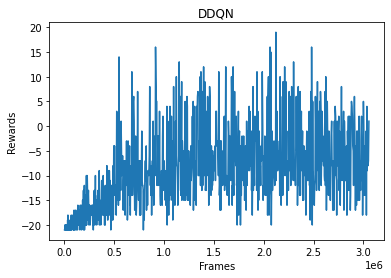

Episode:  951
Steps:  763326  epsilon:  0.030000000000000023
Steps:  763526  epsilon:  0.030000000000000023
Steps:  763726  epsilon:  0.030000000000000023
Steps:  763926  epsilon:  0.030000000000000023
Steps:  764126  epsilon:  0.030000000000000023
Steps:  764326  epsilon:  0.030000000000000023
Episode:  952
Steps:  764476  epsilon:  0.030000000000000023
Steps:  764676  epsilon:  0.030000000000000023
Steps:  764876  epsilon:  0.030000000000000023
Steps:  765076  epsilon:  0.030000000000000023
Steps:  765276  epsilon:  0.030000000000000023
Episode:  953
Steps:  765316  epsilon:  0.030000000000000023
Steps:  765516  epsilon:  0.030000000000000023
Steps:  765716  epsilon:  0.030000000000000023
Steps:  765916  epsilon:  0.030000000000000023
Steps:  766116  epsilon:  0.03000000000000002
Episode:  954
Steps:  766170  epsilon:  0.03000000000000002
Steps:  766370  epsilon:  0.03000000000000002
Steps:  766570  epsilon:  0.03000000000000002
Steps:  766770  epsilon:  0.03000000000000002
Steps:  7

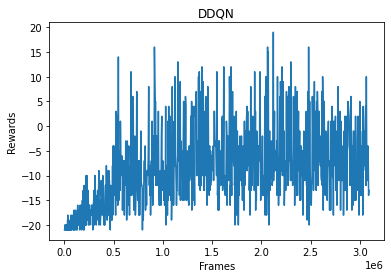

Episode:  961
Steps:  772682  epsilon:  0.030000000000000016
Steps:  772882  epsilon:  0.030000000000000016
Steps:  773082  epsilon:  0.030000000000000016
Steps:  773282  epsilon:  0.030000000000000016
Steps:  773482  epsilon:  0.030000000000000013
Steps:  773682  epsilon:  0.030000000000000013
Episode:  962
Steps:  773790  epsilon:  0.030000000000000013
Steps:  773990  epsilon:  0.030000000000000013
Steps:  774190  epsilon:  0.030000000000000013
Steps:  774390  epsilon:  0.030000000000000013
Steps:  774590  epsilon:  0.030000000000000013
Episode:  963
Steps:  774616  epsilon:  0.030000000000000013
Steps:  774816  epsilon:  0.030000000000000013
Steps:  775016  epsilon:  0.030000000000000013
Steps:  775216  epsilon:  0.030000000000000013
Steps:  775416  epsilon:  0.030000000000000013
Steps:  775616  epsilon:  0.030000000000000013
Episode:  964
Steps:  775680  epsilon:  0.030000000000000013
Steps:  775880  epsilon:  0.030000000000000013
Steps:  776080  epsilon:  0.030000000000000013
Step

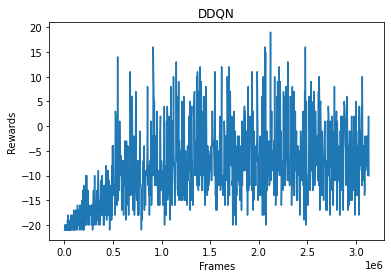

Episode:  971
Steps:  783189  epsilon:  0.03000000000000001
Steps:  783389  epsilon:  0.03000000000000001
Steps:  783589  epsilon:  0.03000000000000001
Steps:  783789  epsilon:  0.03000000000000001
Steps:  783989  epsilon:  0.03000000000000001
Steps:  784189  epsilon:  0.03000000000000001
Episode:  972
Steps:  784244  epsilon:  0.03000000000000001
Steps:  784444  epsilon:  0.03000000000000001
Steps:  784644  epsilon:  0.03000000000000001
Steps:  784844  epsilon:  0.03000000000000001
Steps:  785044  epsilon:  0.03000000000000001
Steps:  785244  epsilon:  0.030000000000000006
Steps:  785444  epsilon:  0.030000000000000006
Episode:  973
Steps:  785546  epsilon:  0.030000000000000006
Steps:  785746  epsilon:  0.030000000000000006
Steps:  785946  epsilon:  0.030000000000000006
Steps:  786146  epsilon:  0.030000000000000006
Steps:  786346  epsilon:  0.030000000000000006
Episode:  974
Steps:  786513  epsilon:  0.030000000000000006
Steps:  786713  epsilon:  0.030000000000000006
Steps:  786913 

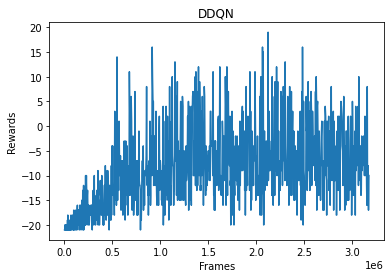

Episode:  981
Steps:  792483  epsilon:  0.030000000000000006
Steps:  792683  epsilon:  0.030000000000000006
Steps:  792883  epsilon:  0.030000000000000006
Steps:  793083  epsilon:  0.030000000000000006
Steps:  793283  epsilon:  0.030000000000000006
Episode:  982
Steps:  793337  epsilon:  0.030000000000000006
Steps:  793537  epsilon:  0.030000000000000006
Steps:  793737  epsilon:  0.030000000000000006
Steps:  793937  epsilon:  0.030000000000000006
Steps:  794137  epsilon:  0.030000000000000006
Episode:  983
Steps:  794186  epsilon:  0.030000000000000006
Steps:  794386  epsilon:  0.030000000000000006
Steps:  794586  epsilon:  0.030000000000000006
Steps:  794786  epsilon:  0.030000000000000006
Steps:  794986  epsilon:  0.030000000000000006
Episode:  984
Steps:  795062  epsilon:  0.030000000000000006
Steps:  795262  epsilon:  0.030000000000000006
Steps:  795462  epsilon:  0.030000000000000002
Steps:  795662  epsilon:  0.030000000000000002
Steps:  795862  epsilon:  0.030000000000000002
Epis

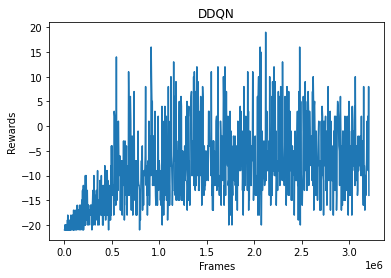

Episode:  991
Steps:  802023  epsilon:  0.030000000000000002
Steps:  802223  epsilon:  0.030000000000000002
Steps:  802423  epsilon:  0.030000000000000002
Steps:  802623  epsilon:  0.030000000000000002
Steps:  802823  epsilon:  0.030000000000000002
Steps:  803023  epsilon:  0.030000000000000002
Episode:  992
Steps:  803133  epsilon:  0.030000000000000002
Steps:  803333  epsilon:  0.030000000000000002
Steps:  803533  epsilon:  0.030000000000000002
Steps:  803733  epsilon:  0.030000000000000002
Steps:  803933  epsilon:  0.030000000000000002
Episode:  993
Steps:  804075  epsilon:  0.030000000000000002
Steps:  804275  epsilon:  0.030000000000000002
Steps:  804475  epsilon:  0.030000000000000002
Steps:  804675  epsilon:  0.030000000000000002
Steps:  804875  epsilon:  0.030000000000000002
Steps:  805075  epsilon:  0.030000000000000002
Steps:  805275  epsilon:  0.030000000000000002
Episode:  994
Steps:  805367  epsilon:  0.030000000000000002
Steps:  805567  epsilon:  0.030000000000000002
Step

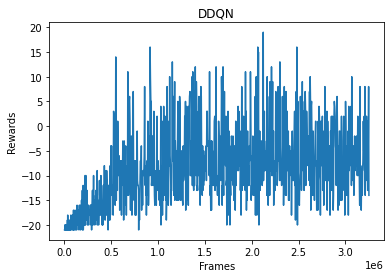

Episode:  1001
Steps:  811872  epsilon:  0.030000000000000002
Steps:  812072  epsilon:  0.030000000000000002
Steps:  812272  epsilon:  0.030000000000000002
Steps:  812472  epsilon:  0.030000000000000002
Steps:  812672  epsilon:  0.030000000000000002
Episode:  1002
Steps:  812768  epsilon:  0.030000000000000002
Steps:  812968  epsilon:  0.030000000000000002
Steps:  813168  epsilon:  0.030000000000000002
Steps:  813368  epsilon:  0.030000000000000002
Steps:  813568  epsilon:  0.030000000000000002
Episode:  1003
Steps:  813600  epsilon:  0.030000000000000002
Steps:  813800  epsilon:  0.030000000000000002
Steps:  814000  epsilon:  0.030000000000000002
Steps:  814200  epsilon:  0.030000000000000002
Steps:  814400  epsilon:  0.030000000000000002
Steps:  814600  epsilon:  0.030000000000000002
Episode:  1004
Steps:  814690  epsilon:  0.030000000000000002
Steps:  814890  epsilon:  0.030000000000000002
Steps:  815090  epsilon:  0.030000000000000002
Steps:  815290  epsilon:  0.030000000000000002


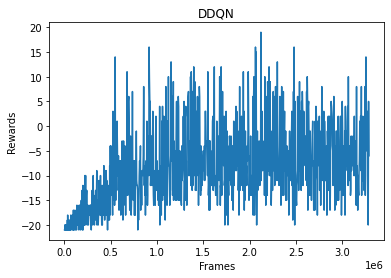

Episode:  1011
Steps:  821596  epsilon:  0.03
Steps:  821796  epsilon:  0.03
Steps:  821996  epsilon:  0.03
Steps:  822196  epsilon:  0.03
Episode:  1012
Steps:  822392  epsilon:  0.03
Steps:  822592  epsilon:  0.03
Steps:  822792  epsilon:  0.03
Steps:  822992  epsilon:  0.03
Steps:  823192  epsilon:  0.03
Steps:  823392  epsilon:  0.03
Episode:  1013
Steps:  823470  epsilon:  0.03
Steps:  823670  epsilon:  0.03
Steps:  823870  epsilon:  0.03
Steps:  824070  epsilon:  0.03
Steps:  824270  epsilon:  0.03
Steps:  824470  epsilon:  0.03
Steps:  824670  epsilon:  0.03
Episode:  1014
Steps:  824712  epsilon:  0.03
Steps:  824912  epsilon:  0.03
Steps:  825112  epsilon:  0.03
Steps:  825312  epsilon:  0.03
Steps:  825512  epsilon:  0.03
Episode:  1015
Steps:  825663  epsilon:  0.03
Steps:  825863  epsilon:  0.03
Steps:  826063  epsilon:  0.03
Steps:  826263  epsilon:  0.03
Episode:  1016
Steps:  826318  epsilon:  0.03
Steps:  826518  epsilon:  0.03
Steps:  826718  epsilon:  0.03
Steps:  826

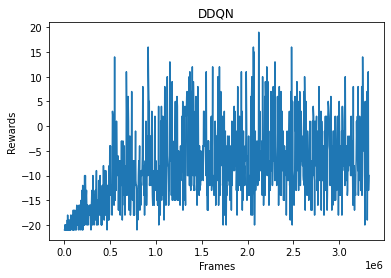

Episode:  1021
Steps:  830706  epsilon:  0.03
Steps:  830906  epsilon:  0.03
Steps:  831106  epsilon:  0.03
Steps:  831306  epsilon:  0.03
Steps:  831506  epsilon:  0.03
Steps:  831706  epsilon:  0.03
Steps:  831906  epsilon:  0.03
Episode:  1022
Steps:  831975  epsilon:  0.03
Steps:  832175  epsilon:  0.03
Steps:  832375  epsilon:  0.03
Steps:  832575  epsilon:  0.03
Steps:  832775  epsilon:  0.03
Steps:  832975  epsilon:  0.03
Episode:  1023
Steps:  833148  epsilon:  0.03
Steps:  833348  epsilon:  0.03
Steps:  833548  epsilon:  0.03
Steps:  833748  epsilon:  0.03
Steps:  833948  epsilon:  0.03
Episode:  1024
Steps:  834126  epsilon:  0.03
Steps:  834326  epsilon:  0.03
Steps:  834526  epsilon:  0.03
Steps:  834726  epsilon:  0.03
Steps:  834926  epsilon:  0.03
Episode:  1025
Steps:  835044  epsilon:  0.03
Steps:  835244  epsilon:  0.03
Steps:  835444  epsilon:  0.03
Steps:  835644  epsilon:  0.03
Steps:  835844  epsilon:  0.03
Steps:  836044  epsilon:  0.03
Steps:  836244  epsilon:  

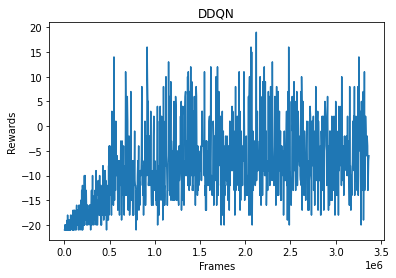

Episode:  1031
Steps:  841269  epsilon:  0.03
Steps:  841469  epsilon:  0.03
Steps:  841669  epsilon:  0.03
Steps:  841869  epsilon:  0.03
Steps:  842069  epsilon:  0.03
Steps:  842269  epsilon:  0.03
Episode:  1032
Steps:  842334  epsilon:  0.03
Steps:  842534  epsilon:  0.03
Steps:  842734  epsilon:  0.03
Steps:  842934  epsilon:  0.03
Steps:  843134  epsilon:  0.03
Steps:  843334  epsilon:  0.03
Episode:  1033
Steps:  843366  epsilon:  0.03
Steps:  843566  epsilon:  0.03
Steps:  843766  epsilon:  0.03
Steps:  843966  epsilon:  0.03
Steps:  844166  epsilon:  0.03
Episode:  1034
Steps:  844358  epsilon:  0.03
Steps:  844558  epsilon:  0.03
Steps:  844758  epsilon:  0.03
Steps:  844958  epsilon:  0.03
Steps:  845158  epsilon:  0.03
Steps:  845358  epsilon:  0.03
Episode:  1035
Steps:  845460  epsilon:  0.03
Steps:  845660  epsilon:  0.03
Steps:  845860  epsilon:  0.03
Steps:  846060  epsilon:  0.03
Episode:  1036
Steps:  846197  epsilon:  0.03
Steps:  846397  epsilon:  0.03
Steps:  846

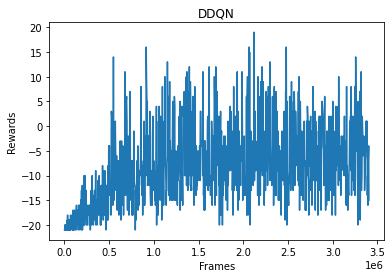

Episode:  1041
Steps:  850571  epsilon:  0.03
Steps:  850771  epsilon:  0.03
Steps:  850971  epsilon:  0.03
Steps:  851171  epsilon:  0.03
Steps:  851371  epsilon:  0.03
Episode:  1042
Steps:  851570  epsilon:  0.03
Steps:  851770  epsilon:  0.03
Steps:  851970  epsilon:  0.03
Episode:  1043
Steps:  852061  epsilon:  0.03
Steps:  852261  epsilon:  0.03
Steps:  852461  epsilon:  0.03
Steps:  852661  epsilon:  0.03
Steps:  852861  epsilon:  0.03
Episode:  1044
Steps:  852966  epsilon:  0.03
Steps:  853166  epsilon:  0.03
Steps:  853366  epsilon:  0.03
Steps:  853566  epsilon:  0.03
Steps:  853766  epsilon:  0.03
Steps:  853966  epsilon:  0.03
Episode:  1045
Steps:  854053  epsilon:  0.03
Steps:  854253  epsilon:  0.03
Steps:  854453  epsilon:  0.03
Steps:  854653  epsilon:  0.03
Steps:  854853  epsilon:  0.03
Episode:  1046
Steps:  854942  epsilon:  0.03
Steps:  855142  epsilon:  0.03
Steps:  855342  epsilon:  0.03
Steps:  855542  epsilon:  0.03
Episode:  1047
Steps:  855656  epsilon:  0

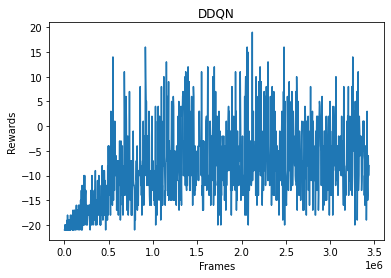

Episode:  1051
Steps:  859156  epsilon:  0.03
Steps:  859356  epsilon:  0.03
Steps:  859556  epsilon:  0.03
Steps:  859756  epsilon:  0.03
Steps:  859956  epsilon:  0.03
Steps:  860156  epsilon:  0.03
Episode:  1052
Steps:  860166  epsilon:  0.03
Steps:  860366  epsilon:  0.03
Steps:  860566  epsilon:  0.03
Steps:  860766  epsilon:  0.03
Episode:  1053
Steps:  860940  epsilon:  0.03
Steps:  861140  epsilon:  0.03
Steps:  861340  epsilon:  0.03
Steps:  861540  epsilon:  0.03
Steps:  861740  epsilon:  0.03
Episode:  1054
Steps:  861779  epsilon:  0.03
Steps:  861979  epsilon:  0.03
Steps:  862179  epsilon:  0.03
Steps:  862379  epsilon:  0.03
Episode:  1055
Steps:  862415  epsilon:  0.03
Steps:  862615  epsilon:  0.03
Steps:  862815  epsilon:  0.03
Steps:  863015  epsilon:  0.03
Steps:  863215  epsilon:  0.03
Steps:  863415  epsilon:  0.03
Episode:  1056
Steps:  863435  epsilon:  0.03
Steps:  863635  epsilon:  0.03
Steps:  863835  epsilon:  0.03
Steps:  864035  epsilon:  0.03
Steps:  864

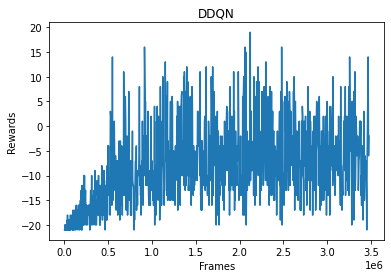

Episode:  1061
Steps:  868626  epsilon:  0.03
Steps:  868826  epsilon:  0.03
Steps:  869026  epsilon:  0.03
Steps:  869226  epsilon:  0.03
Steps:  869426  epsilon:  0.03
Steps:  869626  epsilon:  0.03
Steps:  869826  epsilon:  0.03
Episode:  1062
Steps:  869847  epsilon:  0.03
Steps:  870047  epsilon:  0.03
Steps:  870247  epsilon:  0.03
Steps:  870447  epsilon:  0.03
Steps:  870647  epsilon:  0.03
Steps:  870847  epsilon:  0.03
Episode:  1063
Steps:  870949  epsilon:  0.03
Steps:  871149  epsilon:  0.03
Steps:  871349  epsilon:  0.03
Steps:  871549  epsilon:  0.03
Steps:  871749  epsilon:  0.03
Steps:  871949  epsilon:  0.03
Steps:  872149  epsilon:  0.03
Episode:  1064
Steps:  872205  epsilon:  0.03
Steps:  872405  epsilon:  0.03
Steps:  872605  epsilon:  0.03
Steps:  872805  epsilon:  0.03
Steps:  873005  epsilon:  0.03
Steps:  873205  epsilon:  0.03
Episode:  1065
Steps:  873316  epsilon:  0.03
Steps:  873516  epsilon:  0.03
Steps:  873716  epsilon:  0.03
Steps:  873916  epsilon:  

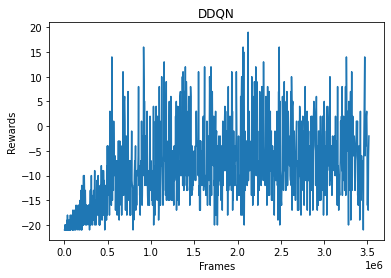

Episode:  1071
Steps:  878552  epsilon:  0.03
Steps:  878752  epsilon:  0.03
Steps:  878952  epsilon:  0.03
Steps:  879152  epsilon:  0.03
Steps:  879352  epsilon:  0.03
Steps:  879552  epsilon:  0.03
Episode:  1072
Steps:  879560  epsilon:  0.03
Steps:  879760  epsilon:  0.03
Steps:  879960  epsilon:  0.03
Steps:  880160  epsilon:  0.03
Steps:  880360  epsilon:  0.03
Episode:  1073
Steps:  880373  epsilon:  0.03
Steps:  880573  epsilon:  0.03
Steps:  880773  epsilon:  0.03
Steps:  880973  epsilon:  0.03
Episode:  1074
Steps:  881169  epsilon:  0.03
Steps:  881369  epsilon:  0.03
Steps:  881569  epsilon:  0.03
Steps:  881769  epsilon:  0.03
Steps:  881969  epsilon:  0.03
Steps:  882169  epsilon:  0.03
Episode:  1075
Steps:  882206  epsilon:  0.03
Steps:  882406  epsilon:  0.03
Steps:  882606  epsilon:  0.03
Steps:  882806  epsilon:  0.03
Steps:  883006  epsilon:  0.03
Episode:  1076
Steps:  883073  epsilon:  0.03
Steps:  883273  epsilon:  0.03
Steps:  883473  epsilon:  0.03
Steps:  883

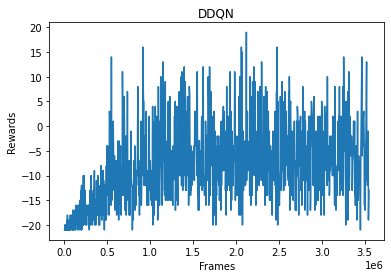

Episode:  1081
Steps:  887147  epsilon:  0.03
Steps:  887347  epsilon:  0.03
Steps:  887547  epsilon:  0.03
Steps:  887747  epsilon:  0.03
Steps:  887947  epsilon:  0.03
Steps:  888147  epsilon:  0.03
Episode:  1082
Steps:  888192  epsilon:  0.03
Steps:  888392  epsilon:  0.03
Steps:  888592  epsilon:  0.03
Steps:  888792  epsilon:  0.03
Episode:  1083
Steps:  888963  epsilon:  0.03
Steps:  889163  epsilon:  0.03
Steps:  889363  epsilon:  0.03
Steps:  889563  epsilon:  0.03
Steps:  889763  epsilon:  0.03
Episode:  1084
Steps:  889933  epsilon:  0.03
Steps:  890133  epsilon:  0.03
Steps:  890333  epsilon:  0.03
Steps:  890533  epsilon:  0.03
Steps:  890733  epsilon:  0.03
Steps:  890933  epsilon:  0.03
Episode:  1085
Steps:  890971  epsilon:  0.03
Steps:  891171  epsilon:  0.03
Steps:  891371  epsilon:  0.03
Steps:  891571  epsilon:  0.03
Steps:  891771  epsilon:  0.03
Episode:  1086
Steps:  891906  epsilon:  0.03
Steps:  892106  epsilon:  0.03
Steps:  892306  epsilon:  0.03
Steps:  892

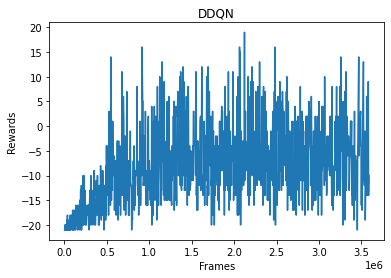

Episode:  1091
Steps:  896509  epsilon:  0.03
Steps:  896709  epsilon:  0.03
Steps:  896909  epsilon:  0.03
Steps:  897109  epsilon:  0.03
Steps:  897309  epsilon:  0.03
Episode:  1092
Steps:  897384  epsilon:  0.03
Steps:  897584  epsilon:  0.03
Steps:  897784  epsilon:  0.03
Steps:  897984  epsilon:  0.03
Steps:  898184  epsilon:  0.03
Steps:  898384  epsilon:  0.03
Episode:  1093
Steps:  898455  epsilon:  0.03
Steps:  898655  epsilon:  0.03
Steps:  898855  epsilon:  0.03
Steps:  899055  epsilon:  0.03
Steps:  899255  epsilon:  0.03
Steps:  899455  epsilon:  0.03
Episode:  1094
Steps:  899526  epsilon:  0.03
Steps:  899726  epsilon:  0.03
Steps:  899926  epsilon:  0.03
Steps:  900126  epsilon:  0.03
Episode:  1095
Steps:  900131  epsilon:  0.03
Steps:  900331  epsilon:  0.03
Steps:  900531  epsilon:  0.03
Steps:  900731  epsilon:  0.03
Episode:  1096
Steps:  900811  epsilon:  0.03
Steps:  901011  epsilon:  0.03
Steps:  901211  epsilon:  0.03
Steps:  901411  epsilon:  0.03
Steps:  901

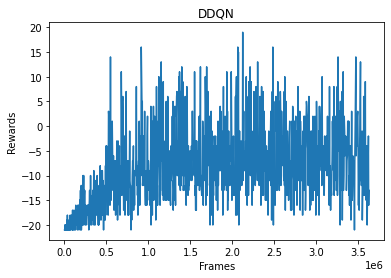

Episode:  1101
Steps:  905379  epsilon:  0.03
Steps:  905579  epsilon:  0.03
Steps:  905779  epsilon:  0.03
Steps:  905979  epsilon:  0.03
Episode:  1102
Steps:  906143  epsilon:  0.03
Steps:  906343  epsilon:  0.03
Steps:  906543  epsilon:  0.03
Steps:  906743  epsilon:  0.03
Steps:  906943  epsilon:  0.03
Episode:  1103
Steps:  906992  epsilon:  0.03
Steps:  907192  epsilon:  0.03
Steps:  907392  epsilon:  0.03
Steps:  907592  epsilon:  0.03
Steps:  907792  epsilon:  0.03
Steps:  907992  epsilon:  0.03
Episode:  1104
Steps:  908114  epsilon:  0.03
Steps:  908314  epsilon:  0.03
Steps:  908514  epsilon:  0.03
Steps:  908714  epsilon:  0.03
Steps:  908914  epsilon:  0.03
Steps:  909114  epsilon:  0.03
Episode:  1105
Steps:  909242  epsilon:  0.03
Steps:  909442  epsilon:  0.03
Steps:  909642  epsilon:  0.03
Steps:  909842  epsilon:  0.03
Steps:  910042  epsilon:  0.03
Steps:  910242  epsilon:  0.03
Episode:  1106
Steps:  910299  epsilon:  0.03
Steps:  910499  epsilon:  0.03
Steps:  910

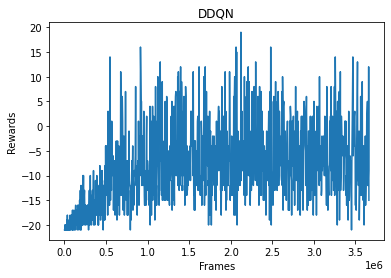

Episode:  1111
Steps:  914673  epsilon:  0.03
Steps:  914873  epsilon:  0.03
Steps:  915073  epsilon:  0.03
Steps:  915273  epsilon:  0.03
Steps:  915473  epsilon:  0.03
Steps:  915673  epsilon:  0.03
Episode:  1112
Steps:  915785  epsilon:  0.03
Steps:  915985  epsilon:  0.03
Steps:  916185  epsilon:  0.03
Steps:  916385  epsilon:  0.03
Episode:  1113
Steps:  916470  epsilon:  0.03
Steps:  916670  epsilon:  0.03
Steps:  916870  epsilon:  0.03
Steps:  917070  epsilon:  0.03
Episode:  1114
Steps:  917201  epsilon:  0.03
Steps:  917401  epsilon:  0.03
Steps:  917601  epsilon:  0.03
Steps:  917801  epsilon:  0.03
Steps:  918001  epsilon:  0.03
Steps:  918201  epsilon:  0.03
Episode:  1115
Steps:  918269  epsilon:  0.03
Steps:  918469  epsilon:  0.03
Steps:  918669  epsilon:  0.03
Steps:  918869  epsilon:  0.03
Steps:  919069  epsilon:  0.03
Episode:  1116
Steps:  919126  epsilon:  0.03
Steps:  919326  epsilon:  0.03
Steps:  919526  epsilon:  0.03
Steps:  919726  epsilon:  0.03
Steps:  919

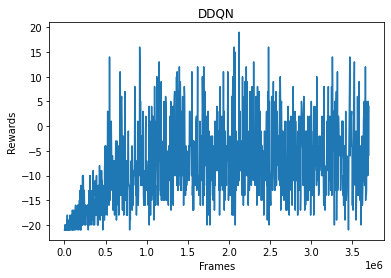

Episode:  1121
Steps:  924486  epsilon:  0.03
Steps:  924686  epsilon:  0.03
Steps:  924886  epsilon:  0.03
Steps:  925086  epsilon:  0.03
Steps:  925286  epsilon:  0.03
Steps:  925486  epsilon:  0.03
Episode:  1122
Steps:  925566  epsilon:  0.03
Steps:  925766  epsilon:  0.03
Steps:  925966  epsilon:  0.03
Steps:  926166  epsilon:  0.03
Episode:  1123
Steps:  926319  epsilon:  0.03
Steps:  926519  epsilon:  0.03
Steps:  926719  epsilon:  0.03
Steps:  926919  epsilon:  0.03
Steps:  927119  epsilon:  0.03
Steps:  927319  epsilon:  0.03
Episode:  1124
Steps:  927508  epsilon:  0.03
Steps:  927708  epsilon:  0.03
Steps:  927908  epsilon:  0.03
Steps:  928108  epsilon:  0.03
Steps:  928308  epsilon:  0.03
Episode:  1125
Steps:  928456  epsilon:  0.03
Steps:  928656  epsilon:  0.03
Steps:  928856  epsilon:  0.03
Steps:  929056  epsilon:  0.03
Steps:  929256  epsilon:  0.03
Episode:  1126
Steps:  929342  epsilon:  0.03
Steps:  929542  epsilon:  0.03
Steps:  929742  epsilon:  0.03
Steps:  929

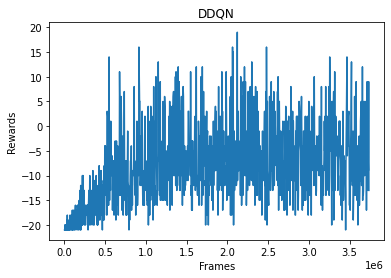

Episode:  1131
Steps:  933795  epsilon:  0.03
Steps:  933995  epsilon:  0.03
Steps:  934195  epsilon:  0.03
Steps:  934395  epsilon:  0.03
Episode:  1132
Steps:  934557  epsilon:  0.03
Steps:  934757  epsilon:  0.03
Steps:  934957  epsilon:  0.03
Steps:  935157  epsilon:  0.03
Steps:  935357  epsilon:  0.03
Episode:  1133
Steps:  935368  epsilon:  0.03
Steps:  935568  epsilon:  0.03
Steps:  935768  epsilon:  0.03
Steps:  935968  epsilon:  0.03
Steps:  936168  epsilon:  0.03
Steps:  936368  epsilon:  0.03
Episode:  1134
Steps:  936496  epsilon:  0.03
Steps:  936696  epsilon:  0.03
Steps:  936896  epsilon:  0.03
Steps:  937096  epsilon:  0.03
Steps:  937296  epsilon:  0.03
Episode:  1135
Steps:  937464  epsilon:  0.03
Steps:  937664  epsilon:  0.03
Steps:  937864  epsilon:  0.03
Steps:  938064  epsilon:  0.03
Steps:  938264  epsilon:  0.03
Episode:  1136
Steps:  938351  epsilon:  0.03
Steps:  938551  epsilon:  0.03
Steps:  938751  epsilon:  0.03
Steps:  938951  epsilon:  0.03
Steps:  939

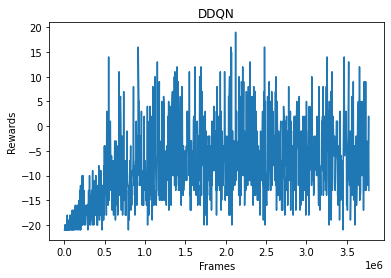

Episode:  1141
Steps:  943049  epsilon:  0.03
Steps:  943249  epsilon:  0.03
Steps:  943449  epsilon:  0.03
Steps:  943649  epsilon:  0.03
Steps:  943849  epsilon:  0.03
Episode:  1142
Steps:  943942  epsilon:  0.03
Steps:  944142  epsilon:  0.03
Steps:  944342  epsilon:  0.03
Steps:  944542  epsilon:  0.03
Steps:  944742  epsilon:  0.03
Episode:  1143
Steps:  944861  epsilon:  0.03
Steps:  945061  epsilon:  0.03
Steps:  945261  epsilon:  0.03
Steps:  945461  epsilon:  0.03
Steps:  945661  epsilon:  0.03
Steps:  945861  epsilon:  0.03
Episode:  1144
Steps:  945973  epsilon:  0.03
Steps:  946173  epsilon:  0.03
Steps:  946373  epsilon:  0.03
Steps:  946573  epsilon:  0.03
Steps:  946773  epsilon:  0.03
Steps:  946973  epsilon:  0.03
Steps:  947173  epsilon:  0.03
Episode:  1145
Steps:  947201  epsilon:  0.03
Steps:  947401  epsilon:  0.03
Steps:  947601  epsilon:  0.03
Steps:  947801  epsilon:  0.03
Steps:  948001  epsilon:  0.03
Episode:  1146
Steps:  948072  epsilon:  0.03
Steps:  948

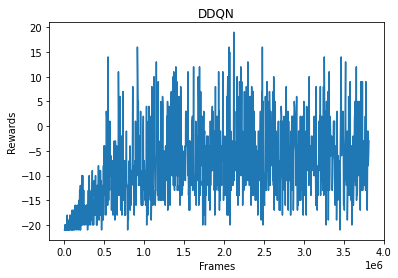

Episode:  1151
Steps:  953345  epsilon:  0.03
Steps:  953545  epsilon:  0.03
Steps:  953745  epsilon:  0.03
Steps:  953945  epsilon:  0.03
Steps:  954145  epsilon:  0.03
Episode:  1152
Steps:  954345  epsilon:  0.03
Steps:  954545  epsilon:  0.03
Steps:  954745  epsilon:  0.03
Steps:  954945  epsilon:  0.03
Steps:  955145  epsilon:  0.03
Steps:  955345  epsilon:  0.03
Episode:  1153
Steps:  955435  epsilon:  0.03
Steps:  955635  epsilon:  0.03
Steps:  955835  epsilon:  0.03
Steps:  956035  epsilon:  0.03
Steps:  956235  epsilon:  0.03
Steps:  956435  epsilon:  0.03
Steps:  956635  epsilon:  0.03
Episode:  1154
Steps:  956694  epsilon:  0.03
Steps:  956894  epsilon:  0.03
Steps:  957094  epsilon:  0.03
Steps:  957294  epsilon:  0.03
Steps:  957494  epsilon:  0.03
Episode:  1155
Steps:  957678  epsilon:  0.03
Steps:  957878  epsilon:  0.03
Steps:  958078  epsilon:  0.03
Steps:  958278  epsilon:  0.03
Steps:  958478  epsilon:  0.03
Steps:  958678  epsilon:  0.03
Steps:  958878  epsilon:  

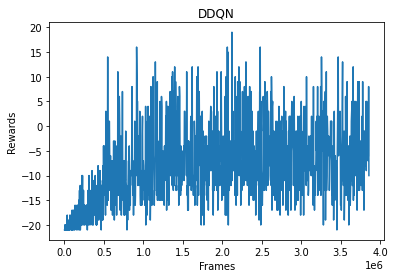

Episode:  1161
Steps:  963719  epsilon:  0.03
Steps:  963919  epsilon:  0.03
Steps:  964119  epsilon:  0.03
Steps:  964319  epsilon:  0.03
Steps:  964519  epsilon:  0.03
Episode:  1162
Steps:  964713  epsilon:  0.03
Steps:  964913  epsilon:  0.03
Steps:  965113  epsilon:  0.03
Episode:  1163
Steps:  965144  epsilon:  0.03
Steps:  965344  epsilon:  0.03
Steps:  965544  epsilon:  0.03
Steps:  965744  epsilon:  0.03
Steps:  965944  epsilon:  0.03
Episode:  1164
Steps:  966108  epsilon:  0.03
Steps:  966308  epsilon:  0.03
Steps:  966508  epsilon:  0.03
Steps:  966708  epsilon:  0.03
Episode:  1165
Steps:  966897  epsilon:  0.03
Steps:  967097  epsilon:  0.03
Steps:  967297  epsilon:  0.03
Steps:  967497  epsilon:  0.03
Episode:  1166
Steps:  967676  epsilon:  0.03
Steps:  967876  epsilon:  0.03
Steps:  968076  epsilon:  0.03
Episode:  1167
Steps:  968249  epsilon:  0.03
Steps:  968449  epsilon:  0.03
Steps:  968649  epsilon:  0.03
Steps:  968849  epsilon:  0.03
Steps:  969049  epsilon:  0

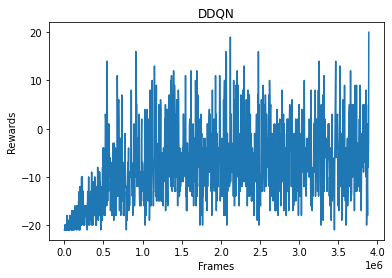

Episode:  1171
Steps:  972159  epsilon:  0.03
Steps:  972359  epsilon:  0.03
Steps:  972559  epsilon:  0.03
Steps:  972759  epsilon:  0.03
Steps:  972959  epsilon:  0.03
Steps:  973159  epsilon:  0.03
Episode:  1172
Steps:  973250  epsilon:  0.03
Steps:  973450  epsilon:  0.03
Steps:  973650  epsilon:  0.03
Steps:  973850  epsilon:  0.03
Steps:  974050  epsilon:  0.03
Steps:  974250  epsilon:  0.03
Episode:  1173
Steps:  974263  epsilon:  0.03
Steps:  974463  epsilon:  0.03
Steps:  974663  epsilon:  0.03
Steps:  974863  epsilon:  0.03
Steps:  975063  epsilon:  0.03
Steps:  975263  epsilon:  0.03
Episode:  1174
Steps:  975378  epsilon:  0.03
Steps:  975578  epsilon:  0.03
Steps:  975778  epsilon:  0.03
Steps:  975978  epsilon:  0.03
Episode:  1175
Steps:  976111  epsilon:  0.03
Steps:  976311  epsilon:  0.03
Steps:  976511  epsilon:  0.03
Steps:  976711  epsilon:  0.03
Steps:  976911  epsilon:  0.03
Steps:  977111  epsilon:  0.03
Episode:  1176
Steps:  977216  epsilon:  0.03
Steps:  977

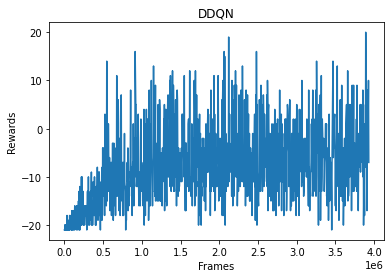

Episode:  1181
Steps:  982010  epsilon:  0.03
Steps:  982210  epsilon:  0.03
Steps:  982410  epsilon:  0.03
Steps:  982610  epsilon:  0.03
Steps:  982810  epsilon:  0.03
Steps:  983010  epsilon:  0.03
Episode:  1182
Steps:  983084  epsilon:  0.03
Steps:  983284  epsilon:  0.03
Steps:  983484  epsilon:  0.03
Steps:  983684  epsilon:  0.03
Episode:  1183
Steps:  983777  epsilon:  0.03
Steps:  983977  epsilon:  0.03
Steps:  984177  epsilon:  0.03
Episode:  1184
Steps:  984313  epsilon:  0.03
Steps:  984513  epsilon:  0.03
Steps:  984713  epsilon:  0.03
Steps:  984913  epsilon:  0.03
Steps:  985113  epsilon:  0.03
Steps:  985313  epsilon:  0.03
Episode:  1185
Steps:  985361  epsilon:  0.03
Steps:  985561  epsilon:  0.03
Steps:  985761  epsilon:  0.03
Steps:  985961  epsilon:  0.03
Steps:  986161  epsilon:  0.03
Steps:  986361  epsilon:  0.03
Steps:  986561  epsilon:  0.03
Episode:  1186
Steps:  986683  epsilon:  0.03
Steps:  986883  epsilon:  0.03
Steps:  987083  epsilon:  0.03
Steps:  987

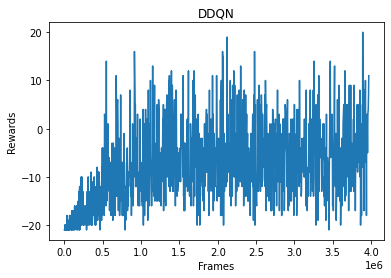

Episode:  1191
Steps:  991917  epsilon:  0.03
Steps:  992117  epsilon:  0.03
Steps:  992317  epsilon:  0.03
Steps:  992517  epsilon:  0.03
Steps:  992717  epsilon:  0.03
Steps:  992917  epsilon:  0.03
Episode:  1192
Steps:  992959  epsilon:  0.03
Steps:  993159  epsilon:  0.03
Steps:  993359  epsilon:  0.03
Steps:  993559  epsilon:  0.03
Steps:  993759  epsilon:  0.03
Episode:  1193
Steps:  993913  epsilon:  0.03
Steps:  994113  epsilon:  0.03
Steps:  994313  epsilon:  0.03
Steps:  994513  epsilon:  0.03
Steps:  994713  epsilon:  0.03
Episode:  1194
Steps:  994726  epsilon:  0.03
Steps:  994926  epsilon:  0.03
Steps:  995126  epsilon:  0.03
Steps:  995326  epsilon:  0.03
Steps:  995526  epsilon:  0.03
Steps:  995726  epsilon:  0.03
Episode:  1195
Steps:  995883  epsilon:  0.03
Steps:  996083  epsilon:  0.03
Steps:  996283  epsilon:  0.03
Steps:  996483  epsilon:  0.03
Steps:  996683  epsilon:  0.03
Episode:  1196
Steps:  996874  epsilon:  0.03
Steps:  997074  epsilon:  0.03
Steps:  997

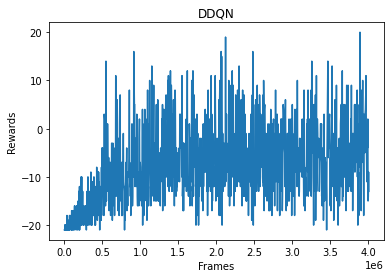

Episode:  1201
Steps:  1001059  epsilon:  0.03
Steps:  1001259  epsilon:  0.03
Steps:  1001459  epsilon:  0.03
Steps:  1001659  epsilon:  0.03
Steps:  1001859  epsilon:  0.03
Steps:  1002059  epsilon:  0.03
Episode:  1202
Steps:  1002160  epsilon:  0.03
Steps:  1002360  epsilon:  0.03
Steps:  1002560  epsilon:  0.03
Steps:  1002760  epsilon:  0.03
Steps:  1002960  epsilon:  0.03
Episode:  1203
Steps:  1002979  epsilon:  0.03
Steps:  1003179  epsilon:  0.03
Steps:  1003379  epsilon:  0.03
Steps:  1003579  epsilon:  0.03
Steps:  1003779  epsilon:  0.03
Steps:  1003979  epsilon:  0.03
Steps:  1004179  epsilon:  0.03
Steps:  1004379  epsilon:  0.03
Episode:  1204
Steps:  1004384  epsilon:  0.03
Steps:  1004584  epsilon:  0.03
Steps:  1004784  epsilon:  0.03
Steps:  1004984  epsilon:  0.03
Episode:  1205
Steps:  1005097  epsilon:  0.03
Steps:  1005297  epsilon:  0.03
Steps:  1005497  epsilon:  0.03
Steps:  1005697  epsilon:  0.03
Steps:  1005897  epsilon:  0.03
Episode:  1206
Steps:  100609

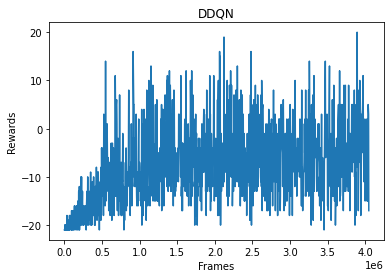

Episode:  1211
Steps:  1010867  epsilon:  0.03
Steps:  1011067  epsilon:  0.03
Steps:  1011267  epsilon:  0.03
Steps:  1011467  epsilon:  0.03
Steps:  1011667  epsilon:  0.03
Steps:  1011867  epsilon:  0.03
Steps:  1012067  epsilon:  0.03
Episode:  1212
Steps:  1012134  epsilon:  0.03
Steps:  1012334  epsilon:  0.03
Steps:  1012534  epsilon:  0.03
Steps:  1012734  epsilon:  0.03
Episode:  1213
Steps:  1012797  epsilon:  0.03
Steps:  1012997  epsilon:  0.03
Steps:  1013197  epsilon:  0.03
Steps:  1013397  epsilon:  0.03
Episode:  1214
Steps:  1013426  epsilon:  0.03
Steps:  1013626  epsilon:  0.03
Steps:  1013826  epsilon:  0.03
Steps:  1014026  epsilon:  0.03
Steps:  1014226  epsilon:  0.03
Episode:  1215
Steps:  1014352  epsilon:  0.03
Steps:  1014552  epsilon:  0.03
Steps:  1014752  epsilon:  0.03
Steps:  1014952  epsilon:  0.03
Steps:  1015152  epsilon:  0.03
Episode:  1216
Steps:  1015209  epsilon:  0.03
Steps:  1015409  epsilon:  0.03
Steps:  1015609  epsilon:  0.03
Steps:  101580

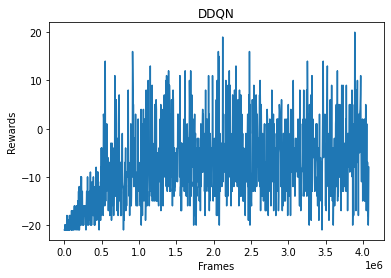

Episode:  1221
Steps:  1019038  epsilon:  0.03
Steps:  1019238  epsilon:  0.03
Steps:  1019438  epsilon:  0.03
Episode:  1222
Steps:  1019563  epsilon:  0.03
Steps:  1019763  epsilon:  0.03
Steps:  1019963  epsilon:  0.03
Steps:  1020163  epsilon:  0.03
Episode:  1223
Steps:  1020207  epsilon:  0.03
Steps:  1020407  epsilon:  0.03
Steps:  1020607  epsilon:  0.03
Steps:  1020807  epsilon:  0.03
Steps:  1021007  epsilon:  0.03
Episode:  1224
Steps:  1021170  epsilon:  0.03
Steps:  1021370  epsilon:  0.03
Steps:  1021570  epsilon:  0.03
Steps:  1021770  epsilon:  0.03
Steps:  1021970  epsilon:  0.03
Episode:  1225
Steps:  1022094  epsilon:  0.03
Steps:  1022294  epsilon:  0.03
Steps:  1022494  epsilon:  0.03
Steps:  1022694  epsilon:  0.03
Episode:  1226
Steps:  1022870  epsilon:  0.03
Steps:  1023070  epsilon:  0.03
Steps:  1023270  epsilon:  0.03
Steps:  1023470  epsilon:  0.03
Steps:  1023670  epsilon:  0.03
Steps:  1023870  epsilon:  0.03
Episode:  1227
Steps:  1023952  epsilon:  0.03

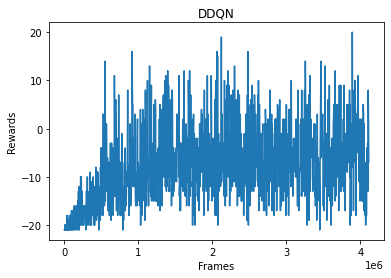

Episode:  1231
Steps:  1027823  epsilon:  0.03
Steps:  1028023  epsilon:  0.03
Steps:  1028223  epsilon:  0.03
Episode:  1232
Steps:  1028402  epsilon:  0.03
Steps:  1028602  epsilon:  0.03
Steps:  1028802  epsilon:  0.03
Steps:  1029002  epsilon:  0.03
Steps:  1029202  epsilon:  0.03
Episode:  1233
Steps:  1029263  epsilon:  0.03
Steps:  1029463  epsilon:  0.03
Steps:  1029663  epsilon:  0.03
Steps:  1029863  epsilon:  0.03
Steps:  1030063  epsilon:  0.03
Episode:  1234
Steps:  1030195  epsilon:  0.03
Steps:  1030395  epsilon:  0.03
Steps:  1030595  epsilon:  0.03
Steps:  1030795  epsilon:  0.03
Steps:  1030995  epsilon:  0.03
Episode:  1235
Steps:  1031172  epsilon:  0.03
Steps:  1031372  epsilon:  0.03
Steps:  1031572  epsilon:  0.03
Steps:  1031772  epsilon:  0.03
Steps:  1031972  epsilon:  0.03
Episode:  1236
Steps:  1032056  epsilon:  0.03
Steps:  1032256  epsilon:  0.03
Steps:  1032456  epsilon:  0.03
Steps:  1032656  epsilon:  0.03
Steps:  1032856  epsilon:  0.03
Steps:  103305

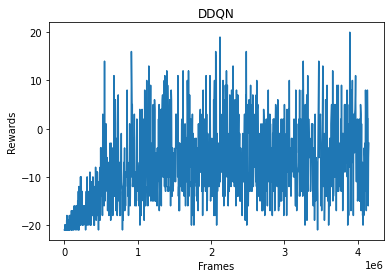

Episode:  1241
Steps:  1036853  epsilon:  0.03
Steps:  1037053  epsilon:  0.03
Steps:  1037253  epsilon:  0.03
Steps:  1037453  epsilon:  0.03
Steps:  1037653  epsilon:  0.03
Steps:  1037853  epsilon:  0.03
Episode:  1242
Steps:  1037877  epsilon:  0.03
Steps:  1038077  epsilon:  0.03
Steps:  1038277  epsilon:  0.03
Steps:  1038477  epsilon:  0.03
Steps:  1038677  epsilon:  0.03
Episode:  1243
Steps:  1038779  epsilon:  0.03
Steps:  1038979  epsilon:  0.03
Steps:  1039179  epsilon:  0.03
Steps:  1039379  epsilon:  0.03
Steps:  1039579  epsilon:  0.03
Steps:  1039779  epsilon:  0.03
Episode:  1244
Steps:  1039840  epsilon:  0.03
Steps:  1040040  epsilon:  0.03
Steps:  1040240  epsilon:  0.03
Steps:  1040440  epsilon:  0.03
Steps:  1040640  epsilon:  0.03
Steps:  1040840  epsilon:  0.03
Episode:  1245
Steps:  1040991  epsilon:  0.03
Steps:  1041191  epsilon:  0.03
Steps:  1041391  epsilon:  0.03
Steps:  1041591  epsilon:  0.03
Steps:  1041791  epsilon:  0.03
Episode:  1246
Steps:  104197

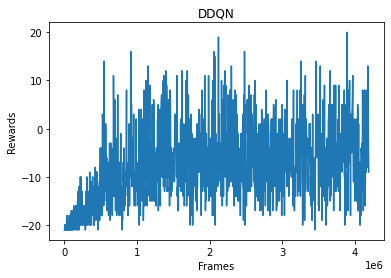

Episode:  1251
Steps:  1047150  epsilon:  0.03
Steps:  1047350  epsilon:  0.03
Steps:  1047550  epsilon:  0.03
Steps:  1047750  epsilon:  0.03
Steps:  1047950  epsilon:  0.03
Episode:  1252
Steps:  1047992  epsilon:  0.03
Steps:  1048192  epsilon:  0.03
Steps:  1048392  epsilon:  0.03
Episode:  1253
Steps:  1048587  epsilon:  0.03
Steps:  1048787  epsilon:  0.03
Steps:  1048987  epsilon:  0.03
Steps:  1049187  epsilon:  0.03
Steps:  1049387  epsilon:  0.03
Steps:  1049587  epsilon:  0.03
Episode:  1254
Steps:  1049664  epsilon:  0.03
Steps:  1049864  epsilon:  0.03
Steps:  1050064  epsilon:  0.03
Steps:  1050264  epsilon:  0.03
Episode:  1255
Steps:  1050350  epsilon:  0.03
Steps:  1050550  epsilon:  0.03
Steps:  1050750  epsilon:  0.03
Steps:  1050950  epsilon:  0.03
Steps:  1051150  epsilon:  0.03
Episode:  1256
Steps:  1051207  epsilon:  0.03
Steps:  1051407  epsilon:  0.03
Steps:  1051607  epsilon:  0.03
Steps:  1051807  epsilon:  0.03
Episode:  1257
Steps:  1051835  epsilon:  0.03

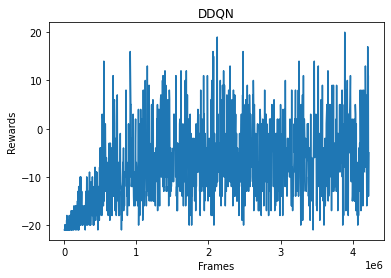

Episode:  1261
Steps:  1055475  epsilon:  0.03
Steps:  1055675  epsilon:  0.03
Steps:  1055875  epsilon:  0.03
Steps:  1056075  epsilon:  0.03
Steps:  1056275  epsilon:  0.03
Steps:  1056475  epsilon:  0.03
Episode:  1262
Steps:  1056501  epsilon:  0.03
Steps:  1056701  epsilon:  0.03
Steps:  1056901  epsilon:  0.03
Steps:  1057101  epsilon:  0.03
Steps:  1057301  epsilon:  0.03
Episode:  1263
Steps:  1057451  epsilon:  0.03
Steps:  1057651  epsilon:  0.03
Steps:  1057851  epsilon:  0.03
Steps:  1058051  epsilon:  0.03
Steps:  1058251  epsilon:  0.03
Steps:  1058451  epsilon:  0.03
Episode:  1264
Steps:  1058627  epsilon:  0.03
Steps:  1058827  epsilon:  0.03
Steps:  1059027  epsilon:  0.03
Steps:  1059227  epsilon:  0.03
Steps:  1059427  epsilon:  0.03
Steps:  1059627  epsilon:  0.03
Steps:  1059827  epsilon:  0.03
Episode:  1265
Steps:  1059869  epsilon:  0.03
Steps:  1060069  epsilon:  0.03
Steps:  1060269  epsilon:  0.03
Steps:  1060469  epsilon:  0.03
Steps:  1060669  epsilon:  0.

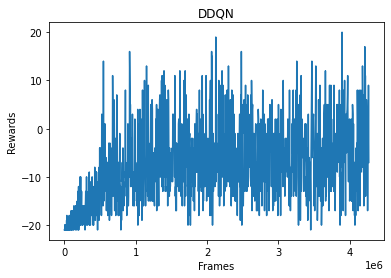

Episode:  1271
Steps:  1065738  epsilon:  0.03
Steps:  1065938  epsilon:  0.03
Steps:  1066138  epsilon:  0.03
Steps:  1066338  epsilon:  0.03
Episode:  1272
Steps:  1066530  epsilon:  0.03
Steps:  1066730  epsilon:  0.03
Steps:  1066930  epsilon:  0.03
Steps:  1067130  epsilon:  0.03
Episode:  1273
Steps:  1067307  epsilon:  0.03
Steps:  1067507  epsilon:  0.03
Steps:  1067707  epsilon:  0.03
Steps:  1067907  epsilon:  0.03
Episode:  1274
Steps:  1068093  epsilon:  0.03
Steps:  1068293  epsilon:  0.03
Steps:  1068493  epsilon:  0.03
Steps:  1068693  epsilon:  0.03
Steps:  1068893  epsilon:  0.03
Episode:  1275
Steps:  1069006  epsilon:  0.03
Steps:  1069206  epsilon:  0.03
Steps:  1069406  epsilon:  0.03
Steps:  1069606  epsilon:  0.03
Steps:  1069806  epsilon:  0.03
Episode:  1276
Steps:  1069823  epsilon:  0.03
Steps:  1070023  epsilon:  0.03
Steps:  1070223  epsilon:  0.03
Steps:  1070423  epsilon:  0.03
Steps:  1070623  epsilon:  0.03
Episode:  1277
Steps:  1070810  epsilon:  0.03

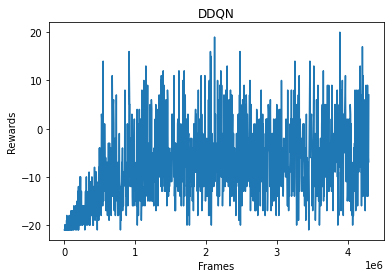

Episode:  1281
Steps:  1074288  epsilon:  0.03
Steps:  1074488  epsilon:  0.03
Steps:  1074688  epsilon:  0.03
Steps:  1074888  epsilon:  0.03
Episode:  1282
Steps:  1074935  epsilon:  0.03
Steps:  1075135  epsilon:  0.03
Steps:  1075335  epsilon:  0.03
Steps:  1075535  epsilon:  0.03
Episode:  1283
Steps:  1075710  epsilon:  0.03
Steps:  1075910  epsilon:  0.03
Steps:  1076110  epsilon:  0.03
Steps:  1076310  epsilon:  0.03
Steps:  1076510  epsilon:  0.03
Episode:  1284
Steps:  1076623  epsilon:  0.03
Steps:  1076823  epsilon:  0.03
Steps:  1077023  epsilon:  0.03
Steps:  1077223  epsilon:  0.03
Steps:  1077423  epsilon:  0.03
Episode:  1285
Steps:  1077591  epsilon:  0.03
Steps:  1077791  epsilon:  0.03
Steps:  1077991  epsilon:  0.03
Steps:  1078191  epsilon:  0.03
Steps:  1078391  epsilon:  0.03
Steps:  1078591  epsilon:  0.03
Episode:  1286
Steps:  1078643  epsilon:  0.03
Steps:  1078843  epsilon:  0.03
Steps:  1079043  epsilon:  0.03
Steps:  1079243  epsilon:  0.03
Steps:  107944

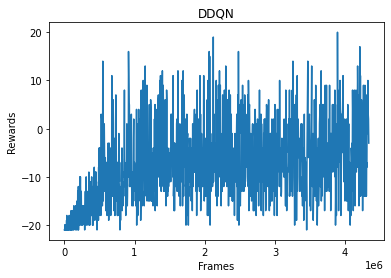

Episode:  1291
Steps:  1083549  epsilon:  0.03
Steps:  1083749  epsilon:  0.03
Steps:  1083949  epsilon:  0.03
Steps:  1084149  epsilon:  0.03
Episode:  1292
Steps:  1084334  epsilon:  0.03
Steps:  1084534  epsilon:  0.03
Steps:  1084734  epsilon:  0.03
Steps:  1084934  epsilon:  0.03
Episode:  1293
Steps:  1085125  epsilon:  0.03
Steps:  1085325  epsilon:  0.03
Steps:  1085525  epsilon:  0.03
Steps:  1085725  epsilon:  0.03
Steps:  1085925  epsilon:  0.03
Episode:  1294
Steps:  1086090  epsilon:  0.03
Steps:  1086290  epsilon:  0.03
Steps:  1086490  epsilon:  0.03
Steps:  1086690  epsilon:  0.03
Steps:  1086890  epsilon:  0.03
Episode:  1295
Steps:  1086928  epsilon:  0.03
Steps:  1087128  epsilon:  0.03
Steps:  1087328  epsilon:  0.03
Steps:  1087528  epsilon:  0.03
Steps:  1087728  epsilon:  0.03
Steps:  1087928  epsilon:  0.03
Episode:  1296
Steps:  1087990  epsilon:  0.03
Steps:  1088190  epsilon:  0.03
Steps:  1088390  epsilon:  0.03
Steps:  1088590  epsilon:  0.03
Steps:  108879

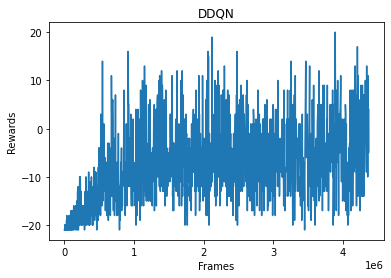

Episode:  1301
Steps:  1092710  epsilon:  0.03
Steps:  1092910  epsilon:  0.03
Steps:  1093110  epsilon:  0.03
Steps:  1093310  epsilon:  0.03
Episode:  1302
Steps:  1093447  epsilon:  0.03
Steps:  1093647  epsilon:  0.03
Steps:  1093847  epsilon:  0.03
Steps:  1094047  epsilon:  0.03
Episode:  1303
Steps:  1094247  epsilon:  0.03
Steps:  1094447  epsilon:  0.03
Steps:  1094647  epsilon:  0.03
Steps:  1094847  epsilon:  0.03
Steps:  1095047  epsilon:  0.03
Episode:  1304
Steps:  1095141  epsilon:  0.03
Steps:  1095341  epsilon:  0.03
Steps:  1095541  epsilon:  0.03
Steps:  1095741  epsilon:  0.03
Steps:  1095941  epsilon:  0.03
Episode:  1305
Steps:  1096066  epsilon:  0.03
Steps:  1096266  epsilon:  0.03
Steps:  1096466  epsilon:  0.03
Steps:  1096666  epsilon:  0.03
Steps:  1096866  epsilon:  0.03
Episode:  1306
Steps:  1096972  epsilon:  0.03
Steps:  1097172  epsilon:  0.03
Steps:  1097372  epsilon:  0.03
Steps:  1097572  epsilon:  0.03
Steps:  1097772  epsilon:  0.03
Episode:  1307

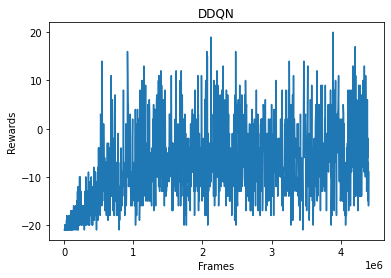

Episode:  1311
Steps:  1101178  epsilon:  0.03
Steps:  1101378  epsilon:  0.03
Steps:  1101578  epsilon:  0.03
Steps:  1101778  epsilon:  0.03
Steps:  1101978  epsilon:  0.03
Episode:  1312
Steps:  1102083  epsilon:  0.03
Steps:  1102283  epsilon:  0.03
Steps:  1102483  epsilon:  0.03
Steps:  1102683  epsilon:  0.03
Steps:  1102883  epsilon:  0.03
Steps:  1103083  epsilon:  0.03
Steps:  1103283  epsilon:  0.03
Episode:  1313
Steps:  1103320  epsilon:  0.03
Steps:  1103520  epsilon:  0.03
Steps:  1103720  epsilon:  0.03
Steps:  1103920  epsilon:  0.03
Steps:  1104120  epsilon:  0.03
Episode:  1314
Steps:  1104317  epsilon:  0.03
Steps:  1104517  epsilon:  0.03
Steps:  1104717  epsilon:  0.03
Steps:  1104917  epsilon:  0.03
Steps:  1105117  epsilon:  0.03
Episode:  1315
Steps:  1105292  epsilon:  0.03
Steps:  1105492  epsilon:  0.03
Steps:  1105692  epsilon:  0.03
Steps:  1105892  epsilon:  0.03
Steps:  1106092  epsilon:  0.03
Steps:  1106292  epsilon:  0.03
Episode:  1316
Steps:  110633

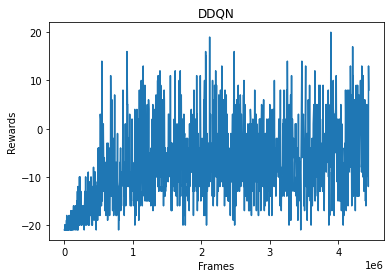

Episode:  1321
Steps:  1110687  epsilon:  0.03
Steps:  1110887  epsilon:  0.03
Steps:  1111087  epsilon:  0.03
Steps:  1111287  epsilon:  0.03
Steps:  1111487  epsilon:  0.03
Steps:  1111687  epsilon:  0.03
Episode:  1322
Steps:  1111799  epsilon:  0.03
Steps:  1111999  epsilon:  0.03
Steps:  1112199  epsilon:  0.03
Steps:  1112399  epsilon:  0.03
Steps:  1112599  epsilon:  0.03
Steps:  1112799  epsilon:  0.03
Steps:  1112999  epsilon:  0.03
Episode:  1323
Steps:  1113032  epsilon:  0.03
Steps:  1113232  epsilon:  0.03
Steps:  1113432  epsilon:  0.03
Episode:  1324
Steps:  1113510  epsilon:  0.03
Steps:  1113710  epsilon:  0.03
Steps:  1113910  epsilon:  0.03
Steps:  1114110  epsilon:  0.03
Steps:  1114310  epsilon:  0.03
Steps:  1114510  epsilon:  0.03
Episode:  1325
Steps:  1114576  epsilon:  0.03
Steps:  1114776  epsilon:  0.03
Steps:  1114976  epsilon:  0.03
Steps:  1115176  epsilon:  0.03
Steps:  1115376  epsilon:  0.03
Episode:  1326
Steps:  1115528  epsilon:  0.03
Steps:  111572

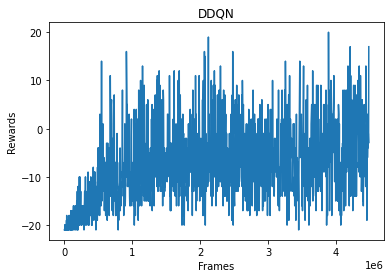

Episode:  1331
Steps:  1120382  epsilon:  0.03
Steps:  1120582  epsilon:  0.03
Steps:  1120782  epsilon:  0.03
Steps:  1120982  epsilon:  0.03
Steps:  1121182  epsilon:  0.03
Episode:  1332
Steps:  1121328  epsilon:  0.03
Steps:  1121528  epsilon:  0.03
Steps:  1121728  epsilon:  0.03
Steps:  1121928  epsilon:  0.03
Steps:  1122128  epsilon:  0.03
Steps:  1122328  epsilon:  0.03
Episode:  1333
Steps:  1122527  epsilon:  0.03
Steps:  1122727  epsilon:  0.03
Steps:  1122927  epsilon:  0.03
Steps:  1123127  epsilon:  0.03
Steps:  1123327  epsilon:  0.03
Episode:  1334
Steps:  1123450  epsilon:  0.03
Steps:  1123650  epsilon:  0.03
Steps:  1123850  epsilon:  0.03
Steps:  1124050  epsilon:  0.03
Episode:  1335
Steps:  1124120  epsilon:  0.03
Steps:  1124320  epsilon:  0.03
Steps:  1124520  epsilon:  0.03
Steps:  1124720  epsilon:  0.03
Steps:  1124920  epsilon:  0.03
Steps:  1125120  epsilon:  0.03
Episode:  1336
Steps:  1125260  epsilon:  0.03
Steps:  1125460  epsilon:  0.03
Steps:  112566

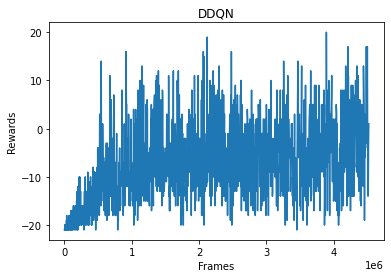

Episode:  1341
Steps:  1129452  epsilon:  0.03
Steps:  1129652  epsilon:  0.03
Steps:  1129852  epsilon:  0.03
Steps:  1130052  epsilon:  0.03
Steps:  1130252  epsilon:  0.03
Steps:  1130452  epsilon:  0.03
Steps:  1130652  epsilon:  0.03
Episode:  1342
Steps:  1130663  epsilon:  0.03
Steps:  1130863  epsilon:  0.03
Steps:  1131063  epsilon:  0.03
Steps:  1131263  epsilon:  0.03
Steps:  1131463  epsilon:  0.03
Steps:  1131663  epsilon:  0.03
Episode:  1343
Steps:  1131686  epsilon:  0.03
Steps:  1131886  epsilon:  0.03
Steps:  1132086  epsilon:  0.03
Steps:  1132286  epsilon:  0.03
Steps:  1132486  epsilon:  0.03
Episode:  1344
Steps:  1132672  epsilon:  0.03
Steps:  1132872  epsilon:  0.03
Steps:  1133072  epsilon:  0.03
Steps:  1133272  epsilon:  0.03
Steps:  1133472  epsilon:  0.03
Steps:  1133672  epsilon:  0.03
Episode:  1345
Steps:  1133710  epsilon:  0.03
Steps:  1133910  epsilon:  0.03
Steps:  1134110  epsilon:  0.03
Steps:  1134310  epsilon:  0.03
Steps:  1134510  epsilon:  0.

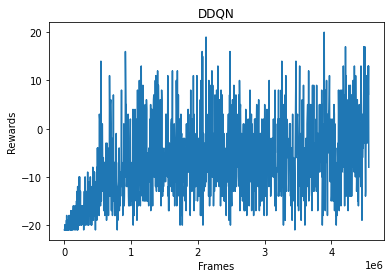

Episode:  1351
Steps:  1138986  epsilon:  0.03
Steps:  1139186  epsilon:  0.03
Steps:  1139386  epsilon:  0.03
Steps:  1139586  epsilon:  0.03
Steps:  1139786  epsilon:  0.03
Episode:  1352
Steps:  1139868  epsilon:  0.03
Steps:  1140068  epsilon:  0.03
Steps:  1140268  epsilon:  0.03
Steps:  1140468  epsilon:  0.03
Steps:  1140668  epsilon:  0.03
Episode:  1353
Steps:  1140771  epsilon:  0.03
Steps:  1140971  epsilon:  0.03
Steps:  1141171  epsilon:  0.03
Steps:  1141371  epsilon:  0.03
Episode:  1354
Steps:  1141520  epsilon:  0.03
Steps:  1141720  epsilon:  0.03
Steps:  1141920  epsilon:  0.03
Steps:  1142120  epsilon:  0.03
Episode:  1355
Steps:  1142273  epsilon:  0.03
Steps:  1142473  epsilon:  0.03
Steps:  1142673  epsilon:  0.03
Steps:  1142873  epsilon:  0.03
Steps:  1143073  epsilon:  0.03
Episode:  1356
Steps:  1143230  epsilon:  0.03
Steps:  1143430  epsilon:  0.03
Steps:  1143630  epsilon:  0.03
Steps:  1143830  epsilon:  0.03
Steps:  1144030  epsilon:  0.03
Episode:  1357

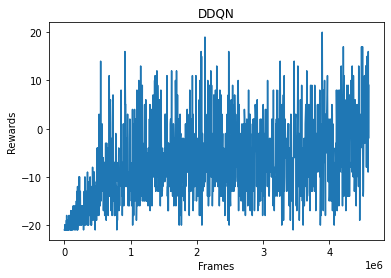

Episode:  1361
Steps:  1147716  epsilon:  0.03
Steps:  1147916  epsilon:  0.03
Steps:  1148116  epsilon:  0.03
Steps:  1148316  epsilon:  0.03
Steps:  1148516  epsilon:  0.03
Episode:  1362
Steps:  1148590  epsilon:  0.03
Steps:  1148790  epsilon:  0.03
Steps:  1148990  epsilon:  0.03
Steps:  1149190  epsilon:  0.03
Episode:  1363
Steps:  1149339  epsilon:  0.03
Steps:  1149539  epsilon:  0.03
Steps:  1149739  epsilon:  0.03
Steps:  1149939  epsilon:  0.03
Steps:  1150139  epsilon:  0.03
Episode:  1364
Steps:  1150311  epsilon:  0.03
Steps:  1150511  epsilon:  0.03
Steps:  1150711  epsilon:  0.03
Steps:  1150911  epsilon:  0.03
Steps:  1151111  epsilon:  0.03
Episode:  1365
Steps:  1151118  epsilon:  0.03
Steps:  1151318  epsilon:  0.03
Steps:  1151518  epsilon:  0.03
Steps:  1151718  epsilon:  0.03
Steps:  1151918  epsilon:  0.03
Episode:  1366
Steps:  1152095  epsilon:  0.03
Steps:  1152295  epsilon:  0.03
Steps:  1152495  epsilon:  0.03
Steps:  1152695  epsilon:  0.03
Steps:  115289

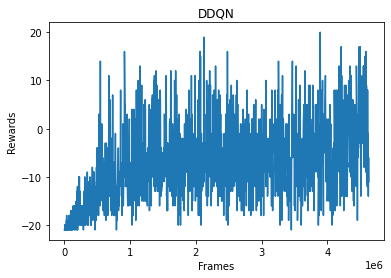

Episode:  1371
Steps:  1156726  epsilon:  0.03
Steps:  1156926  epsilon:  0.03
Steps:  1157126  epsilon:  0.03
Steps:  1157326  epsilon:  0.03
Steps:  1157526  epsilon:  0.03
Episode:  1372
Steps:  1157537  epsilon:  0.03
Steps:  1157737  epsilon:  0.03
Steps:  1157937  epsilon:  0.03
Steps:  1158137  epsilon:  0.03
Episode:  1373
Steps:  1158274  epsilon:  0.03
Steps:  1158474  epsilon:  0.03
Steps:  1158674  epsilon:  0.03
Steps:  1158874  epsilon:  0.03
Steps:  1159074  epsilon:  0.03
Episode:  1374
Steps:  1159119  epsilon:  0.03
Steps:  1159319  epsilon:  0.03
Steps:  1159519  epsilon:  0.03
Steps:  1159719  epsilon:  0.03
Steps:  1159919  epsilon:  0.03
Episode:  1375
Steps:  1160115  epsilon:  0.03
Steps:  1160315  epsilon:  0.03
Steps:  1160515  epsilon:  0.03
Steps:  1160715  epsilon:  0.03
Steps:  1160915  epsilon:  0.03
Steps:  1161115  epsilon:  0.03
Episode:  1376
Steps:  1161202  epsilon:  0.03
Steps:  1161402  epsilon:  0.03
Steps:  1161602  epsilon:  0.03
Steps:  116180

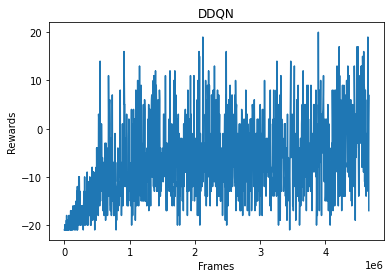

Episode:  1381
Steps:  1165226  epsilon:  0.03
Steps:  1165426  epsilon:  0.03
Steps:  1165626  epsilon:  0.03
Steps:  1165826  epsilon:  0.03
Steps:  1166026  epsilon:  0.03
Episode:  1382
Steps:  1166094  epsilon:  0.03
Steps:  1166294  epsilon:  0.03
Steps:  1166494  epsilon:  0.03
Steps:  1166694  epsilon:  0.03
Steps:  1166894  epsilon:  0.03
Steps:  1167094  epsilon:  0.03
Episode:  1383
Steps:  1167139  epsilon:  0.03
Steps:  1167339  epsilon:  0.03
Steps:  1167539  epsilon:  0.03
Steps:  1167739  epsilon:  0.03
Steps:  1167939  epsilon:  0.03
Steps:  1168139  epsilon:  0.03
Episode:  1384
Steps:  1168202  epsilon:  0.03
Steps:  1168402  epsilon:  0.03
Steps:  1168602  epsilon:  0.03
Steps:  1168802  epsilon:  0.03
Steps:  1169002  epsilon:  0.03
Steps:  1169202  epsilon:  0.03
Episode:  1385
Steps:  1169319  epsilon:  0.03
Steps:  1169519  epsilon:  0.03
Steps:  1169719  epsilon:  0.03
Steps:  1169919  epsilon:  0.03
Steps:  1170119  epsilon:  0.03
Episode:  1386
Steps:  117031

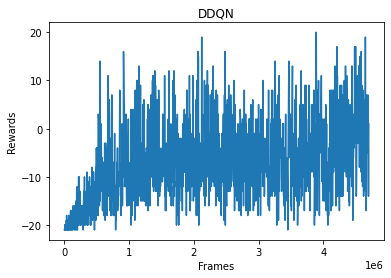

Episode:  1391
Steps:  1174987  epsilon:  0.03
Steps:  1175187  epsilon:  0.03
Steps:  1175387  epsilon:  0.03
Steps:  1175587  epsilon:  0.03
Episode:  1392
Steps:  1175611  epsilon:  0.03
Steps:  1175811  epsilon:  0.03
Steps:  1176011  epsilon:  0.03
Steps:  1176211  epsilon:  0.03
Steps:  1176411  epsilon:  0.03
Steps:  1176611  epsilon:  0.03
Episode:  1393
Steps:  1176659  epsilon:  0.03
Steps:  1176859  epsilon:  0.03
Steps:  1177059  epsilon:  0.03
Steps:  1177259  epsilon:  0.03
Episode:  1394
Steps:  1177419  epsilon:  0.03
Steps:  1177619  epsilon:  0.03
Steps:  1177819  epsilon:  0.03
Steps:  1178019  epsilon:  0.03
Episode:  1395
Steps:  1178195  epsilon:  0.03
Steps:  1178395  epsilon:  0.03
Steps:  1178595  epsilon:  0.03
Steps:  1178795  epsilon:  0.03
Steps:  1178995  epsilon:  0.03
Episode:  1396
Steps:  1179061  epsilon:  0.03
Steps:  1179261  epsilon:  0.03
Steps:  1179461  epsilon:  0.03
Steps:  1179661  epsilon:  0.03
Episode:  1397
Steps:  1179856  epsilon:  0.03

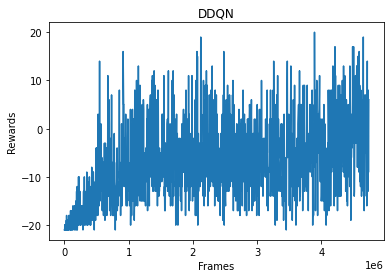

Episode:  1401
Steps:  1183171  epsilon:  0.03
Steps:  1183371  epsilon:  0.03
Steps:  1183571  epsilon:  0.03
Steps:  1183771  epsilon:  0.03
Steps:  1183971  epsilon:  0.03
Episode:  1402
Steps:  1183972  epsilon:  0.03
Steps:  1184172  epsilon:  0.03
Steps:  1184372  epsilon:  0.03
Episode:  1403
Steps:  1184442  epsilon:  0.03
Steps:  1184642  epsilon:  0.03
Steps:  1184842  epsilon:  0.03
Episode:  1404
Steps:  1185018  epsilon:  0.03
Steps:  1185218  epsilon:  0.03
Steps:  1185418  epsilon:  0.03
Steps:  1185618  epsilon:  0.03
Episode:  1405
Steps:  1185815  epsilon:  0.03
Steps:  1186015  epsilon:  0.03
Steps:  1186215  epsilon:  0.03
Steps:  1186415  epsilon:  0.03
Steps:  1186615  epsilon:  0.03
Episode:  1406
Steps:  1186804  epsilon:  0.03
Steps:  1187004  epsilon:  0.03
Steps:  1187204  epsilon:  0.03
Steps:  1187404  epsilon:  0.03
Steps:  1187604  epsilon:  0.03
Episode:  1407
Steps:  1187610  epsilon:  0.03
Steps:  1187810  epsilon:  0.03
Steps:  1188010  epsilon:  0.03

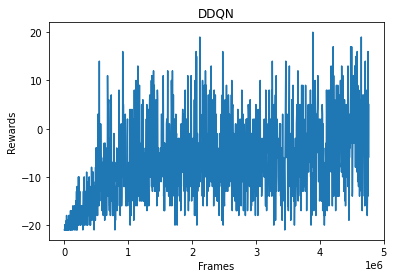

Episode:  1411
Steps:  1191142  epsilon:  0.03
Steps:  1191342  epsilon:  0.03
Steps:  1191542  epsilon:  0.03
Steps:  1191742  epsilon:  0.03
Steps:  1191942  epsilon:  0.03
Steps:  1192142  epsilon:  0.03
Episode:  1412
Steps:  1192192  epsilon:  0.03
Steps:  1192392  epsilon:  0.03
Steps:  1192592  epsilon:  0.03
Steps:  1192792  epsilon:  0.03
Episode:  1413
Steps:  1192910  epsilon:  0.03
Steps:  1193110  epsilon:  0.03
Steps:  1193310  epsilon:  0.03
Steps:  1193510  epsilon:  0.03
Steps:  1193710  epsilon:  0.03
Steps:  1193910  epsilon:  0.03
Steps:  1194110  epsilon:  0.03
Episode:  1414
Steps:  1194151  epsilon:  0.03
Steps:  1194351  epsilon:  0.03
Steps:  1194551  epsilon:  0.03
Steps:  1194751  epsilon:  0.03
Episode:  1415
Steps:  1194846  epsilon:  0.03
Steps:  1195046  epsilon:  0.03
Steps:  1195246  epsilon:  0.03
Steps:  1195446  epsilon:  0.03
Steps:  1195646  epsilon:  0.03
Episode:  1416
Steps:  1195747  epsilon:  0.03
Steps:  1195947  epsilon:  0.03
Steps:  119614

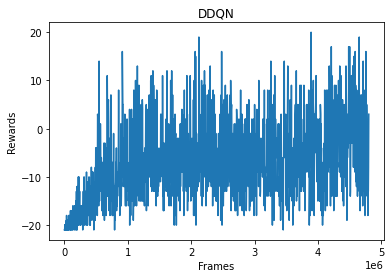

Episode:  1421
Steps:  1199529  epsilon:  0.03
Steps:  1199729  epsilon:  0.03
Steps:  1199929  epsilon:  0.03
Episode:  1422
Steps:  1200012  epsilon:  0.03
Steps:  1200212  epsilon:  0.03
Steps:  1200412  epsilon:  0.03
Steps:  1200612  epsilon:  0.03
Steps:  1200812  epsilon:  0.03
Episode:  1423
Steps:  1200921  epsilon:  0.03
Steps:  1201121  epsilon:  0.03
Steps:  1201321  epsilon:  0.03
Steps:  1201521  epsilon:  0.03
Steps:  1201721  epsilon:  0.03
Episode:  1424
Steps:  1201852  epsilon:  0.03
Steps:  1202052  epsilon:  0.03
Steps:  1202252  epsilon:  0.03
Steps:  1202452  epsilon:  0.03
Steps:  1202652  epsilon:  0.03
Episode:  1425
Steps:  1202697  epsilon:  0.03
Steps:  1202897  epsilon:  0.03
Steps:  1203097  epsilon:  0.03
Steps:  1203297  epsilon:  0.03
Steps:  1203497  epsilon:  0.03
Steps:  1203697  epsilon:  0.03
Episode:  1426
Steps:  1203728  epsilon:  0.03
Steps:  1203928  epsilon:  0.03
Steps:  1204128  epsilon:  0.03
Steps:  1204328  epsilon:  0.03
Steps:  120452

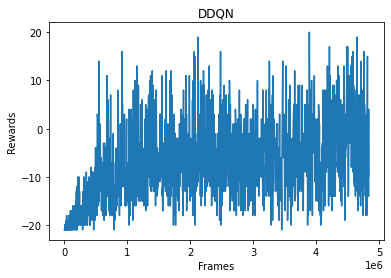

Episode:  1431
Steps:  1208007  epsilon:  0.03
Steps:  1208207  epsilon:  0.03
Steps:  1208407  epsilon:  0.03
Steps:  1208607  epsilon:  0.03
Steps:  1208807  epsilon:  0.03
Episode:  1432
Steps:  1208913  epsilon:  0.03
Steps:  1209113  epsilon:  0.03
Steps:  1209313  epsilon:  0.03
Steps:  1209513  epsilon:  0.03
Steps:  1209713  epsilon:  0.03
Episode:  1433
Steps:  1209904  epsilon:  0.03
Steps:  1210104  epsilon:  0.03
Steps:  1210304  epsilon:  0.03
Steps:  1210504  epsilon:  0.03
Steps:  1210704  epsilon:  0.03
Episode:  1434
Steps:  1210774  epsilon:  0.03
Steps:  1210974  epsilon:  0.03
Steps:  1211174  epsilon:  0.03
Steps:  1211374  epsilon:  0.03
Steps:  1211574  epsilon:  0.03
Steps:  1211774  epsilon:  0.03
Episode:  1435
Steps:  1211848  epsilon:  0.03
Steps:  1212048  epsilon:  0.03
Steps:  1212248  epsilon:  0.03
Steps:  1212448  epsilon:  0.03
Steps:  1212648  epsilon:  0.03
Episode:  1436
Steps:  1212839  epsilon:  0.03
Steps:  1213039  epsilon:  0.03
Steps:  121323

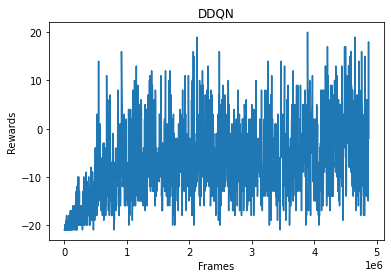

Episode:  1441
Steps:  1217074  epsilon:  0.03
Steps:  1217274  epsilon:  0.03
Steps:  1217474  epsilon:  0.03
Steps:  1217674  epsilon:  0.03
Steps:  1217874  epsilon:  0.03
Episode:  1442
Steps:  1217909  epsilon:  0.03
Steps:  1218109  epsilon:  0.03
Steps:  1218309  epsilon:  0.03
Steps:  1218509  epsilon:  0.03
Steps:  1218709  epsilon:  0.03
Episode:  1443
Steps:  1218853  epsilon:  0.03
Steps:  1219053  epsilon:  0.03
Steps:  1219253  epsilon:  0.03
Steps:  1219453  epsilon:  0.03
Steps:  1219653  epsilon:  0.03
Episode:  1444
Steps:  1219781  epsilon:  0.03
Steps:  1219981  epsilon:  0.03
Steps:  1220181  epsilon:  0.03
Steps:  1220381  epsilon:  0.03
Steps:  1220581  epsilon:  0.03
Episode:  1445
Steps:  1220599  epsilon:  0.03
Steps:  1220799  epsilon:  0.03
Steps:  1220999  epsilon:  0.03
Steps:  1221199  epsilon:  0.03
Episode:  1446
Steps:  1221381  epsilon:  0.03
Steps:  1221581  epsilon:  0.03
Steps:  1221781  epsilon:  0.03
Steps:  1221981  epsilon:  0.03
Steps:  122218

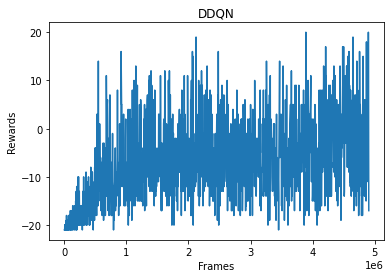

Episode:  1451
Steps:  1225445  epsilon:  0.03
Steps:  1225645  epsilon:  0.03
Steps:  1225845  epsilon:  0.03
Steps:  1226045  epsilon:  0.03
Episode:  1452
Steps:  1226235  epsilon:  0.03
Steps:  1226435  epsilon:  0.03
Steps:  1226635  epsilon:  0.03
Steps:  1226835  epsilon:  0.03
Steps:  1227035  epsilon:  0.03
Episode:  1453
Steps:  1227160  epsilon:  0.03
Steps:  1227360  epsilon:  0.03
Steps:  1227560  epsilon:  0.03
Steps:  1227760  epsilon:  0.03
Steps:  1227960  epsilon:  0.03
Episode:  1454
Steps:  1228064  epsilon:  0.03
Steps:  1228264  epsilon:  0.03
Steps:  1228464  epsilon:  0.03
Steps:  1228664  epsilon:  0.03
Episode:  1455
Steps:  1228707  epsilon:  0.03
Steps:  1228907  epsilon:  0.03
Steps:  1229107  epsilon:  0.03
Steps:  1229307  epsilon:  0.03
Episode:  1456
Steps:  1229357  epsilon:  0.03
Steps:  1229557  epsilon:  0.03
Steps:  1229757  epsilon:  0.03
Steps:  1229957  epsilon:  0.03
Steps:  1230157  epsilon:  0.03
Episode:  1457
Steps:  1230176  epsilon:  0.03

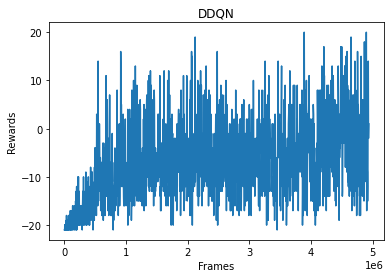

Episode:  1461
Steps:  1233816  epsilon:  0.03
Steps:  1234016  epsilon:  0.03
Steps:  1234216  epsilon:  0.03
Steps:  1234416  epsilon:  0.03
Steps:  1234616  epsilon:  0.03
Episode:  1462
Steps:  1234795  epsilon:  0.03
Steps:  1234995  epsilon:  0.03
Steps:  1235195  epsilon:  0.03
Steps:  1235395  epsilon:  0.03
Steps:  1235595  epsilon:  0.03
Episode:  1463
Steps:  1235610  epsilon:  0.03
Steps:  1235810  epsilon:  0.03
Steps:  1236010  epsilon:  0.03
Steps:  1236210  epsilon:  0.03
Steps:  1236410  epsilon:  0.03
Episode:  1464
Steps:  1236425  epsilon:  0.03
Steps:  1236625  epsilon:  0.03
Steps:  1236825  epsilon:  0.03
Steps:  1237025  epsilon:  0.03
Steps:  1237225  epsilon:  0.03
Episode:  1465
Steps:  1237353  epsilon:  0.03
Steps:  1237553  epsilon:  0.03
Steps:  1237753  epsilon:  0.03
Steps:  1237953  epsilon:  0.03
Episode:  1466
Steps:  1238124  epsilon:  0.03
Steps:  1238324  epsilon:  0.03
Steps:  1238524  epsilon:  0.03
Steps:  1238724  epsilon:  0.03
Episode:  1467

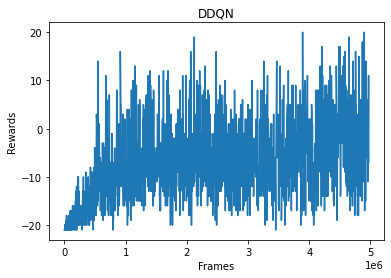

Episode:  1471
Steps:  1242242  epsilon:  0.03
Steps:  1242442  epsilon:  0.03
Steps:  1242642  epsilon:  0.03
Steps:  1242842  epsilon:  0.03
Steps:  1243042  epsilon:  0.03
Episode:  1472
Steps:  1243077  epsilon:  0.03
Steps:  1243277  epsilon:  0.03
Steps:  1243477  epsilon:  0.03
Steps:  1243677  epsilon:  0.03
Episode:  1473
Steps:  1243813  epsilon:  0.03
Steps:  1244013  epsilon:  0.03
Steps:  1244213  epsilon:  0.03
Episode:  1474
Steps:  1244282  epsilon:  0.03
Steps:  1244482  epsilon:  0.03
Steps:  1244682  epsilon:  0.03
Steps:  1244882  epsilon:  0.03
Steps:  1245082  epsilon:  0.03
Episode:  1475
Steps:  1245095  epsilon:  0.03
Steps:  1245295  epsilon:  0.03
Steps:  1245495  epsilon:  0.03
Steps:  1245695  epsilon:  0.03
Steps:  1245895  epsilon:  0.03
Episode:  1476
Steps:  1245909  epsilon:  0.03
Steps:  1246109  epsilon:  0.03
Steps:  1246309  epsilon:  0.03
Steps:  1246509  epsilon:  0.03
Steps:  1246709  epsilon:  0.03
Episode:  1477
Steps:  1246752  epsilon:  0.03

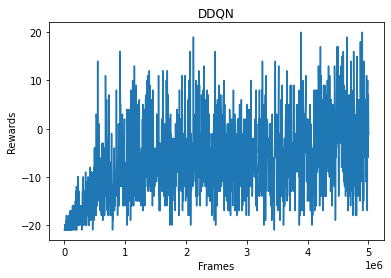

Episode:  1481
Steps:  1250479  epsilon:  0.03
Steps:  1250679  epsilon:  0.03
Steps:  1250879  epsilon:  0.03
Steps:  1251079  epsilon:  0.03
Steps:  1251279  epsilon:  0.03
Episode:  1482
Steps:  1251333  epsilon:  0.03
Steps:  1251533  epsilon:  0.03
Steps:  1251733  epsilon:  0.03
Episode:  1483
Steps:  1251911  epsilon:  0.03
Steps:  1252111  epsilon:  0.03
Steps:  1252311  epsilon:  0.03
Steps:  1252511  epsilon:  0.03
Steps:  1252711  epsilon:  0.03
Episode:  1484
Steps:  1252767  epsilon:  0.03
Steps:  1252967  epsilon:  0.03
Steps:  1253167  epsilon:  0.03
Steps:  1253367  epsilon:  0.03
Steps:  1253567  epsilon:  0.03
Episode:  1485
Steps:  1253732  epsilon:  0.03
Steps:  1253932  epsilon:  0.03
Steps:  1254132  epsilon:  0.03
Steps:  1254332  epsilon:  0.03
Steps:  1254532  epsilon:  0.03
Episode:  1486
Steps:  1254707  epsilon:  0.03
Steps:  1254907  epsilon:  0.03
Steps:  1255107  epsilon:  0.03
Steps:  1255307  epsilon:  0.03
Episode:  1487
Steps:  1255444  epsilon:  0.03

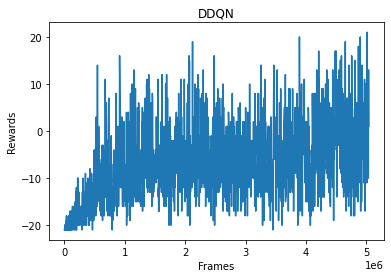

Episode:  1491
Steps:  1258997  epsilon:  0.03
Steps:  1259197  epsilon:  0.03
Steps:  1259397  epsilon:  0.03
Steps:  1259597  epsilon:  0.03
Episode:  1492
Steps:  1259749  epsilon:  0.03
Steps:  1259949  epsilon:  0.03
Steps:  1260149  epsilon:  0.03
Episode:  1493
Steps:  1260243  epsilon:  0.03
Steps:  1260443  epsilon:  0.03
Steps:  1260643  epsilon:  0.03
Steps:  1260843  epsilon:  0.03
Steps:  1261043  epsilon:  0.03
Episode:  1494
Steps:  1261089  epsilon:  0.03
Steps:  1261289  epsilon:  0.03
Steps:  1261489  epsilon:  0.03
Steps:  1261689  epsilon:  0.03
Steps:  1261889  epsilon:  0.03
Episode:  1495
Steps:  1261908  epsilon:  0.03
Steps:  1262108  epsilon:  0.03
Steps:  1262308  epsilon:  0.03
Steps:  1262508  epsilon:  0.03
Steps:  1262708  epsilon:  0.03
Episode:  1496
Steps:  1262711  epsilon:  0.03
Steps:  1262911  epsilon:  0.03
Steps:  1263111  epsilon:  0.03
Steps:  1263311  epsilon:  0.03
Steps:  1263511  epsilon:  0.03
Episode:  1497
Steps:  1263535  epsilon:  0.03

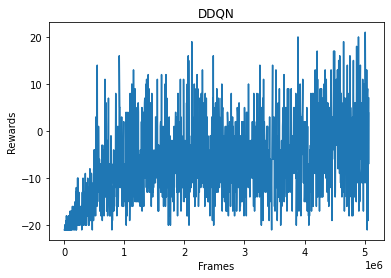

FileNotFoundError: ignored

In [11]:
EPSILON = 1
MIN_EPSILON = 0.03
DECAY = 20000
env = gym.make("Pong-v0")
n_actions = env.action_space.n
agent = Agent(num_frames, n_actions)
durations = []
Rewards=[]
frames=[]
frame_cnt=0
steps_done=0

def TrainAgent(episodes):
    global frame_cnt
    global R
    global steps_done
    for episode in range(episodes):
        print("Episode: ", episode)
        env.reset()
        states = [i for i in range(num_frames)]
        actions = [i for i in range(num_frames-1)]
        done = [False for i in range(num_frames-1)]
        for i in range(num_frames-1):
            states[i] = get_preprocessed_state()
            actions[i] = get_variable(torch.tensor([[random.randrange(n_actions)]]))
            _, _, done[i], _ = env.step(actions[i].item())
            
        states[num_frames-1] = get_preprocessed_state()
        state = get_variable( Variable(torch.cat([states[i].squeeze(0) for i in range(num_frames)]).unsqueeze(0)))
        Reward = 0.0
        frame_cnt += num_frames
        
        if(sum(done) != 0):
            Rewards.append(Reward)
            frames.append(frame_cnt)
        else:
            for steps in count():
                epsilon = decay_epsilon(steps_done)
                steps_done +=1
                if random.random() > epsilon:
                    with torch.no_grad():
                        action = get_variable(agent.model(state).max(1)[1].view(1, 1))
                else:
                    action = get_variable(torch.tensor([[random.randrange(n_actions)]], dtype=torch.long))
                re = 0.0
                s = [i for i in range(num_frames)]
                ended = [False for i in range(num_frames)]
                for i in range(num_frames):
                    _, r, ended[i], _ = env.step(action.item())
                    frame_cnt += 1
                    re += r
                    s[i] = get_preprocessed_state()
                    if ended[i]:
                        break
                reward = get_variable(torch.tensor([re]))
                
                #print output every 200 steps!!
                if steps % 200 == 0:
                    print("Steps: ", steps_done, " epsilon: ", epsilon)
                
                if sum(ended) == 0:
                    next_state = get_variable(torch.cat([s[i].squeeze(0) for i in range(num_frames)]).unsqueeze(0))
                    
                else:
                    next_state = None
                # Add each transition into the replay memory
                agent.memory.add(state, action, next_state, reward)
                
                state = Variable(next_state)
                Reward += re
                
                
                agent.train()
                if(sum(ended) != 0):
                    Rewards.append(Reward)
                    frames.append(frame_cnt)
                    break
                    
                if frame_cnt % TARGET_UPDATE_FREQUENCY == 0:
                    agent.target_model.load_state_dict(agent.model.state_dict())
                    
            if episode % 10 == 0:
                plt.plot(frames, Rewards)
                plt.xlabel('Frames')
                plt.ylabel('Rewards')
                plt.title("DDQN")
                plt.show()
        
    torch.save(agent.model.state_dict(), path)

TrainAgent(episodes)

## References

1. https://github.com/adamtiger/DQN/tree/f4aa6e9fb31ac72568f20509097c9981c77b73e4
2. https://pytorch.org/tutorials/beginner/saving_loading_models.html
3. https://pytorch.org/docs/stable/nn.html
4. https://pytorch.org/cppdocs/api/classtorch_1_1nn_1_1_conv2d.html
5. https://discuss.pytorch.org/t/how-to-convert-array-to-tensor/28809
6. https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
7. https://github.com/chaitanya100100/RL-Algorithms-Pytorch/tree/master/DQN_DDQN
8. https://www.neuralnet.ai/coding-a-deep-q-network-in-pytorch/